#Cooking#

Create df. Current df is about 10 000 lines

In [1]:
df_columns = ['S0', 'v0', 'r']

for i in range(252):
    df_columns.append(f'S_{i}')

print(df_columns)

['S0', 'v0', 'r', 'S_0', 'S_1', 'S_2', 'S_3', 'S_4', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_10', 'S_11', 'S_12', 'S_13', 'S_14', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_21', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_28', 'S_29', 'S_30', 'S_31', 'S_32', 'S_33', 'S_34', 'S_35', 'S_36', 'S_37', 'S_38', 'S_39', 'S_40', 'S_41', 'S_42', 'S_43', 'S_44', 'S_45', 'S_46', 'S_47', 'S_48', 'S_49', 'S_50', 'S_51', 'S_52', 'S_53', 'S_54', 'S_55', 'S_56', 'S_57', 'S_58', 'S_59', 'S_60', 'S_61', 'S_62', 'S_63', 'S_64', 'S_65', 'S_66', 'S_67', 'S_68', 'S_69', 'S_70', 'S_71', 'S_72', 'S_73', 'S_74', 'S_75', 'S_76', 'S_77', 'S_78', 'S_79', 'S_80', 'S_81', 'S_82', 'S_83', 'S_84', 'S_85', 'S_86', 'S_87', 'S_88', 'S_89', 'S_90', 'S_91', 'S_92', 'S_93', 'S_94', 'S_95', 'S_96', 'S_97', 'S_98', 'S_99', 'S_100', 'S_101', 'S_102', 'S_103', 'S_104', 'S_105', 'S_106', 'S_107', 'S_108', 'S_109', 'S_110', 'S_111', 'S_112', 'S_113', 'S_114', 'S_115', 'S_116', 'S_117', 'S_118', 'S_119', 'S_120', 'S_

In [ ]:
import numpy as np


def bs_price(S0, v0, r, T, N, M):

    dt = T/N
    mu = np.array([0,0])
    rho = 0
    cov = np.array([[1,rho],
                    [rho,1]])

    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)


    Z = np.random.multivariate_normal(mu, cov, (N,M))


    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = v[i-1]

    return S, v

In [6]:

import itertools
import pandas as pd
from tqdm import tqdm
import os
import time
import numpy as np
from tqdm import tqdm
import jax
import jax.numpy as jnp
from jax import random
import optax
from flax import linen as nn
from flax.training import train_state

import pickle
from scipy.integrate import solve_ivp
from typing import List


S0 = 100.0             # asset price
T = 1.0                # time in years
N = 251               # number of time steps in simulation
M = 1


return_df = pd.DataFrame(columns = df_columns)
for i in tqdm(range(100000)):
  current_params = np.random.uniform(0, 1, size = (1,2))

  S_p,v_p = bs_price(S0, v0 = current_params[0][0],r = current_params[0][1], T = T, N = N, M = M)
  S_p_mean = []
  for i in range(len(v_p)):
    S_p_mean.append(S_p[i].mean())
  tmp_list = [S0, current_params[0][0], current_params[0][1]]
  #tmp_df_s = list(itertools.chain.from_iterable(S_p_mean))
  tmp_df_s = S_p_mean
  tmp_df = pd.DataFrame(columns = df_columns)

  tmp_list_return = tmp_list.extend(tmp_df_s)


  tmp_df.loc[len(tmp_df)] = tmp_list
  return_df = pd.concat([return_df, tmp_df], ignore_index=True)

print(return_df)


  0%|          | 0/100000 [00:00<?, ?it/s]


NameError: name 'bs_price' is not defined

In [ ]:
m = return_df.iloc[:,1:3]
m = m.to_numpy()

In [ ]:
d = return_df.iloc[:,3:]
d = d.to_numpy()

In [ ]:
np.save('d_tensorflow_vol_bs_uniform_prices_true.npy', d)
np.save('m_tensorflow_vol_bs_uniform_prices_true.npy', m)

Ниже попытка сгладить временные ряды

In [ ]:
return_df_new = return_df.copy()

In [ ]:

def transform(d):
  # constructing the D matrix for LSM
  price_vec = np.array(d).reshape(-1,1)
  #price_vec = price_vec.reshape(-1,1)
  n = price_vec.shape[0]

  D = np.zeros((n-1 , n))
  for i in range(n-1):
      D[i,i] = 1
      D[i,i+1] = -1
  lambda_list = [30]


  x_list = []
  for LAMBDA in lambda_list:
      # Ax = B --> min||Ax-b||^2
      A = np.vstack([np.eye(n), (LAMBDA**0.5)*D])
      b = np.vstack([price_vec,np.zeros((n-1,1))])

      # Least squares
      # x = INV(X.T* X) * X.T * b
      x = np.matmul(np.linalg.inv(np.matmul(A.T,A)),  np.matmul(A.T,b)).reshape(1,-1)
      x_list.append(x)
  return x_list

In [ ]:

for i in range(len(return_df_new)):
  d = list(return_df_new.iloc[i,3:])
  tmp = transform(d)[0][0]
  return_df_new.iloc[i,3:] = tmp

return_df_new

,S0,v0,r,S_0,S_1,S_2,S_3,S_4,S_5,S_6,...,S_242,S_243,S_244,S_245,S_246,S_247,S_248,S_249,S_250,S_251
0,100.0,0.521297,0.528084,99.225073,99.199242,99.288876,99.413871,99.646273,100.102607,100.739867,...,702.586537,708.910696,715.441964,721.308365,727.881650,733.365096,738.952573,743.032063,745.449132,746.552213
1,100.0,0.801392,0.943939,104.351021,104.496055,104.634537,104.717518,104.887785,105.147039,105.451278,...,491.089292,499.912682,507.663497,513.337195,518.208583,521.460724,523.141630,524.591245,525.359052,525.250665
2,100.0,0.972865,0.467514,108.980870,109.280232,109.978141,111.078174,112.404280,113.653861,114.862788,...,117.493337,117.643821,117.969717,118.473978,119.072962,119.764716,120.453351,121.145051,121.823632,121.794529
3,100.0,0.788597,0.091916,102.534241,102.618715,102.609611,102.293209,101.845273,101.415166,100.915014,...,62.918858,62.209402,61.485038,60.720251,59.990117,59.478665,59.005874,58.550643,58.176613,57.974837
4,100.0,0.394001,0.016606,99.465336,99.447514,99.668143,100.047131,100.406068,100.873864,101.231585,...,78.408285,76.757239,75.149593,73.710386,72.518740,71.593764,70.864577,70.384011,69.985445,69.834603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,100.0,0.399387,0.003080,92.831654,92.592710,92.194719,91.641290,90.992670,90.186348,89.326455,...,56.517377,56.458861,56.474176,56.434956,56.307366,56.218891,56.155487,56.105762,56.094572,56.048402
99996,100.0,0.036651,0.475885,99.078872,99.048168,98.950486,98.807908,98.669175,98.527510,98.465398,...,169.511002,169.596914,169.630370,169.704646,169.748907,169.832094,169.839879,169.833603,169.850673,169.860818
99997,100.0,0.601996,0.318933,106.713397,106.937177,107.330662,107.758020,108.213902,108.655753,109.021356,...,91.612747,91.406789,91.198726,91.088083,91.110596,91.102975,91.184649,91.453822,91.539858,91.532559
99998,100.0,0.841473,0.990405,107.878309,108.140920,108.510201,109.171506,110.035222,110.969991,112.241168,...,124.518476,126.445139,128.137384,129.798176,131.474822,132.739236,133.858673,134.665952,135.120505,135.318820


In [ ]:
m = return_df_new.iloc[:,1:3]
m = m.to_numpy()

In [ ]:
d = return_df_new.iloc[:,3:]
d = d.to_numpy()

In [ ]:
np.save('d_tensorflow_vol_bs_uniform_prices_true_lined.npy', d)
np.save('m_tensorflow_vol_bs_uniform_prices_true_lined.npy', m)

In [26]:
m = jnp.load(f'm_tensorflow_vol_bs_uniform_prices_true_lined.npy')
d = jnp.load(f'd_tensorflow_vol_bs_uniform_prices_true_lined.npy')

In [27]:
dataset = jnp.concatenate([m, d], axis = 1)
tmp_df = pd.DataFrame(dataset, columns = df_columns[1:])
tmp_df

,v0,r,S_0,S_1,S_2,S_3,S_4,S_5,S_6,S_7,...,S_242,S_243,S_244,S_245,S_246,S_247,S_248,S_249,S_250,S_251
0,0.521297,0.528084,99.225075,99.199242,99.288872,99.413872,99.646271,100.102608,100.739868,101.358910,...,702.586548,708.910706,715.441956,721.308350,727.881653,733.365112,738.952576,743.032043,745.449158,746.552185
1,0.801392,0.943939,104.351021,104.496056,104.634537,104.717514,104.887787,105.147041,105.451279,105.392075,...,491.089294,499.912689,507.663483,513.337219,518.208557,521.460693,523.141602,524.591248,525.359070,525.250671
2,0.972865,0.467514,108.980873,109.280235,109.978142,111.078171,112.404282,113.653862,114.862785,116.125900,...,117.493340,117.643822,117.969719,118.473976,119.072960,119.764717,120.453354,121.145050,121.823631,121.794533
3,0.788597,0.091916,102.534241,102.618713,102.609612,102.293205,101.845276,101.415169,100.915016,100.528496,...,62.918858,62.209404,61.485039,60.720249,59.990116,59.478664,59.005875,58.550644,58.176613,57.974838
4,0.394001,0.016606,99.465340,99.447517,99.668144,100.047134,100.406067,100.873863,101.231583,101.308601,...,78.408287,76.757240,75.149590,73.710388,72.518738,71.593765,70.864578,70.384010,69.985443,69.834602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.399387,0.003080,92.831657,92.592712,92.194717,91.641289,90.992668,90.186348,89.326454,88.412346,...,56.517376,56.458862,56.474174,56.434956,56.307365,56.218891,56.155487,56.105762,56.094570,56.048401
99996,0.036651,0.475885,99.078873,99.048164,98.950485,98.807907,98.669174,98.527512,98.465401,98.473686,...,169.511002,169.596909,169.630371,169.704651,169.748901,169.832092,169.839874,169.833603,169.850677,169.860825
99997,0.601996,0.318933,106.713394,106.937180,107.330658,107.758018,108.213905,108.655754,109.021355,109.379890,...,91.612747,91.406792,91.198723,91.088081,91.110596,91.102974,91.184647,91.453819,91.539856,91.532562
99998,0.841473,0.990405,107.878311,108.140923,108.510201,109.171509,110.035225,110.969994,112.241165,114.058403,...,124.518478,126.445137,128.137390,129.798172,131.474823,132.739243,133.858673,134.665955,135.120499,135.318817


In [28]:
columns_list = list(tmp_df.columns)
for i in range(2,len(columns_list)-1):
  tmp_df[columns_list[i]] = (tmp_df[columns_list[i+1]] - tmp_df[columns_list[i]])/ tmp_df[columns_list[i]]

tmp_df['S_251'] = tmp_df['S_250']
tmp_df

,v0,r,S_0,S_1,S_2,S_3,S_4,S_5,S_6,S_7,...,S_242,S_243,S_244,S_245,S_246,S_247,S_248,S_249,S_250,S_251
0,0.521297,0.528084,-0.000260,0.000904,0.001259,0.002338,0.004580,0.006366,0.006145,0.006013,...,0.009001,0.009213,0.008200,0.009113,0.007533,0.007619,0.005521,0.003253,0.001480,0.001480
1,0.801392,0.943939,0.001390,0.001325,0.000793,0.001626,0.002472,0.002893,-0.000561,-0.002931,...,0.017967,0.015504,0.011176,0.009490,0.006276,0.003223,0.002771,0.001464,-0.000206,-0.000206
2,0.972865,0.467514,0.002747,0.006386,0.010002,0.011939,0.011117,0.010637,0.010997,0.011352,...,0.001281,0.002770,0.004274,0.005056,0.005810,0.005750,0.005742,0.005601,-0.000239,-0.000239
3,0.788597,0.091916,0.000824,-0.000089,-0.003084,-0.004379,-0.004223,-0.004932,-0.003830,-0.004090,...,-0.011276,-0.011644,-0.012439,-0.012025,-0.008526,-0.007949,-0.007715,-0.006388,-0.003468,-0.003468
4,0.394001,0.016606,-0.000179,0.002219,0.003803,0.003588,0.004659,0.003546,0.000761,-0.003329,...,-0.021057,-0.020945,-0.019151,-0.016167,-0.012755,-0.010185,-0.006781,-0.005663,-0.002155,-0.002155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.399387,0.003080,-0.002574,-0.004298,-0.006003,-0.007078,-0.008861,-0.009535,-0.010233,-0.009731,...,-0.001035,0.000271,-0.000694,-0.002261,-0.001571,-0.001128,-0.000885,-0.000199,-0.000823,-0.000823
99996,0.036651,0.475885,-0.000310,-0.000986,-0.001441,-0.001404,-0.001436,-0.000630,0.000084,0.000162,...,0.000507,0.000197,0.000438,0.000261,0.000490,0.000046,-0.000037,0.000101,0.000060,0.000060
99997,0.601996,0.318933,0.002097,0.003680,0.003982,0.004231,0.004083,0.003365,0.003289,0.003986,...,-0.002248,-0.002276,-0.001213,0.000247,-0.000084,0.000896,0.002952,0.000941,-0.000080,-0.000080
99998,0.841473,0.990405,0.002434,0.003415,0.006094,0.007912,0.008495,0.011455,0.016190,0.020513,...,0.015473,0.013383,0.012961,0.012917,0.009617,0.008433,0.006031,0.003375,0.001468,0.001468


In [29]:
m = tmp_df.iloc[:,0:2]
m = m.to_numpy()

In [30]:
d = tmp_df.iloc[:,2:]
d = d.to_numpy()

In [31]:
np.save('d_tensorflow_vol_bs_uniform_prices_true_lined_delta_true.npy', d)
np.save('m_tensorflow_vol_bs_uniform_prices_true_lined_delta_true.npy', m)

# CFM

In [3]:
import os
import time
import numpy as np
from tqdm import tqdm
import jax
import jax.numpy as jnp
from jax import random
import optax
from flax import linen as nn
from flax.training import train_state
import matplotlib.pyplot as plt
import pickle
from scipy.integrate import solve_ivp
from typing import List

254


  0%|          | 0/300000 [00:00<?, ?it/s]

<bound method _item of Array(0.22303776, dtype=float32)>


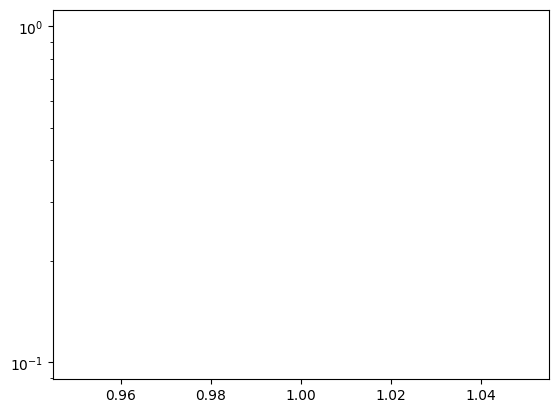

  0%|          | 116/300000 [00:19<1:29:08, 56.07it/s]

<bound method _item of Array(0.16672434, dtype=float32)>


  0%|          | 219/300000 [00:20<55:53, 89.40it/s]

<bound method _item of Array(0.16683058, dtype=float32)>


  0%|          | 319/300000 [00:21<55:43, 89.63it/s]

<bound method _item of Array(0.16537444, dtype=float32)>


  0%|          | 413/300000 [00:22<58:26, 85.44it/s]  

<bound method _item of Array(0.1636097, dtype=float32)>


  0%|          | 518/300000 [00:23<50:11, 99.46it/s]

<bound method _item of Array(0.16139883, dtype=float32)>


  0%|          | 621/300000 [00:24<50:21, 99.07it/s]

<bound method _item of Array(0.15777116, dtype=float32)>


  0%|          | 720/300000 [00:25<48:11, 103.50it/s]

<bound method _item of Array(0.15915327, dtype=float32)>


  0%|          | 819/300000 [00:26<48:33, 102.70it/s]

<bound method _item of Array(0.16189462, dtype=float32)>


  0%|          | 918/300000 [00:27<49:41, 100.31it/s]

<bound method _item of Array(0.1555609, dtype=float32)>


  0%|          | 1015/300000 [00:28<53:50, 92.56it/s]

<bound method _item of Array(0.15510657, dtype=float32)>


  0%|          | 1114/300000 [00:29<49:36, 100.42it/s]

<bound method _item of Array(0.15497531, dtype=float32)>


  0%|          | 1213/300000 [00:30<49:32, 100.51it/s]

<bound method _item of Array(0.15253809, dtype=float32)>


  0%|          | 1311/300000 [00:31<51:44, 96.21it/s]

<bound method _item of Array(0.15034923, dtype=float32)>


  0%|          | 1418/300000 [00:32<51:17, 97.02it/s]

<bound method _item of Array(0.15262629, dtype=float32)>


  1%|          | 1515/300000 [00:33<51:02, 97.47it/s]

<bound method _item of Array(0.15024213, dtype=float32)>


  1%|          | 1610/300000 [00:34<56:13, 88.45it/s]

<bound method _item of Array(0.14838624, dtype=float32)>


  1%|          | 1713/300000 [00:35<54:36, 91.04it/s]

<bound method _item of Array(0.14220323, dtype=float32)>


  1%|          | 1817/300000 [00:37<55:15, 89.94it/s]

<bound method _item of Array(0.14002243, dtype=float32)>


  1%|          | 1913/300000 [00:38<52:32, 94.55it/s]

<bound method _item of Array(0.14040153, dtype=float32)>


  1%|          | 2011/300000 [00:39<48:15, 102.91it/s]

<bound method _item of Array(0.13954836, dtype=float32)>


  1%|          | 2120/300000 [00:40<49:57, 99.39it/s]

<bound method _item of Array(0.14030056, dtype=float32)>


  1%|          | 2219/300000 [00:41<49:38, 99.99it/s]

<bound method _item of Array(0.13857877, dtype=float32)>


  1%|          | 2318/300000 [00:42<49:21, 100.51it/s]

<bound method _item of Array(0.13737264, dtype=float32)>


  1%|          | 2416/300000 [00:43<53:13, 93.17it/s]

<bound method _item of Array(0.13830397, dtype=float32)>


  1%|          | 2519/300000 [00:44<49:49, 99.50it/s]

<bound method _item of Array(0.13800873, dtype=float32)>


  1%|          | 2613/300000 [00:45<58:21, 84.93it/s]

<bound method _item of Array(0.1372854, dtype=float32)>


  1%|          | 2721/300000 [00:46<55:41, 88.98it/s]

<bound method _item of Array(0.1284388, dtype=float32)>


  1%|          | 2813/300000 [00:47<54:11, 91.39it/s]

<bound method _item of Array(0.12595774, dtype=float32)>


  1%|          | 2918/300000 [00:48<52:26, 94.40it/s]

<bound method _item of Array(0.12560776, dtype=float32)>


  1%|          | 3019/300000 [00:49<54:05, 91.51it/s]

<bound method _item of Array(0.1244543, dtype=float32)>


  1%|          | 3111/300000 [00:50<51:18, 96.45it/s]

<bound method _item of Array(0.12220287, dtype=float32)>


  1%|          | 3212/300000 [00:51<53:07, 93.12it/s]

<bound method _item of Array(0.11662071, dtype=float32)>


  1%|          | 3313/300000 [00:52<51:21, 96.28it/s]

<bound method _item of Array(0.11940894, dtype=float32)>


  1%|          | 3416/300000 [00:53<52:05, 94.91it/s]

<bound method _item of Array(0.11989925, dtype=float32)>


  1%|          | 3511/300000 [00:54<53:54, 91.65it/s]

<bound method _item of Array(0.11584853, dtype=float32)>


  1%|          | 3611/300000 [00:56<52:27, 94.16it/s]

<bound method _item of Array(0.11832763, dtype=float32)>


  1%|          | 3712/300000 [00:57<50:25, 97.93it/s]

<bound method _item of Array(0.1168478, dtype=float32)>


  1%|▏         | 3820/300000 [00:58<49:26, 99.84it/s] 

<bound method _item of Array(0.11604673, dtype=float32)>


  1%|▏         | 3919/300000 [00:59<48:31, 101.69it/s]

<bound method _item of Array(0.11760381, dtype=float32)>


  1%|▏         | 4018/300000 [01:00<48:43, 101.25it/s]

<bound method _item of Array(0.11560927, dtype=float32)>


  1%|▏         | 4116/300000 [01:01<50:05, 98.46it/s]

<bound method _item of Array(0.11793867, dtype=float32)>


  1%|▏         | 4220/300000 [01:02<49:42, 99.16it/s]

<bound method _item of Array(0.11487798, dtype=float32)>


  1%|▏         | 4313/300000 [01:03<55:16, 89.16it/s]

<bound method _item of Array(0.11420298, dtype=float32)>


  1%|▏         | 4418/300000 [01:04<49:28, 99.58it/s]

<bound method _item of Array(0.11250164, dtype=float32)>


  2%|▏         | 4514/300000 [01:05<53:57, 91.28it/s]

<bound method _item of Array(0.11250976, dtype=float32)>


  2%|▏         | 4617/300000 [01:06<51:11, 96.18it/s]

<bound method _item of Array(0.10964574, dtype=float32)>


  2%|▏         | 4711/300000 [01:07<58:09, 84.62it/s]

<bound method _item of Array(0.10701385, dtype=float32)>


  2%|▏         | 4821/300000 [01:08<50:30, 97.39it/s]

<bound method _item of Array(0.10661905, dtype=float32)>


  2%|▏         | 4914/300000 [01:09<53:04, 92.65it/s]

<bound method _item of Array(0.10711917, dtype=float32)>


  2%|▏         | 5017/300000 [01:10<52:56, 92.87it/s]

<bound method _item of Array(0.10551572, dtype=float32)>


  2%|▏         | 5109/300000 [01:11<50:22, 97.56it/s]

<bound method _item of Array(0.10568167, dtype=float32)>


  2%|▏         | 5210/300000 [01:12<57:30, 85.43it/s]

<bound method _item of Array(0.10265654, dtype=float32)>


  2%|▏         | 5318/300000 [01:14<50:50, 96.59it/s]

<bound method _item of Array(0.10253677, dtype=float32)>


  2%|▏         | 5413/300000 [01:15<50:47, 96.67it/s]

<bound method _item of Array(0.10091878, dtype=float32)>


  2%|▏         | 5515/300000 [01:16<52:40, 93.17it/s]

<bound method _item of Array(0.10061587, dtype=float32)>


  2%|▏         | 5609/300000 [01:17<52:08, 94.10it/s]

<bound method _item of Array(0.09921847, dtype=float32)>


  2%|▏         | 5716/300000 [01:18<49:06, 99.86it/s]

<bound method _item of Array(0.09830684, dtype=float32)>


  2%|▏         | 5815/300000 [01:19<48:38, 100.80it/s]

<bound method _item of Array(0.09777176, dtype=float32)>


  2%|▏         | 5920/300000 [01:20<51:01, 96.05it/s]

<bound method _item of Array(0.09789344, dtype=float32)>


  2%|▏         | 6011/300000 [01:21<50:52, 96.31it/s]

<bound method _item of Array(0.09679922, dtype=float32)>


  2%|▏         | 6113/300000 [01:22<53:48, 91.02it/s]

<bound method _item of Array(0.09641281, dtype=float32)>


  2%|▏         | 6215/300000 [01:23<49:37, 98.66it/s]

<bound method _item of Array(0.10065588, dtype=float32)>


  2%|▏         | 6318/300000 [01:24<49:33, 98.75it/s]

<bound method _item of Array(0.09552652, dtype=float32)>


  2%|▏         | 6420/300000 [01:25<50:19, 97.24it/s]

<bound method _item of Array(0.09732764, dtype=float32)>


  2%|▏         | 6515/300000 [01:26<49:21, 99.08it/s]

<bound method _item of Array(0.09747837, dtype=float32)>


  2%|▏         | 6612/300000 [01:27<52:51, 92.52it/s]

<bound method _item of Array(0.09619898, dtype=float32)>


  2%|▏         | 6715/300000 [01:28<49:51, 98.03it/s]

<bound method _item of Array(0.09769057, dtype=float32)>


  2%|▏         | 6815/300000 [01:29<50:54, 95.98it/s]

<bound method _item of Array(0.09367163, dtype=float32)>


  2%|▏         | 6916/300000 [01:30<52:55, 92.29it/s]

<bound method _item of Array(0.09555744, dtype=float32)>


  2%|▏         | 7017/300000 [01:31<51:35, 94.65it/s]

<bound method _item of Array(0.09470511, dtype=float32)>


  2%|▏         | 7108/300000 [01:32<55:25, 88.07it/s]

<bound method _item of Array(0.09637821, dtype=float32)>


  2%|▏         | 7218/300000 [01:33<50:39, 96.33it/s]

<bound method _item of Array(0.09532464, dtype=float32)>


  2%|▏         | 7321/300000 [01:34<48:34, 100.41it/s]

<bound method _item of Array(0.0920108, dtype=float32)>


  2%|▏         | 7420/300000 [01:35<48:49, 99.87it/s]

<bound method _item of Array(0.09284879, dtype=float32)>


  3%|▎         | 7511/300000 [01:36<50:03, 97.39it/s]

<bound method _item of Array(0.09385523, dtype=float32)>


  3%|▎         | 7613/300000 [01:37<49:14, 98.96it/s]

<bound method _item of Array(0.09328297, dtype=float32)>


  3%|▎         | 7717/300000 [01:38<50:32, 96.38it/s]

<bound method _item of Array(0.09287918, dtype=float32)>


  3%|▎         | 7814/300000 [01:39<51:31, 94.51it/s]

<bound method _item of Array(0.09240703, dtype=float32)>


  3%|▎         | 7919/300000 [01:40<48:47, 99.76it/s]

<bound method _item of Array(0.09112218, dtype=float32)>


  3%|▎         | 8014/300000 [01:41<48:55, 99.45it/s]

<bound method _item of Array(0.09243745, dtype=float32)>


  3%|▎         | 8120/300000 [01:43<51:59, 93.56it/s]

<bound method _item of Array(0.0917281, dtype=float32)>


  3%|▎         | 8212/300000 [01:43<52:02, 93.46it/s]

<bound method _item of Array(0.09251259, dtype=float32)>


  3%|▎         | 8312/300000 [01:45<52:33, 92.49it/s]

<bound method _item of Array(0.09211275, dtype=float32)>


  3%|▎         | 8412/300000 [01:46<54:44, 88.77it/s]

<bound method _item of Array(0.09039097, dtype=float32)>


  3%|▎         | 8514/300000 [01:47<49:14, 98.66it/s]

<bound method _item of Array(0.09091245, dtype=float32)>


  3%|▎         | 8618/300000 [01:48<48:45, 99.62it/s]

<bound method _item of Array(0.09293211, dtype=float32)>


  3%|▎         | 8711/300000 [01:49<48:44, 99.59it/s]

<bound method _item of Array(0.09228683, dtype=float32)>


  3%|▎         | 8809/300000 [01:50<51:41, 93.88it/s]

<bound method _item of Array(0.09002341, dtype=float32)>


  3%|▎         | 8917/300000 [01:51<48:31, 99.97it/s]

<bound method _item of Array(0.09265082, dtype=float32)>


  3%|▎         | 9013/300000 [01:52<49:55, 97.16it/s]

<bound method _item of Array(0.09129649, dtype=float32)>


  3%|▎         | 9115/300000 [01:53<49:56, 97.09it/s]

<bound method _item of Array(0.09210747, dtype=float32)>


  3%|▎         | 9220/300000 [01:54<49:03, 98.78it/s]

<bound method _item of Array(0.08979507, dtype=float32)>


  3%|▎         | 9310/300000 [01:55<50:52, 95.22it/s]

<bound method _item of Array(0.09092547, dtype=float32)>


  3%|▎         | 9411/300000 [01:56<49:58, 96.90it/s]

<bound method _item of Array(0.09074144, dtype=float32)>


  3%|▎         | 9521/300000 [01:57<50:24, 96.04it/s]

<bound method _item of Array(0.09102985, dtype=float32)>


  3%|▎         | 9611/300000 [01:58<50:10, 96.47it/s]

<bound method _item of Array(0.09054945, dtype=float32)>


  3%|▎         | 9712/300000 [01:59<50:53, 95.07it/s]

<bound method _item of Array(0.09276816, dtype=float32)>


  3%|▎         | 9814/300000 [02:00<50:54, 94.99it/s]

<bound method _item of Array(0.09038963, dtype=float32)>


  3%|▎         | 9914/300000 [02:01<50:11, 96.33it/s]

<bound method _item of Array(0.08961072, dtype=float32)>


  3%|▎         | 9995/300000 [02:02<51:13, 94.35it/s]

<bound method _item of Array(0.08833282, dtype=float32)>


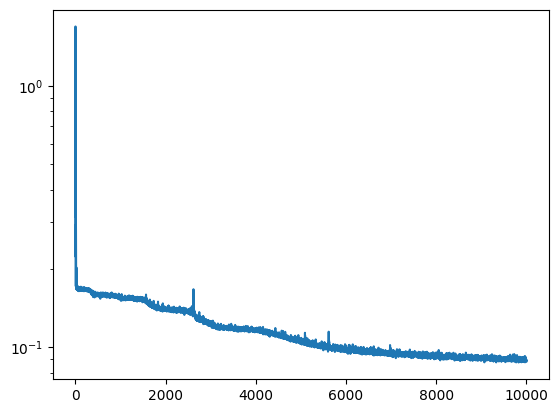

  3%|▎         | 10114/300000 [02:03<53:51, 89.70it/s]

<bound method _item of Array(0.09030455, dtype=float32)>


  3%|▎         | 10215/300000 [02:04<49:37, 97.31it/s]

<bound method _item of Array(0.09092204, dtype=float32)>


  3%|▎         | 10317/300000 [02:06<49:35, 97.35it/s]

<bound method _item of Array(0.08964048, dtype=float32)>


  3%|▎         | 10417/300000 [02:07<51:11, 94.27it/s]

<bound method _item of Array(0.08992483, dtype=float32)>


  4%|▎         | 10517/300000 [02:08<50:07, 96.26it/s]

<bound method _item of Array(0.09036074, dtype=float32)>


  4%|▎         | 10617/300000 [02:09<51:49, 93.06it/s]

<bound method _item of Array(0.08940537, dtype=float32)>


  4%|▎         | 10717/300000 [02:10<50:58, 94.58it/s]

<bound method _item of Array(0.09007642, dtype=float32)>


  4%|▎         | 10818/300000 [02:11<50:12, 96.01it/s]

<bound method _item of Array(0.08771132, dtype=float32)>


  4%|▎         | 10910/300000 [02:12<51:00, 94.45it/s]

<bound method _item of Array(0.08788852, dtype=float32)>


  4%|▎         | 11020/300000 [02:13<50:14, 95.87it/s]

<bound method _item of Array(0.08953911, dtype=float32)>


  4%|▎         | 11120/300000 [02:14<51:06, 94.20it/s]

<bound method _item of Array(0.08967638, dtype=float32)>


  4%|▎         | 11220/300000 [02:15<49:15, 97.71it/s]

<bound method _item of Array(0.08839761, dtype=float32)>


  4%|▍         | 11313/300000 [02:16<48:54, 98.37it/s]

<bound method _item of Array(0.08737116, dtype=float32)>


  4%|▍         | 11413/300000 [02:17<50:28, 95.29it/s]

<bound method _item of Array(0.08864071, dtype=float32)>


  4%|▍         | 11516/300000 [02:18<50:29, 95.24it/s]

<bound method _item of Array(0.08763108, dtype=float32)>


  4%|▍         | 11616/300000 [02:19<50:50, 94.52it/s]

<bound method _item of Array(0.08667965, dtype=float32)>


  4%|▍         | 11716/300000 [02:20<50:07, 95.84it/s]

<bound method _item of Array(0.0869159, dtype=float32)>


  4%|▍         | 11816/300000 [02:21<50:21, 95.37it/s]

<bound method _item of Array(0.0888125, dtype=float32)>


  4%|▍         | 11917/300000 [02:22<53:32, 89.68it/s]

<bound method _item of Array(0.08822203, dtype=float32)>


  4%|▍         | 12017/300000 [02:23<51:11, 93.76it/s]

<bound method _item of Array(0.08819337, dtype=float32)>


  4%|▍         | 12119/300000 [02:24<49:04, 97.76it/s]

<bound method _item of Array(0.08810256, dtype=float32)>


  4%|▍         | 12220/300000 [02:26<48:56, 97.99it/s]

<bound method _item of Array(0.0881075, dtype=float32)>


  4%|▍         | 12320/300000 [02:27<49:51, 96.17it/s]

<bound method _item of Array(0.08711927, dtype=float32)>


  4%|▍         | 12412/300000 [02:28<50:16, 95.33it/s]

<bound method _item of Array(0.08749954, dtype=float32)>


  4%|▍         | 12513/300000 [02:29<50:51, 94.20it/s]

<bound method _item of Array(0.08892319, dtype=float32)>


  4%|▍         | 12613/300000 [02:30<51:21, 93.25it/s]

<bound method _item of Array(0.08824985, dtype=float32)>


  4%|▍         | 12713/300000 [02:31<51:07, 93.66it/s]

<bound method _item of Array(0.08706342, dtype=float32)>


  4%|▍         | 12813/300000 [02:32<53:26, 89.57it/s]

<bound method _item of Array(0.08734506, dtype=float32)>


  4%|▍         | 12913/300000 [02:33<50:09, 95.39it/s]

<bound method _item of Array(0.08922265, dtype=float32)>


  4%|▍         | 13013/300000 [02:34<49:18, 96.99it/s]

<bound method _item of Array(0.08887496, dtype=float32)>


  4%|▍         | 13117/300000 [02:35<48:25, 98.73it/s]

<bound method _item of Array(0.08754685, dtype=float32)>


  4%|▍         | 13221/300000 [02:36<47:54, 99.76it/s]

<bound method _item of Array(0.08733872, dtype=float32)>


  4%|▍         | 13315/300000 [02:37<49:33, 96.41it/s]

<bound method _item of Array(0.08677886, dtype=float32)>


  4%|▍         | 13420/300000 [02:38<47:59, 99.53it/s]

<bound method _item of Array(0.08859861, dtype=float32)>


  5%|▍         | 13512/300000 [02:39<48:01, 99.42it/s]

<bound method _item of Array(0.08635414, dtype=float32)>


  5%|▍         | 13614/300000 [02:40<48:14, 98.95it/s]

<bound method _item of Array(0.08810591, dtype=float32)>


  5%|▍         | 13715/300000 [02:41<48:32, 98.30it/s]

<bound method _item of Array(0.08694947, dtype=float32)>


  5%|▍         | 13815/300000 [02:42<50:53, 93.72it/s]

<bound method _item of Array(0.08787961, dtype=float32)>


  5%|▍         | 13915/300000 [02:43<50:58, 93.53it/s]

<bound method _item of Array(0.08659161, dtype=float32)>


  5%|▍         | 14015/300000 [02:44<50:01, 95.27it/s]

<bound method _item of Array(0.08766793, dtype=float32)>


  5%|▍         | 14115/300000 [02:45<51:01, 93.39it/s]

<bound method _item of Array(0.08683548, dtype=float32)>


  5%|▍         | 14215/300000 [02:46<49:35, 96.05it/s]

<bound method _item of Array(0.08545822, dtype=float32)>


  5%|▍         | 14315/300000 [02:47<50:38, 94.01it/s]

<bound method _item of Array(0.08732133, dtype=float32)>


  5%|▍         | 14415/300000 [02:48<50:00, 95.17it/s]

<bound method _item of Array(0.08607098, dtype=float32)>


  5%|▍         | 14515/300000 [02:50<50:45, 93.75it/s]

<bound method _item of Array(0.0869762, dtype=float32)>


  5%|▍         | 14615/300000 [02:51<49:18, 96.48it/s]

<bound method _item of Array(0.08592986, dtype=float32)>


  5%|▍         | 14715/300000 [02:52<49:52, 95.33it/s]

<bound method _item of Array(0.08713928, dtype=float32)>


  5%|▍         | 14815/300000 [02:53<50:00, 95.05it/s]

<bound method _item of Array(0.08718324, dtype=float32)>


  5%|▍         | 14915/300000 [02:54<50:52, 93.38it/s]

<bound method _item of Array(0.08523068, dtype=float32)>


  5%|▌         | 15015/300000 [02:55<50:41, 93.70it/s]

<bound method _item of Array(0.08626992, dtype=float32)>


  5%|▌         | 15115/300000 [02:56<50:40, 93.71it/s]

<bound method _item of Array(0.08766419, dtype=float32)>


  5%|▌         | 15215/300000 [02:57<54:51, 86.53it/s]

<bound method _item of Array(0.08668706, dtype=float32)>


  5%|▌         | 15315/300000 [02:58<49:56, 94.99it/s]

<bound method _item of Array(0.08679318, dtype=float32)>


  5%|▌         | 15415/300000 [02:59<49:32, 95.74it/s]

<bound method _item of Array(0.08547609, dtype=float32)>


  5%|▌         | 15515/300000 [03:00<50:12, 94.45it/s]

<bound method _item of Array(0.08743052, dtype=float32)>


  5%|▌         | 15615/300000 [03:01<49:29, 95.76it/s]

<bound method _item of Array(0.08523855, dtype=float32)>


  5%|▌         | 15714/300000 [03:02<51:04, 92.76it/s]

<bound method _item of Array(0.08524754, dtype=float32)>


  5%|▌         | 15814/300000 [03:03<50:00, 94.70it/s]

<bound method _item of Array(0.08601142, dtype=float32)>


  5%|▌         | 15914/300000 [03:04<49:25, 95.80it/s]

<bound method _item of Array(0.08610563, dtype=float32)>


  5%|▌         | 16014/300000 [03:05<51:42, 91.54it/s]

<bound method _item of Array(0.08538319, dtype=float32)>


  5%|▌         | 16114/300000 [03:07<52:23, 90.30it/s]

<bound method _item of Array(0.08568421, dtype=float32)>


  5%|▌         | 16214/300000 [03:08<51:08, 92.49it/s]

<bound method _item of Array(0.08506957, dtype=float32)>


  5%|▌         | 16314/300000 [03:09<50:47, 93.09it/s]

<bound method _item of Array(0.08558988, dtype=float32)>


  5%|▌         | 16412/300000 [03:10<52:48, 89.51it/s]

<bound method _item of Array(0.08550383, dtype=float32)>


  6%|▌         | 16517/300000 [03:11<51:17, 92.12it/s]

<bound method _item of Array(0.08763999, dtype=float32)>


  6%|▌         | 16617/300000 [03:12<51:58, 90.87it/s]

<bound method _item of Array(0.08606737, dtype=float32)>


  6%|▌         | 16717/300000 [03:13<50:34, 93.36it/s]

<bound method _item of Array(0.08573999, dtype=float32)>


  6%|▌         | 16817/300000 [03:14<49:48, 94.77it/s]

<bound method _item of Array(0.08525357, dtype=float32)>


  6%|▌         | 16919/300000 [03:15<49:11, 95.91it/s]

<bound method _item of Array(0.08631349, dtype=float32)>


  6%|▌         | 17019/300000 [03:16<49:36, 95.09it/s]

<bound method _item of Array(0.08410304, dtype=float32)>


  6%|▌         | 17119/300000 [03:17<50:42, 92.97it/s]

<bound method _item of Array(0.08673804, dtype=float32)>


  6%|▌         | 17219/300000 [03:18<50:06, 94.05it/s]

<bound method _item of Array(0.08471084, dtype=float32)>


  6%|▌         | 17319/300000 [03:20<50:40, 92.96it/s]

<bound method _item of Array(0.08387474, dtype=float32)>


  6%|▌         | 17419/300000 [03:21<50:15, 93.70it/s]

<bound method _item of Array(0.0859344, dtype=float32)>


  6%|▌         | 17511/300000 [03:22<48:15, 97.55it/s]

<bound method _item of Array(0.08389411, dtype=float32)>


  6%|▌         | 17611/300000 [03:23<48:41, 96.65it/s]

<bound method _item of Array(0.0836503, dtype=float32)>


  6%|▌         | 17712/300000 [03:24<48:51, 96.30it/s]

<bound method _item of Array(0.08502513, dtype=float32)>


  6%|▌         | 17812/300000 [03:25<50:02, 93.99it/s]

<bound method _item of Array(0.08392632, dtype=float32)>


  6%|▌         | 17912/300000 [03:26<49:32, 94.90it/s]

<bound method _item of Array(0.08646134, dtype=float32)>


  6%|▌         | 18012/300000 [03:27<51:04, 92.03it/s]

<bound method _item of Array(0.08468385, dtype=float32)>


  6%|▌         | 18112/300000 [03:28<50:32, 92.96it/s]

<bound method _item of Array(0.08520143, dtype=float32)>


  6%|▌         | 18212/300000 [03:29<49:17, 95.26it/s]

<bound method _item of Array(0.08540038, dtype=float32)>


  6%|▌         | 18312/300000 [03:30<51:37, 90.95it/s]

<bound method _item of Array(0.08446924, dtype=float32)>


  6%|▌         | 18412/300000 [03:31<51:08, 91.77it/s]

<bound method _item of Array(0.0835565, dtype=float32)>


  6%|▌         | 18512/300000 [03:32<50:29, 92.90it/s]

<bound method _item of Array(0.08522446, dtype=float32)>


  6%|▌         | 18612/300000 [03:33<48:43, 96.24it/s]

<bound method _item of Array(0.08476705, dtype=float32)>


  6%|▌         | 18713/300000 [03:34<49:23, 94.91it/s]

<bound method _item of Array(0.08401655, dtype=float32)>


  6%|▋         | 18813/300000 [03:35<50:12, 93.33it/s]

<bound method _item of Array(0.08514464, dtype=float32)>


  6%|▋         | 18914/300000 [03:36<49:22, 94.88it/s]

<bound method _item of Array(0.08466811, dtype=float32)>


  6%|▋         | 19014/300000 [03:38<48:38, 96.26it/s]

<bound method _item of Array(0.08426305, dtype=float32)>


  6%|▋         | 19114/300000 [03:39<50:18, 93.05it/s]

<bound method _item of Array(0.08424514, dtype=float32)>


  6%|▋         | 19215/300000 [03:40<48:36, 96.27it/s]

<bound method _item of Array(0.08490548, dtype=float32)>


  6%|▋         | 19315/300000 [03:41<49:56, 93.68it/s]

<bound method _item of Array(0.08372701, dtype=float32)>


  6%|▋         | 19415/300000 [03:42<50:01, 93.50it/s]

<bound method _item of Array(0.08500519, dtype=float32)>


  7%|▋         | 19515/300000 [03:43<51:12, 91.28it/s]

<bound method _item of Array(0.08183296, dtype=float32)>


  7%|▋         | 19615/300000 [03:44<50:31, 92.49it/s]

<bound method _item of Array(0.08412815, dtype=float32)>


  7%|▋         | 19715/300000 [03:45<49:45, 93.88it/s]

<bound method _item of Array(0.08629549, dtype=float32)>


  7%|▋         | 19815/300000 [03:46<49:13, 94.87it/s]

<bound method _item of Array(0.08482633, dtype=float32)>


  7%|▋         | 19915/300000 [03:47<49:36, 94.09it/s]

<bound method _item of Array(0.08216702, dtype=float32)>


  7%|▋         | 19995/300000 [03:48<50:10, 93.02it/s]

<bound method _item of Array(0.08470802, dtype=float32)>


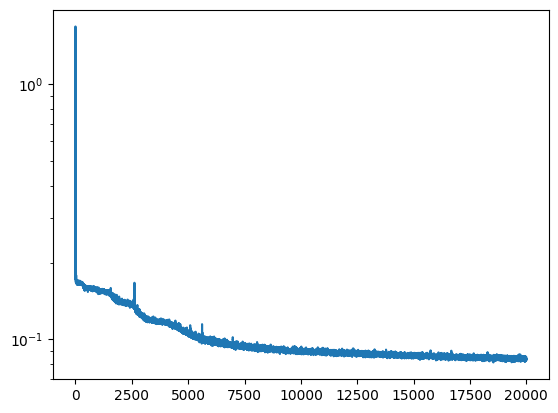

  7%|▋         | 20113/300000 [03:50<51:03, 91.36it/s]

<bound method _item of Array(0.08424374, dtype=float32)>


  7%|▋         | 20213/300000 [03:51<50:31, 92.28it/s]

<bound method _item of Array(0.08338383, dtype=float32)>


  7%|▋         | 20312/300000 [03:52<52:06, 89.46it/s]

<bound method _item of Array(0.0849361, dtype=float32)>


  7%|▋         | 20414/300000 [03:53<52:40, 88.45it/s]

<bound method _item of Array(0.0840068, dtype=float32)>


  7%|▋         | 20515/300000 [03:54<53:12, 87.54it/s]

<bound method _item of Array(0.08428483, dtype=float32)>


  7%|▋         | 20611/300000 [03:55<51:21, 90.66it/s]

<bound method _item of Array(0.08381995, dtype=float32)>


  7%|▋         | 20719/300000 [03:56<51:14, 90.83it/s]

<bound method _item of Array(0.08289763, dtype=float32)>


  7%|▋         | 20819/300000 [03:57<50:10, 92.74it/s]

<bound method _item of Array(0.08246318, dtype=float32)>


  7%|▋         | 20919/300000 [03:58<49:23, 94.16it/s]

<bound method _item of Array(0.08308441, dtype=float32)>


  7%|▋         | 21009/300000 [03:59<50:26, 92.18it/s]

<bound method _item of Array(0.08327003, dtype=float32)>


  7%|▋         | 21119/300000 [04:01<49:09, 94.56it/s]

<bound method _item of Array(0.0841025, dtype=float32)>


  7%|▋         | 21219/300000 [04:02<49:14, 94.36it/s]

<bound method _item of Array(0.08416391, dtype=float32)>


  7%|▋         | 21319/300000 [04:03<50:26, 92.07it/s]

<bound method _item of Array(0.08298536, dtype=float32)>


  7%|▋         | 21419/300000 [04:04<50:12, 92.49it/s]

<bound method _item of Array(0.08175842, dtype=float32)>


  7%|▋         | 21518/300000 [04:05<51:55, 89.38it/s]

<bound method _item of Array(0.08457789, dtype=float32)>


  7%|▋         | 21612/300000 [04:06<53:26, 86.83it/s]

<bound method _item of Array(0.08286285, dtype=float32)>


  7%|▋         | 21719/300000 [04:07<51:09, 90.66it/s]

<bound method _item of Array(0.08313351, dtype=float32)>


  7%|▋         | 21819/300000 [04:08<48:45, 95.10it/s]

<bound method _item of Array(0.08338346, dtype=float32)>


  7%|▋         | 21919/300000 [04:09<49:47, 93.07it/s]

<bound method _item of Array(0.08373206, dtype=float32)>


  7%|▋         | 22019/300000 [04:10<49:32, 93.50it/s]

<bound method _item of Array(0.08195485, dtype=float32)>


  7%|▋         | 22119/300000 [04:12<50:34, 91.57it/s]

<bound method _item of Array(0.08264853, dtype=float32)>


  7%|▋         | 22209/300000 [04:12<50:25, 91.81it/s]

<bound method _item of Array(0.0833977, dtype=float32)>


  7%|▋         | 22309/300000 [04:14<50:28, 91.68it/s]

<bound method _item of Array(0.08440356, dtype=float32)>


  7%|▋         | 22418/300000 [04:15<50:52, 90.94it/s]

<bound method _item of Array(0.08263961, dtype=float32)>


  8%|▊         | 22518/300000 [04:16<49:44, 92.98it/s]

<bound method _item of Array(0.08198504, dtype=float32)>


  8%|▊         | 22617/300000 [04:17<53:20, 86.68it/s]

<bound method _item of Array(0.0831178, dtype=float32)>


  8%|▊         | 22717/300000 [04:18<53:02, 87.13it/s]

<bound method _item of Array(0.08369464, dtype=float32)>


  8%|▊         | 22817/300000 [04:19<52:12, 88.50it/s]

<bound method _item of Array(0.0843413, dtype=float32)>


  8%|▊         | 22916/300000 [04:20<48:40, 94.87it/s]

<bound method _item of Array(0.08346167, dtype=float32)>


  8%|▊         | 23016/300000 [04:21<49:39, 92.96it/s]

<bound method _item of Array(0.08338675, dtype=float32)>


  8%|▊         | 23116/300000 [04:22<49:17, 93.61it/s]

<bound method _item of Array(0.08200911, dtype=float32)>


  8%|▊         | 23216/300000 [04:24<49:21, 93.45it/s]

<bound method _item of Array(0.08430404, dtype=float32)>


  8%|▊         | 23315/300000 [04:25<50:50, 90.71it/s]

<bound method _item of Array(0.08342196, dtype=float32)>


  8%|▊         | 23415/300000 [04:26<48:25, 95.18it/s]

<bound method _item of Array(0.08337246, dtype=float32)>


  8%|▊         | 23515/300000 [04:27<48:44, 94.53it/s]

<bound method _item of Array(0.08207528, dtype=float32)>


  8%|▊         | 23615/300000 [04:28<48:57, 94.09it/s]

<bound method _item of Array(0.08376331, dtype=float32)>


  8%|▊         | 23712/300000 [04:29<52:05, 88.39it/s]

<bound method _item of Array(0.08388986, dtype=float32)>


  8%|▊         | 23814/300000 [04:30<51:05, 90.08it/s]

<bound method _item of Array(0.08346175, dtype=float32)>


  8%|▊         | 23912/300000 [04:31<53:35, 85.85it/s]

<bound method _item of Array(0.08129819, dtype=float32)>


  8%|▊         | 24012/300000 [04:32<49:34, 92.79it/s]

<bound method _item of Array(0.0832451, dtype=float32)>


  8%|▊         | 24112/300000 [04:33<49:37, 92.66it/s]

<bound method _item of Array(0.08303412, dtype=float32)>


  8%|▊         | 24212/300000 [04:34<49:14, 93.35it/s]

<bound method _item of Array(0.08412962, dtype=float32)>


  8%|▊         | 24312/300000 [04:35<49:01, 93.72it/s]

<bound method _item of Array(0.08380692, dtype=float32)>


  8%|▊         | 24412/300000 [04:37<48:38, 94.44it/s]

<bound method _item of Array(0.08309972, dtype=float32)>


  8%|▊         | 24512/300000 [04:38<51:48, 88.64it/s]

<bound method _item of Array(0.08279416, dtype=float32)>


  8%|▊         | 24612/300000 [04:39<48:56, 93.78it/s]

<bound method _item of Array(0.08273754, dtype=float32)>


  8%|▊         | 24712/300000 [04:40<49:48, 92.13it/s]

<bound method _item of Array(0.08228978, dtype=float32)>


  8%|▊         | 24818/300000 [04:41<51:43, 88.67it/s]

<bound method _item of Array(0.08305655, dtype=float32)>


  8%|▊         | 24918/300000 [04:42<52:40, 87.02it/s]

<bound method _item of Array(0.08287856, dtype=float32)>


  8%|▊         | 25017/300000 [04:43<52:32, 87.23it/s]

<bound method _item of Array(0.08329663, dtype=float32)>


  8%|▊         | 25115/300000 [04:44<48:50, 93.79it/s]

<bound method _item of Array(0.08322205, dtype=float32)>


  8%|▊         | 25215/300000 [04:45<49:04, 93.32it/s]

<bound method _item of Array(0.08207735, dtype=float32)>


  8%|▊         | 25315/300000 [04:46<49:05, 93.27it/s]

<bound method _item of Array(0.08117417, dtype=float32)>


  8%|▊         | 25415/300000 [04:47<48:55, 93.53it/s]

<bound method _item of Array(0.08530977, dtype=float32)>


  9%|▊         | 25515/300000 [04:49<48:40, 94.00it/s]

<bound method _item of Array(0.08237502, dtype=float32)>


  9%|▊         | 25615/300000 [04:50<49:03, 93.22it/s]

<bound method _item of Array(0.0828704, dtype=float32)>


  9%|▊         | 25715/300000 [04:51<49:17, 92.75it/s]

<bound method _item of Array(0.08173274, dtype=float32)>


  9%|▊         | 25815/300000 [04:52<51:02, 89.54it/s]

<bound method _item of Array(0.08127064, dtype=float32)>


  9%|▊         | 25915/300000 [04:53<52:01, 87.81it/s]

<bound method _item of Array(0.08352251, dtype=float32)>


  9%|▊         | 26010/300000 [04:54<50:26, 90.52it/s]

<bound method _item of Array(0.08303979, dtype=float32)>


  9%|▊         | 26111/300000 [04:55<52:11, 87.46it/s]

<bound method _item of Array(0.08370972, dtype=float32)>


  9%|▊         | 26211/300000 [04:56<48:19, 94.43it/s]

<bound method _item of Array(0.08268943, dtype=float32)>


  9%|▉         | 26310/300000 [04:57<53:03, 85.98it/s]

<bound method _item of Array(0.08051686, dtype=float32)>


  9%|▉         | 26416/300000 [04:58<51:39, 88.27it/s]

<bound method _item of Array(0.08319213, dtype=float32)>


  9%|▉         | 26512/300000 [05:00<51:17, 88.88it/s]

<bound method _item of Array(0.08249561, dtype=float32)>


  9%|▉         | 26617/300000 [05:01<51:14, 88.91it/s]

<bound method _item of Array(0.08271576, dtype=float32)>


  9%|▉         | 26711/300000 [05:02<50:48, 89.66it/s]

<bound method _item of Array(0.08313205, dtype=float32)>


  9%|▉         | 26818/300000 [05:03<50:39, 89.89it/s]

<bound method _item of Array(0.08152241, dtype=float32)>


  9%|▉         | 26910/300000 [05:04<53:33, 84.97it/s]

<bound method _item of Array(0.08161408, dtype=float32)>


  9%|▉         | 27018/300000 [05:05<53:10, 85.57it/s]

<bound method _item of Array(0.08480033, dtype=float32)>


  9%|▉         | 27117/300000 [05:06<51:45, 87.88it/s]

<bound method _item of Array(0.08215588, dtype=float32)>


  9%|▉         | 27212/300000 [05:08<51:34, 88.16it/s]

<bound method _item of Array(0.08366536, dtype=float32)>


  9%|▉         | 27319/300000 [05:09<50:06, 90.70it/s]

<bound method _item of Array(0.08415315, dtype=float32)>


  9%|▉         | 27419/300000 [05:10<50:26, 90.07it/s]

<bound method _item of Array(0.08239946, dtype=float32)>


  9%|▉         | 27516/300000 [05:11<51:02, 88.98it/s]

<bound method _item of Array(0.08158963, dtype=float32)>


  9%|▉         | 27610/300000 [05:12<55:20, 82.03it/s]

<bound method _item of Array(0.0826465, dtype=float32)>


  9%|▉         | 27710/300000 [05:13<51:07, 88.76it/s]

<bound method _item of Array(0.08242348, dtype=float32)>


  9%|▉         | 27810/300000 [05:14<51:19, 88.38it/s]

<bound method _item of Array(0.08247116, dtype=float32)>


  9%|▉         | 27915/300000 [05:15<50:52, 89.13it/s]

<bound method _item of Array(0.08260488, dtype=float32)>


  9%|▉         | 28016/300000 [05:17<52:09, 86.91it/s]

<bound method _item of Array(0.08169215, dtype=float32)>


  9%|▉         | 28115/300000 [05:18<51:50, 87.42it/s]

<bound method _item of Array(0.08155055, dtype=float32)>


  9%|▉         | 28215/300000 [05:19<50:41, 89.35it/s]

<bound method _item of Array(0.08049991, dtype=float32)>


  9%|▉         | 28310/300000 [05:20<50:43, 89.27it/s]

<bound method _item of Array(0.08098393, dtype=float32)>


  9%|▉         | 28417/300000 [05:21<50:45, 89.17it/s]

<bound method _item of Array(0.08136414, dtype=float32)>


 10%|▉         | 28513/300000 [05:22<51:07, 88.52it/s]

<bound method _item of Array(0.08297946, dtype=float32)>


 10%|▉         | 28611/300000 [05:23<50:07, 90.23it/s]

<bound method _item of Array(0.08087, dtype=float32)>


 10%|▉         | 28714/300000 [05:24<49:57, 90.50it/s]

<bound method _item of Array(0.08258256, dtype=float32)>


 10%|▉         | 28814/300000 [05:25<49:27, 91.38it/s]

<bound method _item of Array(0.08256777, dtype=float32)>


 10%|▉         | 28914/300000 [05:27<50:09, 90.08it/s]

<bound method _item of Array(0.08222467, dtype=float32)>


 10%|▉         | 29015/300000 [05:28<51:56, 86.95it/s]

<bound method _item of Array(0.08297446, dtype=float32)>


 10%|▉         | 29114/300000 [05:29<51:10, 88.21it/s]

<bound method _item of Array(0.08293141, dtype=float32)>


 10%|▉         | 29213/300000 [05:30<51:36, 87.44it/s]

<bound method _item of Array(0.08156016, dtype=float32)>


 10%|▉         | 29312/300000 [05:31<49:00, 92.05it/s]

<bound method _item of Array(0.08346336, dtype=float32)>


 10%|▉         | 29412/300000 [05:32<49:28, 91.14it/s]

<bound method _item of Array(0.0811539, dtype=float32)>


 10%|▉         | 29512/300000 [05:33<49:49, 90.48it/s]

<bound method _item of Array(0.08167751, dtype=float32)>


 10%|▉         | 29610/300000 [05:34<50:34, 89.10it/s]

<bound method _item of Array(0.08313002, dtype=float32)>


 10%|▉         | 29718/300000 [05:36<49:55, 90.23it/s]

<bound method _item of Array(0.08191483, dtype=float32)>


 10%|▉         | 29818/300000 [05:37<49:45, 90.51it/s]

<bound method _item of Array(0.08234805, dtype=float32)>


 10%|▉         | 29915/300000 [05:38<49:32, 90.87it/s]

<bound method _item of Array(0.08201411, dtype=float32)>


 10%|▉         | 29995/300000 [05:39<49:49, 90.32it/s]

<bound method _item of Array(0.08229406, dtype=float32)>


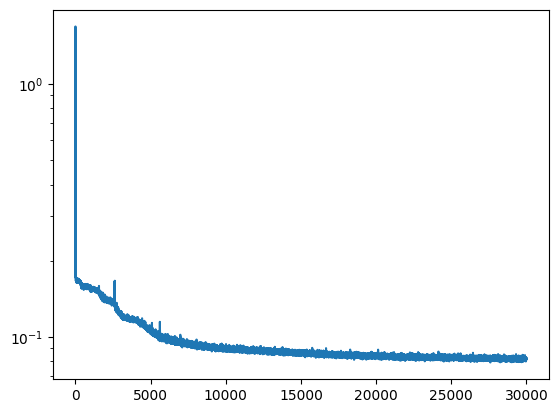

 10%|█         | 30115/300000 [05:40<53:41, 83.77it/s]

<bound method _item of Array(0.08223218, dtype=float32)>


 10%|█         | 30214/300000 [05:41<53:15, 84.44it/s]

<bound method _item of Array(0.08168335, dtype=float32)>


 10%|█         | 30313/300000 [05:43<52:30, 85.60it/s]

<bound method _item of Array(0.08239982, dtype=float32)>


 10%|█         | 30412/300000 [05:44<52:23, 85.75it/s]

<bound method _item of Array(0.08315194, dtype=float32)>


 10%|█         | 30517/300000 [05:45<50:02, 89.74it/s]

<bound method _item of Array(0.08298635, dtype=float32)>


 10%|█         | 30616/300000 [05:46<48:57, 91.70it/s]

<bound method _item of Array(0.08189443, dtype=float32)>


 10%|█         | 30716/300000 [05:47<50:00, 89.73it/s]

<bound method _item of Array(0.08165506, dtype=float32)>


 10%|█         | 30816/300000 [05:48<49:16, 91.06it/s]

<bound method _item of Array(0.0806154, dtype=float32)>


 10%|█         | 30913/300000 [05:49<49:36, 90.39it/s]

<bound method _item of Array(0.08013569, dtype=float32)>


 10%|█         | 31010/300000 [05:50<50:03, 89.55it/s]

<bound method _item of Array(0.08212131, dtype=float32)>


 10%|█         | 31118/300000 [05:52<52:09, 85.92it/s]

<bound method _item of Array(0.08202869, dtype=float32)>


 10%|█         | 31218/300000 [05:53<51:14, 87.43it/s]

<bound method _item of Array(0.08261824, dtype=float32)>


 10%|█         | 31317/300000 [05:54<51:29, 86.97it/s]

<bound method _item of Array(0.08214424, dtype=float32)>


 10%|█         | 31410/300000 [05:55<49:49, 89.86it/s]

<bound method _item of Array(0.08318681, dtype=float32)>


 11%|█         | 31519/300000 [05:56<48:51, 91.57it/s]

<bound method _item of Array(0.08080091, dtype=float32)>


 11%|█         | 31618/300000 [05:57<50:02, 89.39it/s]

<bound method _item of Array(0.08040487, dtype=float32)>


 11%|█         | 31712/300000 [05:58<49:56, 89.53it/s]

<bound method _item of Array(0.08261705, dtype=float32)>


 11%|█         | 31811/300000 [05:59<49:57, 89.46it/s]

<bound method _item of Array(0.08014123, dtype=float32)>


 11%|█         | 31918/300000 [06:01<49:18, 90.60it/s]

<bound method _item of Array(0.08086256, dtype=float32)>


 11%|█         | 32018/300000 [06:02<49:34, 90.11it/s]

<bound method _item of Array(0.08095746, dtype=float32)>


 11%|█         | 32115/300000 [06:03<50:24, 88.58it/s]

<bound method _item of Array(0.08119083, dtype=float32)>


 11%|█         | 32214/300000 [06:04<50:56, 87.62it/s]

<bound method _item of Array(0.08132815, dtype=float32)>


 11%|█         | 32317/300000 [06:05<50:37, 88.11it/s]

<bound method _item of Array(0.08337051, dtype=float32)>


 11%|█         | 32414/300000 [06:06<48:16, 92.39it/s]

<bound method _item of Array(0.08027714, dtype=float32)>


 11%|█         | 32513/300000 [06:07<49:28, 90.10it/s]

<bound method _item of Array(0.08116345, dtype=float32)>


 11%|█         | 32613/300000 [06:08<48:47, 91.35it/s]

<bound method _item of Array(0.08141863, dtype=float32)>


 11%|█         | 32713/300000 [06:09<48:23, 92.07it/s]

<bound method _item of Array(0.08130401, dtype=float32)>


 11%|█         | 32813/300000 [06:10<47:43, 93.31it/s]

<bound method _item of Array(0.08304428, dtype=float32)>


 11%|█         | 32913/300000 [06:12<49:29, 89.94it/s]

<bound method _item of Array(0.08062878, dtype=float32)>


 11%|█         | 33015/300000 [06:13<50:42, 87.74it/s]

<bound method _item of Array(0.08250587, dtype=float32)>


 11%|█         | 33115/300000 [06:14<50:20, 88.36it/s]

<bound method _item of Array(0.08227215, dtype=float32)>


 11%|█         | 33215/300000 [06:15<50:57, 87.24it/s]

<bound method _item of Array(0.08202522, dtype=float32)>


 11%|█         | 33314/300000 [06:16<53:17, 83.41it/s]

<bound method _item of Array(0.08299617, dtype=float32)>


 11%|█         | 33413/300000 [06:17<51:40, 85.99it/s]

<bound method _item of Array(0.08203024, dtype=float32)>


 11%|█         | 33513/300000 [06:18<50:32, 87.86it/s]

<bound method _item of Array(0.08216249, dtype=float32)>


 11%|█         | 33616/300000 [06:20<50:24, 88.08it/s]

<bound method _item of Array(0.08278278, dtype=float32)>


 11%|█         | 33716/300000 [06:21<48:32, 91.44it/s]

<bound method _item of Array(0.08179235, dtype=float32)>


 11%|█▏        | 33814/300000 [06:22<49:59, 88.74it/s]

<bound method _item of Array(0.08037985, dtype=float32)>


 11%|█▏        | 33919/300000 [06:23<48:49, 90.84it/s]

<bound method _item of Array(0.08165834, dtype=float32)>


 11%|█▏        | 34018/300000 [06:24<48:34, 91.26it/s]

<bound method _item of Array(0.08086345, dtype=float32)>


 11%|█▏        | 34117/300000 [06:25<51:27, 86.11it/s]

<bound method _item of Array(0.08101464, dtype=float32)>


 11%|█▏        | 34216/300000 [06:26<50:23, 87.90it/s]

<bound method _item of Array(0.07988403, dtype=float32)>


 11%|█▏        | 34315/300000 [06:28<51:12, 86.48it/s]

<bound method _item of Array(0.08097229, dtype=float32)>


 11%|█▏        | 34414/300000 [06:29<51:59, 85.13it/s]

<bound method _item of Array(0.08064245, dtype=float32)>


 12%|█▏        | 34514/300000 [06:30<49:43, 88.99it/s]

<bound method _item of Array(0.08169837, dtype=float32)>


 12%|█▏        | 34610/300000 [06:31<49:03, 90.16it/s]

<bound method _item of Array(0.08107552, dtype=float32)>


 12%|█▏        | 34713/300000 [06:32<51:35, 85.69it/s]

<bound method _item of Array(0.08181354, dtype=float32)>


 12%|█▏        | 34812/300000 [06:33<50:55, 86.79it/s]

<bound method _item of Array(0.08200637, dtype=float32)>


 12%|█▏        | 34913/300000 [06:34<49:46, 88.75it/s]

<bound method _item of Array(0.08060662, dtype=float32)>


 12%|█▏        | 35012/300000 [06:35<49:49, 88.63it/s]

<bound method _item of Array(0.08120283, dtype=float32)>


 12%|█▏        | 35112/300000 [06:37<48:20, 91.31it/s]

<bound method _item of Array(0.08240386, dtype=float32)>


 12%|█▏        | 35209/300000 [06:38<48:56, 90.17it/s]

<bound method _item of Array(0.08145951, dtype=float32)>


 12%|█▏        | 35313/300000 [06:39<50:13, 87.82it/s]

<bound method _item of Array(0.08074378, dtype=float32)>


 12%|█▏        | 35412/300000 [06:40<50:51, 86.71it/s]

<bound method _item of Array(0.08043567, dtype=float32)>


 12%|█▏        | 35512/300000 [06:41<50:15, 87.70it/s]

<bound method _item of Array(0.08098896, dtype=float32)>


 12%|█▏        | 35616/300000 [06:42<50:38, 87.02it/s]

<bound method _item of Array(0.08133134, dtype=float32)>


 12%|█▏        | 35715/300000 [06:43<50:32, 87.14it/s]

<bound method _item of Array(0.0802657, dtype=float32)>


 12%|█▏        | 35815/300000 [06:45<49:48, 88.39it/s]

<bound method _item of Array(0.08192565, dtype=float32)>


 12%|█▏        | 35914/300000 [06:46<49:47, 88.40it/s]

<bound method _item of Array(0.08097867, dtype=float32)>


 12%|█▏        | 36015/300000 [06:47<49:41, 88.53it/s]

<bound method _item of Array(0.0820794, dtype=float32)>


 12%|█▏        | 36115/300000 [06:48<49:26, 88.95it/s]

<bound method _item of Array(0.08063612, dtype=float32)>


 12%|█▏        | 36214/300000 [06:49<50:15, 87.49it/s]

<bound method _item of Array(0.08180432, dtype=float32)>


 12%|█▏        | 36313/300000 [06:50<52:09, 84.27it/s]

<bound method _item of Array(0.07996929, dtype=float32)>


 12%|█▏        | 36412/300000 [06:51<51:09, 85.87it/s]

<bound method _item of Array(0.07941782, dtype=float32)>


 12%|█▏        | 36511/300000 [06:53<50:50, 86.38it/s]

<bound method _item of Array(0.08158115, dtype=float32)>


 12%|█▏        | 36610/300000 [06:54<50:54, 86.22it/s]

<bound method _item of Array(0.08187277, dtype=float32)>


 12%|█▏        | 36718/300000 [06:55<51:23, 85.39it/s]

<bound method _item of Array(0.08171815, dtype=float32)>


 12%|█▏        | 36817/300000 [06:56<50:26, 86.97it/s]

<bound method _item of Array(0.08039968, dtype=float32)>


 12%|█▏        | 36917/300000 [06:57<50:32, 86.76it/s]

<bound method _item of Array(0.07953442, dtype=float32)>


 12%|█▏        | 37016/300000 [06:58<49:54, 87.84it/s]

<bound method _item of Array(0.07955778, dtype=float32)>


 12%|█▏        | 37119/300000 [06:59<48:58, 89.46it/s]

<bound method _item of Array(0.08187797, dtype=float32)>


 12%|█▏        | 37218/300000 [07:01<49:36, 88.30it/s]

<bound method _item of Array(0.08075115, dtype=float32)>


 12%|█▏        | 37318/300000 [07:02<49:28, 88.50it/s]

<bound method _item of Array(0.08050113, dtype=float32)>


 12%|█▏        | 37417/300000 [07:03<51:29, 85.00it/s]

<bound method _item of Array(0.08083377, dtype=float32)>


 13%|█▎        | 37516/300000 [07:04<52:23, 83.49it/s]

<bound method _item of Array(0.08049794, dtype=float32)>


 13%|█▎        | 37615/300000 [07:05<50:42, 86.23it/s]

<bound method _item of Array(0.08080085, dtype=float32)>


 13%|█▎        | 37714/300000 [07:06<51:23, 85.06it/s]

<bound method _item of Array(0.07820395, dtype=float32)>


 13%|█▎        | 37813/300000 [07:08<50:07, 87.19it/s]

<bound method _item of Array(0.08035738, dtype=float32)>


 13%|█▎        | 37914/300000 [07:09<48:57, 89.22it/s]

<bound method _item of Array(0.08235702, dtype=float32)>


 13%|█▎        | 38014/300000 [07:10<48:55, 89.24it/s]

<bound method _item of Array(0.08051878, dtype=float32)>


 13%|█▎        | 38113/300000 [07:11<50:52, 85.78it/s]

<bound method _item of Array(0.07995633, dtype=float32)>


 13%|█▎        | 38212/300000 [07:12<52:08, 83.68it/s]

<bound method _item of Array(0.07977666, dtype=float32)>


 13%|█▎        | 38311/300000 [07:13<51:04, 85.39it/s]

<bound method _item of Array(0.0804449, dtype=float32)>


 13%|█▎        | 38410/300000 [07:14<51:45, 84.22it/s]

<bound method _item of Array(0.08113124, dtype=float32)>


 13%|█▎        | 38509/300000 [07:16<52:04, 83.68it/s]

<bound method _item of Array(0.08016614, dtype=float32)>


 13%|█▎        | 38617/300000 [07:17<53:30, 81.42it/s]

<bound method _item of Array(0.07982771, dtype=float32)>


 13%|█▎        | 38716/300000 [07:18<51:14, 84.98it/s]

<bound method _item of Array(0.07924574, dtype=float32)>


 13%|█▎        | 38815/300000 [07:19<50:03, 86.97it/s]

<bound method _item of Array(0.08239029, dtype=float32)>


 13%|█▎        | 38914/300000 [07:20<49:37, 87.68it/s]

<bound method _item of Array(0.08037216, dtype=float32)>


 13%|█▎        | 39015/300000 [07:22<48:57, 88.84it/s]

<bound method _item of Array(0.07965958, dtype=float32)>


 13%|█▎        | 39114/300000 [07:23<49:40, 87.53it/s]

<bound method _item of Array(0.08097436, dtype=float32)>


 13%|█▎        | 39213/300000 [07:24<49:58, 86.97it/s]

<bound method _item of Array(0.07922428, dtype=float32)>


 13%|█▎        | 39312/300000 [07:25<51:19, 84.67it/s]

<bound method _item of Array(0.08008348, dtype=float32)>


 13%|█▎        | 39411/300000 [07:26<53:31, 81.14it/s]

<bound method _item of Array(0.08083267, dtype=float32)>


 13%|█▎        | 39510/300000 [07:27<51:46, 83.85it/s]

<bound method _item of Array(0.07938137, dtype=float32)>


 13%|█▎        | 39609/300000 [07:29<51:59, 83.48it/s]

<bound method _item of Array(0.0797124, dtype=float32)>


 13%|█▎        | 39717/300000 [07:30<50:22, 86.11it/s]

<bound method _item of Array(0.08077202, dtype=float32)>


 13%|█▎        | 39816/300000 [07:31<50:24, 86.03it/s]

<bound method _item of Array(0.07912263, dtype=float32)>


 13%|█▎        | 39915/300000 [07:32<51:34, 84.04it/s]

<bound method _item of Array(0.07922564, dtype=float32)>


 13%|█▎        | 39996/300000 [07:33<50:32, 85.75it/s]

<bound method _item of Array(0.08050401, dtype=float32)>


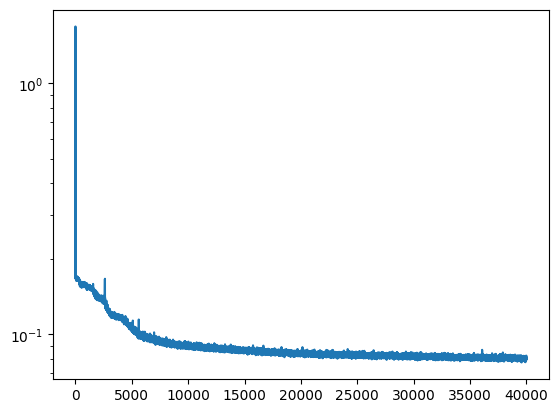

 13%|█▎        | 40113/300000 [07:35<50:04, 86.49it/s]

<bound method _item of Array(0.07893933, dtype=float32)>


 13%|█▎        | 40212/300000 [07:36<49:55, 86.73it/s]

<bound method _item of Array(0.08066133, dtype=float32)>


 13%|█▎        | 40311/300000 [07:37<53:35, 80.76it/s]

<bound method _item of Array(0.08035031, dtype=float32)>


 13%|█▎        | 40410/300000 [07:38<52:36, 82.24it/s]

<bound method _item of Array(0.08078606, dtype=float32)>


 14%|█▎        | 40518/300000 [07:39<51:19, 84.27it/s]

<bound method _item of Array(0.08033521, dtype=float32)>


 14%|█▎        | 40617/300000 [07:41<49:31, 87.30it/s]

<bound method _item of Array(0.07982107, dtype=float32)>


 14%|█▎        | 40716/300000 [07:42<49:26, 87.39it/s]

<bound method _item of Array(0.08067048, dtype=float32)>


 14%|█▎        | 40815/300000 [07:43<49:54, 86.54it/s]

<bound method _item of Array(0.08021428, dtype=float32)>


 14%|█▎        | 40914/300000 [07:44<51:06, 84.50it/s]

<bound method _item of Array(0.0804469, dtype=float32)>


 14%|█▎        | 41013/300000 [07:45<50:05, 86.18it/s]

<bound method _item of Array(0.08130277, dtype=float32)>


 14%|█▎        | 41112/300000 [07:46<50:54, 84.76it/s]

<bound method _item of Array(0.08119074, dtype=float32)>


 14%|█▎        | 41211/300000 [07:48<51:02, 84.51it/s]

<bound method _item of Array(0.0788874, dtype=float32)>


 14%|█▍        | 41310/300000 [07:49<49:39, 86.81it/s]

<bound method _item of Array(0.08056739, dtype=float32)>


 14%|█▍        | 41409/300000 [07:50<52:45, 81.69it/s]

<bound method _item of Array(0.08081196, dtype=float32)>


 14%|█▍        | 41517/300000 [07:51<51:18, 83.96it/s]

<bound method _item of Array(0.0802741, dtype=float32)>


 14%|█▍        | 41616/300000 [07:52<50:39, 85.02it/s]

<bound method _item of Array(0.08012863, dtype=float32)>


 14%|█▍        | 41715/300000 [07:53<49:26, 87.07it/s]

<bound method _item of Array(0.07894716, dtype=float32)>


 14%|█▍        | 41816/300000 [07:55<48:52, 88.03it/s]

<bound method _item of Array(0.07883497, dtype=float32)>


 14%|█▍        | 41915/300000 [07:56<49:31, 86.85it/s]

<bound method _item of Array(0.08175883, dtype=float32)>


 14%|█▍        | 42014/300000 [07:57<51:15, 83.88it/s]

<bound method _item of Array(0.07906386, dtype=float32)>


 14%|█▍        | 42113/300000 [07:58<49:09, 87.42it/s]

<bound method _item of Array(0.07984031, dtype=float32)>


 14%|█▍        | 42213/300000 [07:59<52:18, 82.14it/s]

<bound method _item of Array(0.08027735, dtype=float32)>


 14%|█▍        | 42312/300000 [08:00<51:26, 83.48it/s]

<bound method _item of Array(0.08103728, dtype=float32)>


 14%|█▍        | 42411/300000 [08:02<53:09, 80.75it/s]

<bound method _item of Array(0.0805537, dtype=float32)>


 14%|█▍        | 42517/300000 [08:03<53:29, 80.21it/s]

<bound method _item of Array(0.07935753, dtype=float32)>


 14%|█▍        | 42616/300000 [08:04<50:55, 84.22it/s]

<bound method _item of Array(0.07991501, dtype=float32)>


 14%|█▍        | 42715/300000 [08:05<50:23, 85.10it/s]

<bound method _item of Array(0.08118653, dtype=float32)>


 14%|█▍        | 42815/300000 [08:06<49:02, 87.41it/s]

<bound method _item of Array(0.07990944, dtype=float32)>


 14%|█▍        | 42914/300000 [08:08<49:14, 87.02it/s]

<bound method _item of Array(0.0788236, dtype=float32)>


 14%|█▍        | 43013/300000 [08:09<48:34, 88.18it/s]

<bound method _item of Array(0.07951675, dtype=float32)>


 14%|█▍        | 43113/300000 [08:10<48:37, 88.04it/s]

<bound method _item of Array(0.08015765, dtype=float32)>


 14%|█▍        | 43213/300000 [08:11<48:25, 88.37it/s]

<bound method _item of Array(0.08083995, dtype=float32)>


 14%|█▍        | 43312/300000 [08:12<49:28, 86.46it/s]

<bound method _item of Array(0.07933212, dtype=float32)>


 14%|█▍        | 43411/300000 [08:13<51:11, 83.55it/s]

<bound method _item of Array(0.07971951, dtype=float32)>


 15%|█▍        | 43510/300000 [08:15<51:24, 83.14it/s]

<bound method _item of Array(0.08215451, dtype=float32)>


 15%|█▍        | 43618/300000 [08:16<50:43, 84.24it/s]

<bound method _item of Array(0.0810579, dtype=float32)>


 15%|█▍        | 43717/300000 [08:17<50:28, 84.62it/s]

<bound method _item of Array(0.07994317, dtype=float32)>


 15%|█▍        | 43817/300000 [08:18<49:06, 86.94it/s]

<bound method _item of Array(0.07963849, dtype=float32)>


 15%|█▍        | 43916/300000 [08:19<49:49, 85.66it/s]

<bound method _item of Array(0.0802427, dtype=float32)>


 15%|█▍        | 44015/300000 [08:20<51:00, 83.65it/s]

<bound method _item of Array(0.08111401, dtype=float32)>


 15%|█▍        | 44114/300000 [08:22<51:17, 83.15it/s]

<bound method _item of Array(0.08068008, dtype=float32)>


 15%|█▍        | 44213/300000 [08:23<51:02, 83.53it/s]

<bound method _item of Array(0.08051984, dtype=float32)>


 15%|█▍        | 44312/300000 [08:24<52:09, 81.72it/s]

<bound method _item of Array(0.08123263, dtype=float32)>


 15%|█▍        | 44411/300000 [08:25<54:17, 78.45it/s]

<bound method _item of Array(0.07991076, dtype=float32)>


 15%|█▍        | 44517/300000 [08:27<52:22, 81.30it/s]

<bound method _item of Array(0.07935472, dtype=float32)>


 15%|█▍        | 44616/300000 [08:28<51:06, 83.29it/s]

<bound method _item of Array(0.08022305, dtype=float32)>


 15%|█▍        | 44715/300000 [08:29<50:36, 84.08it/s]

<bound method _item of Array(0.07986694, dtype=float32)>


 15%|█▍        | 44814/300000 [08:30<50:29, 84.22it/s]

<bound method _item of Array(0.08237427, dtype=float32)>


 15%|█▍        | 44913/300000 [08:31<50:14, 84.61it/s]

<bound method _item of Array(0.07928308, dtype=float32)>


 15%|█▌        | 45012/300000 [08:33<50:47, 83.68it/s]

<bound method _item of Array(0.07934834, dtype=float32)>


 15%|█▌        | 45111/300000 [08:34<50:13, 84.58it/s]

<bound method _item of Array(0.07961179, dtype=float32)>


 15%|█▌        | 45210/300000 [08:35<48:52, 86.87it/s]

<bound method _item of Array(0.07901737, dtype=float32)>


 15%|█▌        | 45318/300000 [08:36<49:53, 85.08it/s]

<bound method _item of Array(0.08012263, dtype=float32)>


 15%|█▌        | 45417/300000 [08:37<51:19, 82.67it/s]

<bound method _item of Array(0.07936772, dtype=float32)>


 15%|█▌        | 45516/300000 [08:39<50:47, 83.52it/s]

<bound method _item of Array(0.07960518, dtype=float32)>


 15%|█▌        | 45615/300000 [08:40<50:16, 84.34it/s]

<bound method _item of Array(0.07961882, dtype=float32)>


 15%|█▌        | 45714/300000 [08:41<49:55, 84.88it/s]

<bound method _item of Array(0.08216112, dtype=float32)>


 15%|█▌        | 45813/300000 [08:42<50:39, 83.64it/s]

<bound method _item of Array(0.07985806, dtype=float32)>


 15%|█▌        | 45912/300000 [08:43<49:20, 85.84it/s]

<bound method _item of Array(0.07966577, dtype=float32)>


 15%|█▌        | 46011/300000 [08:44<49:19, 85.81it/s]

<bound method _item of Array(0.08051458, dtype=float32)>


 15%|█▌        | 46110/300000 [08:46<50:26, 83.89it/s]

<bound method _item of Array(0.07987828, dtype=float32)>


 15%|█▌        | 46218/300000 [08:47<48:50, 86.61it/s]

<bound method _item of Array(0.07906429, dtype=float32)>


 15%|█▌        | 46317/300000 [08:48<49:24, 85.57it/s]

<bound method _item of Array(0.08027554, dtype=float32)>


 15%|█▌        | 46416/300000 [08:49<52:09, 81.04it/s]

<bound method _item of Array(0.07913274, dtype=float32)>


 16%|█▌        | 46515/300000 [08:50<51:39, 81.79it/s]

<bound method _item of Array(0.07949946, dtype=float32)>


 16%|█▌        | 46614/300000 [08:52<51:47, 81.53it/s]

<bound method _item of Array(0.0782335, dtype=float32)>


 16%|█▌        | 46713/300000 [08:53<50:48, 83.08it/s]

<bound method _item of Array(0.07921275, dtype=float32)>


 16%|█▌        | 46812/300000 [08:54<50:27, 83.64it/s]

<bound method _item of Array(0.0793212, dtype=float32)>


 16%|█▌        | 46911/300000 [08:55<50:03, 84.28it/s]

<bound method _item of Array(0.08043385, dtype=float32)>


 16%|█▌        | 47010/300000 [08:56<49:52, 84.54it/s]

<bound method _item of Array(0.07966406, dtype=float32)>


 16%|█▌        | 47118/300000 [08:58<49:56, 84.40it/s]

<bound method _item of Array(0.07965842, dtype=float32)>


 16%|█▌        | 47217/300000 [08:59<49:29, 85.13it/s]

<bound method _item of Array(0.07951728, dtype=float32)>


 16%|█▌        | 47316/300000 [09:00<50:24, 83.54it/s]

<bound method _item of Array(0.080143, dtype=float32)>


 16%|█▌        | 47415/300000 [09:01<51:45, 81.34it/s]

<bound method _item of Array(0.07880559, dtype=float32)>


 16%|█▌        | 47514/300000 [09:02<51:16, 82.06it/s]

<bound method _item of Array(0.07915566, dtype=float32)>


 16%|█▌        | 47613/300000 [09:04<49:54, 84.29it/s]

<bound method _item of Array(0.08109812, dtype=float32)>


 16%|█▌        | 47712/300000 [09:05<49:53, 84.28it/s]

<bound method _item of Array(0.08041731, dtype=float32)>


 16%|█▌        | 47811/300000 [09:06<50:05, 83.91it/s]

<bound method _item of Array(0.07946192, dtype=float32)>


 16%|█▌        | 47910/300000 [09:07<50:13, 83.67it/s]

<bound method _item of Array(0.08148947, dtype=float32)>


 16%|█▌        | 48009/300000 [09:08<48:16, 87.00it/s]

<bound method _item of Array(0.08024861, dtype=float32)>


 16%|█▌        | 48117/300000 [09:10<49:42, 84.45it/s]

<bound method _item of Array(0.07983451, dtype=float32)>


 16%|█▌        | 48216/300000 [09:11<48:41, 86.18it/s]

<bound method _item of Array(0.08010006, dtype=float32)>


 16%|█▌        | 48315/300000 [09:12<51:56, 80.75it/s]

<bound method _item of Array(0.07969557, dtype=float32)>


 16%|█▌        | 48409/300000 [09:13<52:19, 80.13it/s]

<bound method _item of Array(0.07988998, dtype=float32)>


 16%|█▌        | 48517/300000 [09:14<51:21, 81.60it/s]

<bound method _item of Array(0.07872898, dtype=float32)>


 16%|█▌        | 48616/300000 [09:16<51:06, 81.97it/s]

<bound method _item of Array(0.07989036, dtype=float32)>


 16%|█▌        | 48715/300000 [09:17<49:10, 85.17it/s]

<bound method _item of Array(0.07955567, dtype=float32)>


 16%|█▋        | 48814/300000 [09:18<49:14, 85.02it/s]

<bound method _item of Array(0.0785298, dtype=float32)>


 16%|█▋        | 48913/300000 [09:19<49:32, 84.47it/s]

<bound method _item of Array(0.07803175, dtype=float32)>


 16%|█▋        | 49012/300000 [09:20<50:05, 83.50it/s]

<bound method _item of Array(0.08039242, dtype=float32)>


 16%|█▋        | 49111/300000 [09:21<50:46, 82.35it/s]

<bound method _item of Array(0.07963147, dtype=float32)>


 16%|█▋        | 49210/300000 [09:23<50:39, 82.52it/s]

<bound method _item of Array(0.07896481, dtype=float32)>


 16%|█▋        | 49309/300000 [09:24<51:58, 80.39it/s]

<bound method _item of Array(0.07922373, dtype=float32)>


 16%|█▋        | 49415/300000 [09:25<51:07, 81.69it/s]

<bound method _item of Array(0.07830082, dtype=float32)>


 17%|█▋        | 49514/300000 [09:26<52:42, 79.21it/s]

<bound method _item of Array(0.07809808, dtype=float32)>


 17%|█▋        | 49611/300000 [09:28<50:46, 82.20it/s]

<bound method _item of Array(0.08039975, dtype=float32)>


 17%|█▋        | 49710/300000 [09:29<50:13, 83.06it/s]

<bound method _item of Array(0.07830168, dtype=float32)>


 17%|█▋        | 49809/300000 [09:30<49:51, 83.64it/s]

<bound method _item of Array(0.08031914, dtype=float32)>


 17%|█▋        | 49917/300000 [09:31<50:12, 83.01it/s]

<bound method _item of Array(0.07893795, dtype=float32)>


 17%|█▋        | 49998/300000 [09:32<50:34, 82.38it/s]

<bound method _item of Array(0.08015699, dtype=float32)>


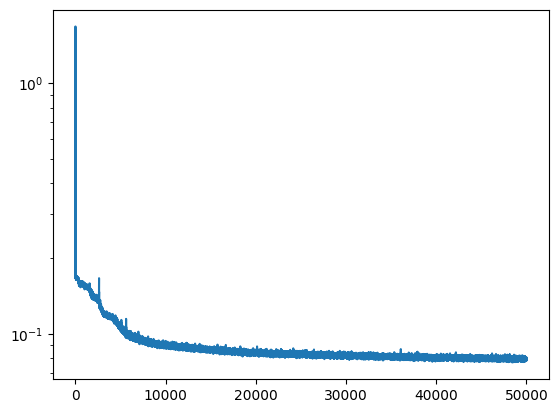

 17%|█▋        | 50115/300000 [09:34<50:16, 82.83it/s]

<bound method _item of Array(0.08012279, dtype=float32)>


 17%|█▋        | 50214/300000 [09:35<49:32, 84.02it/s]

<bound method _item of Array(0.07885558, dtype=float32)>


 17%|█▋        | 50313/300000 [09:36<50:41, 82.08it/s]

<bound method _item of Array(0.07840544, dtype=float32)>


 17%|█▋        | 50412/300000 [09:38<51:41, 80.47it/s]

<bound method _item of Array(0.07921608, dtype=float32)>


 17%|█▋        | 50511/300000 [09:39<50:01, 83.13it/s]

<bound method _item of Array(0.0788849, dtype=float32)>


 17%|█▋        | 50610/300000 [09:40<49:06, 84.65it/s]

<bound method _item of Array(0.0815644, dtype=float32)>


 17%|█▋        | 50718/300000 [09:41<48:49, 85.09it/s]

<bound method _item of Array(0.07928251, dtype=float32)>


 17%|█▋        | 50818/300000 [09:42<48:47, 85.11it/s]

<bound method _item of Array(0.07770343, dtype=float32)>


 17%|█▋        | 50917/300000 [09:44<48:34, 85.47it/s]

<bound method _item of Array(0.07819737, dtype=float32)>


 17%|█▋        | 51016/300000 [09:45<48:22, 85.79it/s]

<bound method _item of Array(0.07898148, dtype=float32)>


 17%|█▋        | 51115/300000 [09:46<49:03, 84.54it/s]

<bound method _item of Array(0.079847, dtype=float32)>


 17%|█▋        | 51214/300000 [09:47<51:41, 80.23it/s]

<bound method _item of Array(0.07882165, dtype=float32)>


 17%|█▋        | 51313/300000 [09:48<51:10, 80.99it/s]

<bound method _item of Array(0.0786267, dtype=float32)>


 17%|█▋        | 51412/300000 [09:49<51:16, 80.81it/s]

<bound method _item of Array(0.07894753, dtype=float32)>


 17%|█▋        | 51511/300000 [09:51<50:12, 82.48it/s]

<bound method _item of Array(0.07935575, dtype=float32)>


 17%|█▋        | 51609/300000 [09:52<51:09, 80.93it/s]

<bound method _item of Array(0.0807003, dtype=float32)>


 17%|█▋        | 51717/300000 [09:53<49:03, 84.34it/s]

<bound method _item of Array(0.0795501, dtype=float32)>


 17%|█▋        | 51816/300000 [09:54<50:21, 82.15it/s]

<bound method _item of Array(0.07861228, dtype=float32)>


 17%|█▋        | 51915/300000 [09:56<48:54, 84.54it/s]

<bound method _item of Array(0.07865871, dtype=float32)>


 17%|█▋        | 52014/300000 [09:57<48:55, 84.48it/s]

<bound method _item of Array(0.0789767, dtype=float32)>


 17%|█▋        | 52113/300000 [09:58<49:41, 83.14it/s]

<bound method _item of Array(0.07854142, dtype=float32)>


 17%|█▋        | 52212/300000 [09:59<50:05, 82.46it/s]

<bound method _item of Array(0.07908919, dtype=float32)>


 17%|█▋        | 52311/300000 [10:00<50:38, 81.52it/s]

<bound method _item of Array(0.07906331, dtype=float32)>


 17%|█▋        | 52410/300000 [10:01<50:32, 81.65it/s]

<bound method _item of Array(0.07740065, dtype=float32)>


 18%|█▊        | 52509/300000 [10:03<49:05, 84.01it/s]

<bound method _item of Array(0.08017696, dtype=float32)>


 18%|█▊        | 52608/300000 [10:04<49:33, 83.19it/s]

<bound method _item of Array(0.07932515, dtype=float32)>


 18%|█▊        | 52716/300000 [10:05<49:06, 83.93it/s]

<bound method _item of Array(0.07916608, dtype=float32)>


 18%|█▊        | 52815/300000 [10:06<48:52, 84.31it/s]

<bound method _item of Array(0.08015584, dtype=float32)>


 18%|█▊        | 52914/300000 [10:08<49:31, 83.14it/s]

<bound method _item of Array(0.07886703, dtype=float32)>


 18%|█▊        | 53013/300000 [10:09<48:49, 84.30it/s]

<bound method _item of Array(0.07938053, dtype=float32)>


 18%|█▊        | 53112/300000 [10:10<48:19, 85.16it/s]

<bound method _item of Array(0.07865192, dtype=float32)>


 18%|█▊        | 53211/300000 [10:11<49:45, 82.65it/s]

<bound method _item of Array(0.08000138, dtype=float32)>


 18%|█▊        | 53309/300000 [10:12<51:51, 79.29it/s]

<bound method _item of Array(0.07910812, dtype=float32)>


 18%|█▊        | 53410/300000 [10:14<51:52, 79.21it/s]

<bound method _item of Array(0.0799223, dtype=float32)>


 18%|█▊        | 53515/300000 [10:15<48:55, 83.96it/s]

<bound method _item of Array(0.08123245, dtype=float32)>


 18%|█▊        | 53614/300000 [10:16<49:57, 82.19it/s]

<bound method _item of Array(0.07887604, dtype=float32)>


 18%|█▊        | 53713/300000 [10:17<50:29, 81.30it/s]

<bound method _item of Array(0.08017386, dtype=float32)>


 18%|█▊        | 53812/300000 [10:18<49:43, 82.52it/s]

<bound method _item of Array(0.0795015, dtype=float32)>


 18%|█▊        | 53911/300000 [10:20<49:15, 83.27it/s]

<bound method _item of Array(0.07926825, dtype=float32)>


 18%|█▊        | 54010/300000 [10:21<48:25, 84.66it/s]

<bound method _item of Array(0.08013275, dtype=float32)>


 18%|█▊        | 54109/300000 [10:22<49:43, 82.42it/s]

<bound method _item of Array(0.08009248, dtype=float32)>


 18%|█▊        | 54217/300000 [10:23<50:20, 81.38it/s]

<bound method _item of Array(0.07867486, dtype=float32)>


 18%|█▊        | 54316/300000 [10:25<51:28, 79.54it/s]

<bound method _item of Array(0.07864943, dtype=float32)>


 18%|█▊        | 54414/300000 [10:26<50:05, 81.72it/s]

<bound method _item of Array(0.07833991, dtype=float32)>


 18%|█▊        | 54513/300000 [10:27<50:55, 80.34it/s]

<bound method _item of Array(0.07846935, dtype=float32)>


 18%|█▊        | 54612/300000 [10:28<48:25, 84.44it/s]

<bound method _item of Array(0.08028942, dtype=float32)>


 18%|█▊        | 54711/300000 [10:29<49:47, 82.11it/s]

<bound method _item of Array(0.07947259, dtype=float32)>


 18%|█▊        | 54810/300000 [10:31<49:02, 83.32it/s]

<bound method _item of Array(0.0785417, dtype=float32)>


 18%|█▊        | 54918/300000 [10:32<48:18, 84.56it/s]

<bound method _item of Array(0.07849497, dtype=float32)>


 18%|█▊        | 55017/300000 [10:33<49:40, 82.19it/s]

<bound method _item of Array(0.07854867, dtype=float32)>


 18%|█▊        | 55116/300000 [10:34<49:12, 82.94it/s]

<bound method _item of Array(0.07949614, dtype=float32)>


 18%|█▊        | 55215/300000 [10:35<51:29, 79.24it/s]

<bound method _item of Array(0.07878049, dtype=float32)>


 18%|█▊        | 55314/300000 [10:37<50:32, 80.68it/s]

<bound method _item of Array(0.07995356, dtype=float32)>


 18%|█▊        | 55411/300000 [10:38<49:18, 82.66it/s]

<bound method _item of Array(0.07931526, dtype=float32)>


 19%|█▊        | 55510/300000 [10:39<48:38, 83.77it/s]

<bound method _item of Array(0.07874124, dtype=float32)>


 19%|█▊        | 55609/300000 [10:40<50:11, 81.14it/s]

<bound method _item of Array(0.0776433, dtype=float32)>


 19%|█▊        | 55717/300000 [10:42<49:45, 81.82it/s]

<bound method _item of Array(0.07921326, dtype=float32)>


 19%|█▊        | 55816/300000 [10:43<48:57, 83.14it/s]

<bound method _item of Array(0.0788871, dtype=float32)>


 19%|█▊        | 55915/300000 [10:44<49:11, 82.70it/s]

<bound method _item of Array(0.07845718, dtype=float32)>


 19%|█▊        | 56014/300000 [10:45<47:51, 84.96it/s]

<bound method _item of Array(0.07831343, dtype=float32)>


 19%|█▊        | 56113/300000 [10:46<50:13, 80.93it/s]

<bound method _item of Array(0.08010398, dtype=float32)>


 19%|█▊        | 56215/300000 [10:48<50:21, 80.69it/s]

<bound method _item of Array(0.07885863, dtype=float32)>


 19%|█▉        | 56311/300000 [10:49<50:30, 80.42it/s]

<bound method _item of Array(0.07857519, dtype=float32)>


 19%|█▉        | 56418/300000 [10:50<48:20, 83.98it/s]

<bound method _item of Array(0.07820319, dtype=float32)>


 19%|█▉        | 56517/300000 [10:51<49:27, 82.04it/s]

<bound method _item of Array(0.07823754, dtype=float32)>


 19%|█▉        | 56616/300000 [10:52<48:37, 83.43it/s]

<bound method _item of Array(0.07974385, dtype=float32)>


 19%|█▉        | 56715/300000 [10:54<48:02, 84.39it/s]

<bound method _item of Array(0.07877889, dtype=float32)>


 19%|█▉        | 56814/300000 [10:55<49:34, 81.76it/s]

<bound method _item of Array(0.07776029, dtype=float32)>


 19%|█▉        | 56913/300000 [10:56<48:55, 82.81it/s]

<bound method _item of Array(0.07954445, dtype=float32)>


 19%|█▉        | 57012/300000 [10:57<49:22, 82.01it/s]

<bound method _item of Array(0.07874299, dtype=float32)>


 19%|█▉        | 57110/300000 [10:59<51:22, 78.80it/s]

<bound method _item of Array(0.07783418, dtype=float32)>


 19%|█▉        | 57215/300000 [11:00<52:46, 76.68it/s]

<bound method _item of Array(0.07953982, dtype=float32)>


 19%|█▉        | 57313/300000 [11:01<50:43, 79.74it/s]

<bound method _item of Array(0.07837398, dtype=float32)>


 19%|█▉        | 57412/300000 [11:02<50:09, 80.62it/s]

<bound method _item of Array(0.07790451, dtype=float32)>


 19%|█▉        | 57511/300000 [11:04<49:25, 81.77it/s]

<bound method _item of Array(0.07722252, dtype=float32)>


 19%|█▉        | 57610/300000 [11:05<48:21, 83.55it/s]

<bound method _item of Array(0.07863229, dtype=float32)>


 19%|█▉        | 57709/300000 [11:06<48:18, 83.60it/s]

<bound method _item of Array(0.07930159, dtype=float32)>


 19%|█▉        | 57817/300000 [11:07<49:04, 82.24it/s]

<bound method _item of Array(0.07705713, dtype=float32)>


 19%|█▉        | 57916/300000 [11:08<48:32, 83.11it/s]

<bound method _item of Array(0.07736513, dtype=float32)>


 19%|█▉        | 58015/300000 [11:10<48:32, 83.07it/s]

<bound method _item of Array(0.077756, dtype=float32)>


 19%|█▉        | 58112/300000 [11:11<51:06, 78.89it/s]

<bound method _item of Array(0.07863327, dtype=float32)>


 19%|█▉        | 58209/300000 [11:12<52:56, 76.13it/s]

<bound method _item of Array(0.07861252, dtype=float32)>


 19%|█▉        | 58316/300000 [11:13<49:40, 81.08it/s]

<bound method _item of Array(0.07772649, dtype=float32)>


 19%|█▉        | 58415/300000 [11:15<49:17, 81.67it/s]

<bound method _item of Array(0.07848594, dtype=float32)>


 20%|█▉        | 58514/300000 [11:16<48:46, 82.52it/s]

<bound method _item of Array(0.07864485, dtype=float32)>


 20%|█▉        | 58613/300000 [11:17<49:05, 81.95it/s]

<bound method _item of Array(0.07906039, dtype=float32)>


 20%|█▉        | 58712/300000 [11:18<48:13, 83.40it/s]

<bound method _item of Array(0.08048293, dtype=float32)>


 20%|█▉        | 58811/300000 [11:19<50:27, 79.68it/s]

<bound method _item of Array(0.07731342, dtype=float32)>


 20%|█▉        | 58910/300000 [11:21<49:16, 81.56it/s]

<bound method _item of Array(0.07784871, dtype=float32)>


 20%|█▉        | 59009/300000 [11:22<50:24, 79.67it/s]

<bound method _item of Array(0.07804652, dtype=float32)>


 20%|█▉        | 59115/300000 [11:23<50:42, 79.17it/s]

<bound method _item of Array(0.07904001, dtype=float32)>


 20%|█▉        | 59213/300000 [11:24<51:11, 78.38it/s]

<bound method _item of Array(0.0788674, dtype=float32)>


 20%|█▉        | 59312/300000 [11:26<46:57, 85.42it/s]

<bound method _item of Array(0.0783781, dtype=float32)>


 20%|█▉        | 59411/300000 [11:27<49:07, 81.61it/s]

<bound method _item of Array(0.07890073, dtype=float32)>


 20%|█▉        | 59510/300000 [11:28<48:20, 82.91it/s]

<bound method _item of Array(0.07919746, dtype=float32)>


 20%|█▉        | 59609/300000 [11:29<48:57, 81.83it/s]

<bound method _item of Array(0.07959606, dtype=float32)>


 20%|█▉        | 59717/300000 [11:31<49:30, 80.88it/s]

<bound method _item of Array(0.07924809, dtype=float32)>


 20%|█▉        | 59816/300000 [11:32<48:25, 82.65it/s]

<bound method _item of Array(0.07888163, dtype=float32)>


 20%|█▉        | 59915/300000 [11:33<49:15, 81.22it/s]

<bound method _item of Array(0.07787988, dtype=float32)>


 20%|█▉        | 59998/300000 [11:34<51:01, 78.39it/s]

<bound method _item of Array(0.07827023, dtype=float32)>


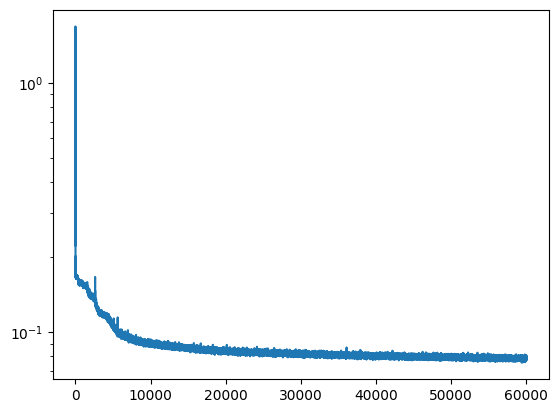

 20%|██        | 60110/300000 [11:36<51:36, 77.47it/s]

<bound method _item of Array(0.07930194, dtype=float32)>


 20%|██        | 60216/300000 [11:37<47:49, 83.56it/s]

<bound method _item of Array(0.07971533, dtype=float32)>


 20%|██        | 60315/300000 [11:39<48:15, 82.77it/s]

<bound method _item of Array(0.07950866, dtype=float32)>


 20%|██        | 60414/300000 [11:40<48:11, 82.85it/s]

<bound method _item of Array(0.08023679, dtype=float32)>


 20%|██        | 60513/300000 [11:41<47:36, 83.85it/s]

<bound method _item of Array(0.07795591, dtype=float32)>


 20%|██        | 60612/300000 [11:42<49:17, 80.94it/s]

<bound method _item of Array(0.07861079, dtype=float32)>


 20%|██        | 60711/300000 [11:43<47:21, 84.22it/s]

<bound method _item of Array(0.07899246, dtype=float32)>


 20%|██        | 60810/300000 [11:44<49:14, 80.97it/s]

<bound method _item of Array(0.07873337, dtype=float32)>


 20%|██        | 60915/300000 [11:46<50:40, 78.62it/s]

<bound method _item of Array(0.07879221, dtype=float32)>


 20%|██        | 61011/300000 [11:47<53:10, 74.90it/s]

<bound method _item of Array(0.07898793, dtype=float32)>


 20%|██        | 61116/300000 [11:48<50:10, 79.35it/s]

<bound method _item of Array(0.07703984, dtype=float32)>


 20%|██        | 61215/300000 [11:50<49:19, 80.69it/s]

<bound method _item of Array(0.07771569, dtype=float32)>


 20%|██        | 61313/300000 [11:51<48:58, 81.22it/s]

<bound method _item of Array(0.07846456, dtype=float32)>


 20%|██        | 61408/300000 [11:52<53:15, 74.66it/s]

<bound method _item of Array(0.07761285, dtype=float32)>


 21%|██        | 61514/300000 [11:53<47:52, 83.01it/s]

<bound method _item of Array(0.07853031, dtype=float32)>


 21%|██        | 61613/300000 [11:54<47:34, 83.51it/s]

<bound method _item of Array(0.07811125, dtype=float32)>


 21%|██        | 61712/300000 [11:56<48:28, 81.94it/s]

<bound method _item of Array(0.07760488, dtype=float32)>


 21%|██        | 61811/300000 [11:57<47:36, 83.38it/s]

<bound method _item of Array(0.08133064, dtype=float32)>


 21%|██        | 61910/300000 [11:58<50:18, 78.88it/s]

<bound method _item of Array(0.07843748, dtype=float32)>


 21%|██        | 62010/300000 [11:59<49:35, 79.98it/s]

<bound method _item of Array(0.07833252, dtype=float32)>


 21%|██        | 62114/300000 [12:01<48:34, 81.62it/s]

<bound method _item of Array(0.0779471, dtype=float32)>


 21%|██        | 62213/300000 [12:02<47:37, 83.23it/s]

<bound method _item of Array(0.07797392, dtype=float32)>


 21%|██        | 62312/300000 [12:03<47:36, 83.22it/s]

<bound method _item of Array(0.07746661, dtype=float32)>


 21%|██        | 62411/300000 [12:04<47:44, 82.94it/s]

<bound method _item of Array(0.07744789, dtype=float32)>


 21%|██        | 62510/300000 [12:05<47:55, 82.60it/s]

<bound method _item of Array(0.07869855, dtype=float32)>


 21%|██        | 62609/300000 [12:07<47:55, 82.56it/s]

<bound method _item of Array(0.07868841, dtype=float32)>


 21%|██        | 62717/300000 [12:08<48:13, 82.00it/s]

<bound method _item of Array(0.07809417, dtype=float32)>


 21%|██        | 62816/300000 [12:09<49:46, 79.42it/s]

<bound method _item of Array(0.07786881, dtype=float32)>


 21%|██        | 62913/300000 [12:10<52:34, 75.15it/s]

<bound method _item of Array(0.07696331, dtype=float32)>


 21%|██        | 63009/300000 [12:12<51:29, 76.72it/s]

<bound method _item of Array(0.07974192, dtype=float32)>


 21%|██        | 63111/300000 [12:13<48:01, 82.21it/s]

<bound method _item of Array(0.07857588, dtype=float32)>


 21%|██        | 63216/300000 [12:14<49:23, 79.89it/s]

<bound method _item of Array(0.07859597, dtype=float32)>


 21%|██        | 63314/300000 [12:16<50:45, 77.72it/s]

<bound method _item of Array(0.07920235, dtype=float32)>


 21%|██        | 63414/300000 [12:17<49:45, 79.23it/s]

<bound method _item of Array(0.07824644, dtype=float32)>


 21%|██        | 63512/300000 [12:18<49:51, 79.06it/s]

<bound method _item of Array(0.07840578, dtype=float32)>


 21%|██        | 63611/300000 [12:19<49:24, 79.74it/s]

<bound method _item of Array(0.07830022, dtype=float32)>


 21%|██        | 63717/300000 [12:21<48:35, 81.05it/s]

<bound method _item of Array(0.0784473, dtype=float32)>


 21%|██▏       | 63811/300000 [12:22<50:04, 78.62it/s]

<bound method _item of Array(0.07692493, dtype=float32)>


 21%|██▏       | 63909/300000 [12:23<49:36, 79.33it/s]

<bound method _item of Array(0.07783303, dtype=float32)>


 21%|██▏       | 64009/300000 [12:24<48:08, 81.69it/s]

<bound method _item of Array(0.07837829, dtype=float32)>


 21%|██▏       | 64117/300000 [12:26<48:11, 81.59it/s]

<bound method _item of Array(0.07735708, dtype=float32)>


 21%|██▏       | 64216/300000 [12:27<48:48, 80.52it/s]

<bound method _item of Array(0.07711992, dtype=float32)>


 21%|██▏       | 64315/300000 [12:28<48:28, 81.03it/s]

<bound method _item of Array(0.07777672, dtype=float32)>


 21%|██▏       | 64412/300000 [12:29<49:32, 79.24it/s]

<bound method _item of Array(0.07681393, dtype=float32)>


 22%|██▏       | 64509/300000 [12:31<48:03, 81.67it/s]

<bound method _item of Array(0.07728642, dtype=float32)>


 22%|██▏       | 64617/300000 [12:32<48:47, 80.40it/s]

<bound method _item of Array(0.07746838, dtype=float32)>


 22%|██▏       | 64709/300000 [12:33<50:36, 77.48it/s]

<bound method _item of Array(0.0791062, dtype=float32)>


 22%|██▏       | 64813/300000 [12:34<50:54, 77.00it/s]

<bound method _item of Array(0.07833753, dtype=float32)>


 22%|██▏       | 64909/300000 [12:36<52:00, 75.33it/s]

<bound method _item of Array(0.07696888, dtype=float32)>


 22%|██▏       | 65010/300000 [12:37<51:07, 76.61it/s]

<bound method _item of Array(0.07747324, dtype=float32)>


 22%|██▏       | 65115/300000 [12:38<48:42, 80.36it/s]

<bound method _item of Array(0.07777977, dtype=float32)>


 22%|██▏       | 65213/300000 [12:40<48:47, 80.20it/s]

<bound method _item of Array(0.07888661, dtype=float32)>


 22%|██▏       | 65312/300000 [12:41<47:50, 81.75it/s]

<bound method _item of Array(0.07762624, dtype=float32)>


 22%|██▏       | 65411/300000 [12:42<50:18, 77.72it/s]

<bound method _item of Array(0.07860877, dtype=float32)>


 22%|██▏       | 65509/300000 [12:43<48:23, 80.77it/s]

<bound method _item of Array(0.07936384, dtype=float32)>


 22%|██▏       | 65616/300000 [12:45<48:21, 80.79it/s]

<bound method _item of Array(0.07843876, dtype=float32)>


 22%|██▏       | 65709/300000 [12:46<50:37, 77.12it/s]

<bound method _item of Array(0.07854094, dtype=float32)>


 22%|██▏       | 65813/300000 [12:47<51:33, 75.71it/s]

<bound method _item of Array(0.07854938, dtype=float32)>


 22%|██▏       | 65912/300000 [12:48<48:11, 80.96it/s]

<bound method _item of Array(0.07821815, dtype=float32)>


 22%|██▏       | 66010/300000 [12:50<48:56, 79.69it/s]

<bound method _item of Array(0.07852176, dtype=float32)>


 22%|██▏       | 66115/300000 [12:51<47:32, 81.99it/s]

<bound method _item of Array(0.07726377, dtype=float32)>


 22%|██▏       | 66214/300000 [12:52<49:55, 78.05it/s]

<bound method _item of Array(0.07849289, dtype=float32)>


 22%|██▏       | 66313/300000 [12:53<48:24, 80.44it/s]

<bound method _item of Array(0.07797191, dtype=float32)>


 22%|██▏       | 66410/300000 [12:54<49:16, 79.01it/s]

<bound method _item of Array(0.0788967, dtype=float32)>


 22%|██▏       | 66509/300000 [12:56<48:02, 80.99it/s]

<bound method _item of Array(0.07738478, dtype=float32)>


 22%|██▏       | 66613/300000 [12:57<50:48, 76.57it/s]

<bound method _item of Array(0.07957429, dtype=float32)>


 22%|██▏       | 66711/300000 [12:58<49:18, 78.85it/s]

<bound method _item of Array(0.07838636, dtype=float32)>


 22%|██▏       | 66809/300000 [13:00<49:52, 77.93it/s]

<bound method _item of Array(0.0791881, dtype=float32)>


 22%|██▏       | 66911/300000 [13:01<49:01, 79.23it/s]

<bound method _item of Array(0.07790215, dtype=float32)>


 22%|██▏       | 67016/300000 [13:02<51:01, 76.09it/s]

<bound method _item of Array(0.07757731, dtype=float32)>


 22%|██▏       | 67116/300000 [13:03<48:37, 79.84it/s]

<bound method _item of Array(0.07788017, dtype=float32)>


 22%|██▏       | 67216/300000 [13:05<48:25, 80.13it/s]

<bound method _item of Array(0.07853919, dtype=float32)>


 22%|██▏       | 67310/300000 [13:06<48:34, 79.85it/s]

<bound method _item of Array(0.07767594, dtype=float32)>


 22%|██▏       | 67417/300000 [13:07<49:42, 77.98it/s]

<bound method _item of Array(0.07789952, dtype=float32)>


 23%|██▎       | 67509/300000 [13:08<50:57, 76.04it/s]

<bound method _item of Array(0.07808997, dtype=float32)>


 23%|██▎       | 67613/300000 [13:10<52:19, 74.01it/s]

<bound method _item of Array(0.07871081, dtype=float32)>


 23%|██▎       | 67709/300000 [13:11<51:08, 75.70it/s]

<bound method _item of Array(0.07741479, dtype=float32)>


 23%|██▎       | 67814/300000 [13:12<50:02, 77.32it/s]

<bound method _item of Array(0.07735967, dtype=float32)>


 23%|██▎       | 67910/300000 [13:14<49:22, 78.35it/s]

<bound method _item of Array(0.0790318, dtype=float32)>


 23%|██▎       | 68010/300000 [13:15<49:07, 78.72it/s]

<bound method _item of Array(0.07831781, dtype=float32)>


 23%|██▎       | 68112/300000 [13:16<48:08, 80.29it/s]

<bound method _item of Array(0.07797086, dtype=float32)>


 23%|██▎       | 68214/300000 [13:18<50:09, 77.02it/s]

<bound method _item of Array(0.0778492, dtype=float32)>


 23%|██▎       | 68312/300000 [13:19<49:36, 77.85it/s]

<bound method _item of Array(0.07722422, dtype=float32)>


 23%|██▎       | 68416/300000 [13:20<51:40, 74.70it/s]

<bound method _item of Array(0.07905696, dtype=float32)>


 23%|██▎       | 68512/300000 [13:21<52:46, 73.11it/s]

<bound method _item of Array(0.07583645, dtype=float32)>


 23%|██▎       | 68608/300000 [13:23<51:59, 74.18it/s]

<bound method _item of Array(0.07929879, dtype=float32)>


 23%|██▎       | 68713/300000 [13:24<50:07, 76.89it/s]

<bound method _item of Array(0.07723214, dtype=float32)>


 23%|██▎       | 68813/300000 [13:25<50:23, 76.47it/s]

<bound method _item of Array(0.07798515, dtype=float32)>


 23%|██▎       | 68915/300000 [13:27<48:18, 79.72it/s]

<bound method _item of Array(0.07734566, dtype=float32)>


 23%|██▎       | 69009/300000 [13:28<48:24, 79.53it/s]

<bound method _item of Array(0.07873084, dtype=float32)>


 23%|██▎       | 69109/300000 [13:29<48:57, 78.59it/s]

<bound method _item of Array(0.07757927, dtype=float32)>


 23%|██▎       | 69215/300000 [13:31<48:40, 79.03it/s]

<bound method _item of Array(0.07810131, dtype=float32)>


 23%|██▎       | 69315/300000 [13:32<49:06, 78.29it/s]

<bound method _item of Array(0.07742806, dtype=float32)>


 23%|██▎       | 69411/300000 [13:33<50:17, 76.41it/s]

<bound method _item of Array(0.07712066, dtype=float32)>


 23%|██▎       | 69516/300000 [13:34<48:24, 79.37it/s]

<bound method _item of Array(0.07836283, dtype=float32)>


 23%|██▎       | 69613/300000 [13:36<48:30, 79.16it/s]

<bound method _item of Array(0.07754502, dtype=float32)>


 23%|██▎       | 69715/300000 [13:37<48:18, 79.46it/s]

<bound method _item of Array(0.07819165, dtype=float32)>


 23%|██▎       | 69816/300000 [13:38<48:22, 79.31it/s]

<bound method _item of Array(0.07878954, dtype=float32)>


 23%|██▎       | 69910/300000 [13:39<48:19, 79.36it/s]

<bound method _item of Array(0.0777883, dtype=float32)>


 23%|██▎       | 69998/300000 [13:40<48:20, 79.29it/s]

<bound method _item of Array(0.07821543, dtype=float32)>


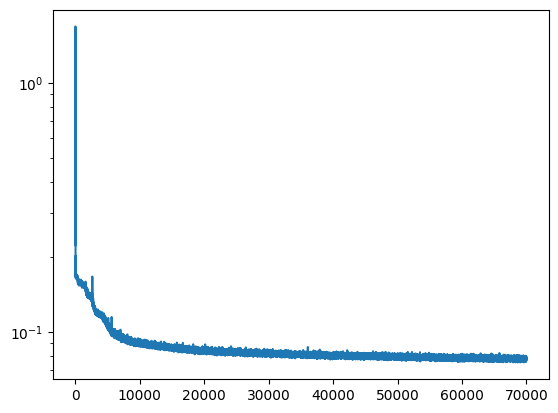

 23%|██▎       | 70112/300000 [13:42<49:56, 76.71it/s]

<bound method _item of Array(0.07817739, dtype=float32)>


 23%|██▎       | 70209/300000 [13:43<49:26, 77.47it/s]

<bound method _item of Array(0.07980975, dtype=float32)>


 23%|██▎       | 70308/300000 [13:45<51:29, 74.34it/s]

<bound method _item of Array(0.07841381, dtype=float32)>


 23%|██▎       | 70412/300000 [13:46<53:27, 71.59it/s]

<bound method _item of Array(0.07831397, dtype=float32)>


 24%|██▎       | 70516/300000 [13:48<50:35, 75.60it/s]

<bound method _item of Array(0.07671087, dtype=float32)>


 24%|██▎       | 70613/300000 [13:49<48:33, 78.74it/s]

<bound method _item of Array(0.07811051, dtype=float32)>


 24%|██▎       | 70714/300000 [13:50<47:40, 80.15it/s]

<bound method _item of Array(0.07700222, dtype=float32)>


 24%|██▎       | 70809/300000 [13:51<49:38, 76.95it/s]

<bound method _item of Array(0.07735412, dtype=float32)>


 24%|██▎       | 70912/300000 [13:53<47:50, 79.82it/s]

<bound method _item of Array(0.0769545, dtype=float32)>


 24%|██▎       | 71014/300000 [13:54<48:06, 79.32it/s]

<bound method _item of Array(0.07835533, dtype=float32)>


 24%|██▎       | 71110/300000 [13:55<48:29, 78.66it/s]

<bound method _item of Array(0.07728891, dtype=float32)>


 24%|██▎       | 71214/300000 [13:56<51:01, 74.73it/s]

<bound method _item of Array(0.07783409, dtype=float32)>


 24%|██▍       | 71310/300000 [13:58<50:43, 75.15it/s]

<bound method _item of Array(0.07808644, dtype=float32)>


 24%|██▍       | 71414/300000 [13:59<49:42, 76.64it/s]

<bound method _item of Array(0.07795335, dtype=float32)>


 24%|██▍       | 71510/300000 [14:00<49:19, 77.22it/s]

<bound method _item of Array(0.07862747, dtype=float32)>


 24%|██▍       | 71617/300000 [14:02<48:11, 78.97it/s]

<bound method _item of Array(0.07662209, dtype=float32)>


 24%|██▍       | 71714/300000 [14:03<48:08, 79.04it/s]

<bound method _item of Array(0.07719489, dtype=float32)>


 24%|██▍       | 71813/300000 [14:04<47:46, 79.60it/s]

<bound method _item of Array(0.07822767, dtype=float32)>


 24%|██▍       | 71912/300000 [14:05<48:18, 78.70it/s]

<bound method _item of Array(0.07768581, dtype=float32)>


 24%|██▍       | 72010/300000 [14:07<48:13, 78.80it/s]

<bound method _item of Array(0.07731993, dtype=float32)>


 24%|██▍       | 72114/300000 [14:08<49:49, 76.22it/s]

<bound method _item of Array(0.07746572, dtype=float32)>


 24%|██▍       | 72210/300000 [14:09<49:57, 75.99it/s]

<bound method _item of Array(0.0778042, dtype=float32)>


 24%|██▍       | 72315/300000 [14:11<47:56, 79.14it/s]

<bound method _item of Array(0.07730487, dtype=float32)>


 24%|██▍       | 72411/300000 [14:12<47:44, 79.44it/s]

<bound method _item of Array(0.07730202, dtype=float32)>


 24%|██▍       | 72509/300000 [14:13<47:56, 79.08it/s]

<bound method _item of Array(0.07731722, dtype=float32)>


 24%|██▍       | 72615/300000 [14:14<48:40, 77.86it/s]

<bound method _item of Array(0.07778174, dtype=float32)>


 24%|██▍       | 72716/300000 [14:16<48:00, 78.90it/s]

<bound method _item of Array(0.07584304, dtype=float32)>


 24%|██▍       | 72815/300000 [14:17<48:57, 77.33it/s]

<bound method _item of Array(0.07689147, dtype=float32)>


 24%|██▍       | 72915/300000 [14:18<47:56, 78.94it/s]

<bound method _item of Array(0.07800814, dtype=float32)>


 24%|██▍       | 73011/300000 [14:19<49:03, 77.12it/s]

<bound method _item of Array(0.07873268, dtype=float32)>


 24%|██▍       | 73115/300000 [14:21<50:25, 74.99it/s]

<bound method _item of Array(0.07817428, dtype=float32)>


 24%|██▍       | 73211/300000 [14:22<49:34, 76.25it/s]

<bound method _item of Array(0.07658183, dtype=float32)>


 24%|██▍       | 73313/300000 [14:23<49:05, 76.96it/s]

<bound method _item of Array(0.0780378, dtype=float32)>


 24%|██▍       | 73413/300000 [14:25<48:02, 78.61it/s]

<bound method _item of Array(0.07807487, dtype=float32)>


 25%|██▍       | 73509/300000 [14:26<48:45, 77.41it/s]

<bound method _item of Array(0.07857133, dtype=float32)>


 25%|██▍       | 73613/300000 [14:27<49:47, 75.78it/s]

<bound method _item of Array(0.07730324, dtype=float32)>


 25%|██▍       | 73711/300000 [14:29<49:03, 76.87it/s]

<bound method _item of Array(0.0770951, dtype=float32)>


 25%|██▍       | 73815/300000 [14:30<48:38, 77.51it/s]

<bound method _item of Array(0.07696584, dtype=float32)>


 25%|██▍       | 73911/300000 [14:31<50:02, 75.30it/s]

<bound method _item of Array(0.07718655, dtype=float32)>


 25%|██▍       | 74015/300000 [14:33<52:02, 72.38it/s]

<bound method _item of Array(0.07783588, dtype=float32)>


 25%|██▍       | 74111/300000 [14:34<50:11, 75.01it/s]

<bound method _item of Array(0.07717525, dtype=float32)>


 25%|██▍       | 74215/300000 [14:35<49:11, 76.51it/s]

<bound method _item of Array(0.07690816, dtype=float32)>


 25%|██▍       | 74312/300000 [14:37<48:10, 78.09it/s]

<bound method _item of Array(0.07838164, dtype=float32)>


 25%|██▍       | 74410/300000 [14:38<47:58, 78.37it/s]

<bound method _item of Array(0.07721724, dtype=float32)>


 25%|██▍       | 74514/300000 [14:39<48:47, 77.02it/s]

<bound method _item of Array(0.07619426, dtype=float32)>


 25%|██▍       | 74610/300000 [14:40<49:09, 76.41it/s]

<bound method _item of Array(0.07730912, dtype=float32)>


 25%|██▍       | 74711/300000 [14:42<47:59, 78.23it/s]

<bound method _item of Array(0.077774, dtype=float32)>


 25%|██▍       | 74815/300000 [14:43<50:26, 74.40it/s]

<bound method _item of Array(0.07722694, dtype=float32)>


 25%|██▍       | 74911/300000 [14:44<49:54, 75.16it/s]

<bound method _item of Array(0.07702523, dtype=float32)>


 25%|██▌       | 75015/300000 [14:46<49:33, 75.66it/s]

<bound method _item of Array(0.07739775, dtype=float32)>


 25%|██▌       | 75111/300000 [14:47<49:56, 75.05it/s]

<bound method _item of Array(0.07779974, dtype=float32)>


 25%|██▌       | 75215/300000 [14:48<49:11, 76.15it/s]

<bound method _item of Array(0.07773542, dtype=float32)>


 25%|██▌       | 75313/300000 [14:50<47:23, 79.01it/s]

<bound method _item of Array(0.07888167, dtype=float32)>


 25%|██▌       | 75414/300000 [14:51<46:43, 80.11it/s]

<bound method _item of Array(0.07761078, dtype=float32)>


 25%|██▌       | 75511/300000 [14:52<49:35, 75.45it/s]

<bound method _item of Array(0.07741652, dtype=float32)>


 25%|██▌       | 75616/300000 [14:54<48:21, 77.34it/s]

<bound method _item of Array(0.0767178, dtype=float32)>


 25%|██▌       | 75712/300000 [14:55<49:03, 76.20it/s]

<bound method _item of Array(0.07841041, dtype=float32)>


 25%|██▌       | 75808/300000 [14:56<50:42, 73.68it/s]

<bound method _item of Array(0.07821052, dtype=float32)>


 25%|██▌       | 75912/300000 [14:57<50:38, 73.75it/s]

<bound method _item of Array(0.07648835, dtype=float32)>


 25%|██▌       | 76010/300000 [14:59<46:49, 79.71it/s]

<bound method _item of Array(0.07601351, dtype=float32)>


 25%|██▌       | 76114/300000 [15:00<48:37, 76.73it/s]

<bound method _item of Array(0.07812487, dtype=float32)>


 25%|██▌       | 76210/300000 [15:01<49:12, 75.79it/s]

<bound method _item of Array(0.07734326, dtype=float32)>


 25%|██▌       | 76314/300000 [15:03<48:24, 77.02it/s]

<bound method _item of Array(0.07833233, dtype=float32)>


 25%|██▌       | 76411/300000 [15:04<47:35, 78.31it/s]

<bound method _item of Array(0.07803687, dtype=float32)>


 26%|██▌       | 76515/300000 [15:05<47:46, 77.97it/s]

<bound method _item of Array(0.07889581, dtype=float32)>


 26%|██▌       | 76612/300000 [15:07<48:28, 76.81it/s]

<bound method _item of Array(0.07859769, dtype=float32)>


 26%|██▌       | 76708/300000 [15:08<49:57, 74.48it/s]

<bound method _item of Array(0.07780185, dtype=float32)>


 26%|██▌       | 76812/300000 [15:09<50:02, 74.34it/s]

<bound method _item of Array(0.07794912, dtype=float32)>


 26%|██▌       | 76909/300000 [15:11<47:12, 78.77it/s]

<bound method _item of Array(0.07884128, dtype=float32)>


 26%|██▌       | 77014/300000 [15:12<47:54, 77.56it/s]

<bound method _item of Array(0.07662706, dtype=float32)>


 26%|██▌       | 77111/300000 [15:13<47:37, 78.00it/s]

<bound method _item of Array(0.07825784, dtype=float32)>


 26%|██▌       | 77215/300000 [15:14<47:42, 77.83it/s]

<bound method _item of Array(0.07672203, dtype=float32)>


 26%|██▌       | 77311/300000 [15:16<47:08, 78.72it/s]

<bound method _item of Array(0.07786996, dtype=float32)>


 26%|██▌       | 77410/300000 [15:17<47:13, 78.55it/s]

<bound method _item of Array(0.07852268, dtype=float32)>


 26%|██▌       | 77514/300000 [15:18<47:56, 77.36it/s]

<bound method _item of Array(0.07791458, dtype=float32)>


 26%|██▌       | 77610/300000 [15:20<50:23, 73.54it/s]

<bound method _item of Array(0.07819657, dtype=float32)>


 26%|██▌       | 77714/300000 [15:21<49:23, 75.01it/s]

<bound method _item of Array(0.07662658, dtype=float32)>


 26%|██▌       | 77810/300000 [15:22<49:21, 75.03it/s]

<bound method _item of Array(0.07827174, dtype=float32)>


 26%|██▌       | 77914/300000 [15:24<48:44, 75.93it/s]

<bound method _item of Array(0.07651904, dtype=float32)>


 26%|██▌       | 78011/300000 [15:25<47:32, 77.84it/s]

<bound method _item of Array(0.07898058, dtype=float32)>


 26%|██▌       | 78115/300000 [15:26<48:20, 76.49it/s]

<bound method _item of Array(0.07924953, dtype=float32)>


 26%|██▌       | 78211/300000 [15:27<48:14, 76.61it/s]

<bound method _item of Array(0.076938, dtype=float32)>


 26%|██▌       | 78315/300000 [15:29<47:41, 77.48it/s]

<bound method _item of Array(0.07729637, dtype=float32)>


 26%|██▌       | 78411/300000 [15:30<47:43, 77.38it/s]

<bound method _item of Array(0.07502405, dtype=float32)>


 26%|██▌       | 78515/300000 [15:31<49:29, 74.59it/s]

<bound method _item of Array(0.07787357, dtype=float32)>


 26%|██▌       | 78611/300000 [15:33<49:59, 73.82it/s]

<bound method _item of Array(0.07777694, dtype=float32)>


 26%|██▌       | 78715/300000 [15:34<49:14, 74.90it/s]

<bound method _item of Array(0.07645219, dtype=float32)>


 26%|██▋       | 78811/300000 [15:35<49:56, 73.81it/s]

<bound method _item of Array(0.07742129, dtype=float32)>


 26%|██▋       | 78915/300000 [15:37<48:14, 76.37it/s]

<bound method _item of Array(0.07661937, dtype=float32)>


 26%|██▋       | 79011/300000 [15:38<47:48, 77.05it/s]

<bound method _item of Array(0.07626373, dtype=float32)>


 26%|██▋       | 79115/300000 [15:39<49:05, 74.98it/s]

<bound method _item of Array(0.07710344, dtype=float32)>


 26%|██▋       | 79211/300000 [15:41<48:25, 76.00it/s]

<bound method _item of Array(0.07657679, dtype=float32)>


 26%|██▋       | 79315/300000 [15:42<50:28, 72.86it/s]

<bound method _item of Array(0.07762013, dtype=float32)>


 26%|██▋       | 79411/300000 [15:43<50:30, 72.79it/s]

<bound method _item of Array(0.07786898, dtype=float32)>


 27%|██▋       | 79515/300000 [15:45<50:22, 72.95it/s]

<bound method _item of Array(0.07790481, dtype=float32)>


 27%|██▋       | 79611/300000 [15:46<47:53, 76.69it/s]

<bound method _item of Array(0.07703114, dtype=float32)>


 27%|██▋       | 79715/300000 [15:47<48:32, 75.64it/s]

<bound method _item of Array(0.07488585, dtype=float32)>


 27%|██▋       | 79811/300000 [15:49<47:48, 76.77it/s]

<bound method _item of Array(0.07936622, dtype=float32)>


 27%|██▋       | 79915/300000 [15:50<47:53, 76.59it/s]

<bound method _item of Array(0.07768983, dtype=float32)>


 27%|██▋       | 79995/300000 [15:51<47:48, 76.70it/s]

<bound method _item of Array(0.07688154, dtype=float32)>


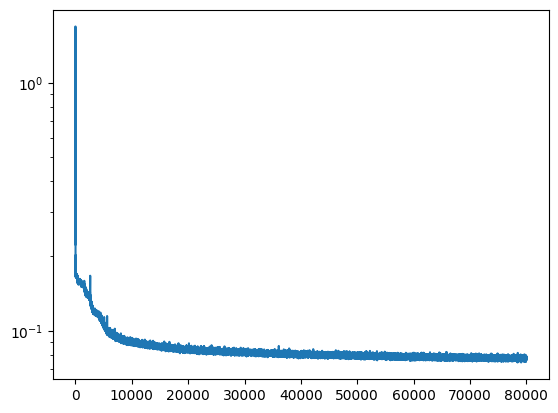

 27%|██▋       | 80115/300000 [15:53<48:51, 75.01it/s]

<bound method _item of Array(0.0782645, dtype=float32)>


 27%|██▋       | 80211/300000 [15:54<48:59, 74.78it/s]

<bound method _item of Array(0.07725217, dtype=float32)>


 27%|██▋       | 80315/300000 [15:56<49:11, 74.42it/s]

<bound method _item of Array(0.07834851, dtype=float32)>


 27%|██▋       | 80411/300000 [15:57<47:55, 76.36it/s]

<bound method _item of Array(0.07740346, dtype=float32)>


 27%|██▋       | 80515/300000 [15:58<47:52, 76.42it/s]

<bound method _item of Array(0.07784008, dtype=float32)>


 27%|██▋       | 80611/300000 [16:00<47:54, 76.32it/s]

<bound method _item of Array(0.07732335, dtype=float32)>


 27%|██▋       | 80715/300000 [16:01<48:30, 75.34it/s]

<bound method _item of Array(0.07766853, dtype=float32)>


 27%|██▋       | 80811/300000 [16:02<49:25, 73.91it/s]

<bound method _item of Array(0.07901628, dtype=float32)>


 27%|██▋       | 80915/300000 [16:04<47:06, 77.52it/s]

<bound method _item of Array(0.07754609, dtype=float32)>


 27%|██▋       | 81011/300000 [16:05<47:21, 77.06it/s]

<bound method _item of Array(0.07776559, dtype=float32)>


 27%|██▋       | 81115/300000 [16:06<49:06, 74.29it/s]

<bound method _item of Array(0.07734773, dtype=float32)>


 27%|██▋       | 81211/300000 [16:08<50:00, 72.91it/s]

<bound method _item of Array(0.07622617, dtype=float32)>


 27%|██▋       | 81315/300000 [16:09<49:27, 73.70it/s]

<bound method _item of Array(0.07739595, dtype=float32)>


 27%|██▋       | 81411/300000 [16:10<48:01, 75.86it/s]

<bound method _item of Array(0.0756065, dtype=float32)>


 27%|██▋       | 81515/300000 [16:12<48:53, 74.47it/s]

<bound method _item of Array(0.07589001, dtype=float32)>


 27%|██▋       | 81611/300000 [16:13<47:25, 76.75it/s]

<bound method _item of Array(0.07658884, dtype=float32)>


 27%|██▋       | 81715/300000 [16:14<48:05, 75.65it/s]

<bound method _item of Array(0.07735632, dtype=float32)>


 27%|██▋       | 81811/300000 [16:16<48:50, 74.45it/s]

<bound method _item of Array(0.07620776, dtype=float32)>


 27%|██▋       | 81915/300000 [16:17<48:09, 75.48it/s]

<bound method _item of Array(0.07765352, dtype=float32)>


 27%|██▋       | 82011/300000 [16:18<49:05, 74.01it/s]

<bound method _item of Array(0.07826068, dtype=float32)>


 27%|██▋       | 82115/300000 [16:20<50:00, 72.62it/s]

<bound method _item of Array(0.07732271, dtype=float32)>


 27%|██▋       | 82211/300000 [16:21<50:14, 72.25it/s]

<bound method _item of Array(0.07789356, dtype=float32)>


 27%|██▋       | 82315/300000 [16:22<48:25, 74.92it/s]

<bound method _item of Array(0.07633919, dtype=float32)>


 27%|██▋       | 82411/300000 [16:24<48:07, 75.35it/s]

<bound method _item of Array(0.07755447, dtype=float32)>


 28%|██▊       | 82515/300000 [16:25<48:33, 74.65it/s]

<bound method _item of Array(0.07706518, dtype=float32)>


 28%|██▊       | 82611/300000 [16:26<49:05, 73.81it/s]

<bound method _item of Array(0.07800227, dtype=float32)>


 28%|██▊       | 82715/300000 [16:28<48:54, 74.04it/s]

<bound method _item of Array(0.07765693, dtype=float32)>


 28%|██▊       | 82811/300000 [16:29<48:23, 74.80it/s]

<bound method _item of Array(0.07854225, dtype=float32)>


 28%|██▊       | 82915/300000 [16:31<50:43, 71.32it/s]

<bound method _item of Array(0.07624237, dtype=float32)>


 28%|██▊       | 83011/300000 [16:32<50:22, 71.80it/s]

<bound method _item of Array(0.07799814, dtype=float32)>


 28%|██▊       | 83115/300000 [16:33<48:52, 73.96it/s]

<bound method _item of Array(0.07723439, dtype=float32)>


 28%|██▊       | 83211/300000 [16:35<48:53, 73.91it/s]

<bound method _item of Array(0.07826057, dtype=float32)>


 28%|██▊       | 83315/300000 [16:36<47:58, 75.27it/s]

<bound method _item of Array(0.0774078, dtype=float32)>


 28%|██▊       | 83411/300000 [16:37<49:18, 73.21it/s]

<bound method _item of Array(0.07844804, dtype=float32)>


 28%|██▊       | 83515/300000 [16:39<47:43, 75.59it/s]

<bound method _item of Array(0.07707348, dtype=float32)>


 28%|██▊       | 83611/300000 [16:40<48:06, 74.96it/s]

<bound method _item of Array(0.07527631, dtype=float32)>


 28%|██▊       | 83715/300000 [16:41<47:50, 75.35it/s]

<bound method _item of Array(0.07659595, dtype=float32)>


 28%|██▊       | 83811/300000 [16:43<49:29, 72.80it/s]

<bound method _item of Array(0.07833312, dtype=float32)>


 28%|██▊       | 83915/300000 [16:44<49:42, 72.45it/s]

<bound method _item of Array(0.07644054, dtype=float32)>


 28%|██▊       | 84011/300000 [16:45<48:34, 74.10it/s]

<bound method _item of Array(0.07658416, dtype=float32)>


 28%|██▊       | 84115/300000 [16:47<47:54, 75.11it/s]

<bound method _item of Array(0.07868702, dtype=float32)>


 28%|██▊       | 84211/300000 [16:48<47:42, 75.39it/s]

<bound method _item of Array(0.07675904, dtype=float32)>


 28%|██▊       | 84315/300000 [16:49<48:35, 73.98it/s]

<bound method _item of Array(0.07579356, dtype=float32)>


 28%|██▊       | 84411/300000 [16:51<48:00, 74.84it/s]

<bound method _item of Array(0.07736461, dtype=float32)>


 28%|██▊       | 84515/300000 [16:52<50:18, 71.38it/s]

<bound method _item of Array(0.07707909, dtype=float32)>


 28%|██▊       | 84611/300000 [16:53<48:35, 73.87it/s]

<bound method _item of Array(0.07746968, dtype=float32)>


 28%|██▊       | 84715/300000 [16:55<49:21, 72.70it/s]

<bound method _item of Array(0.0761314, dtype=float32)>


 28%|██▊       | 84811/300000 [16:56<47:58, 74.75it/s]

<bound method _item of Array(0.07571959, dtype=float32)>


 28%|██▊       | 84915/300000 [16:57<48:17, 74.24it/s]

<bound method _item of Array(0.07623287, dtype=float32)>


 28%|██▊       | 85011/300000 [16:59<46:38, 76.82it/s]

<bound method _item of Array(0.07654914, dtype=float32)>


 28%|██▊       | 85115/300000 [17:00<48:09, 74.36it/s]

<bound method _item of Array(0.07728091, dtype=float32)>


 28%|██▊       | 85211/300000 [17:01<48:12, 74.26it/s]

<bound method _item of Array(0.07702519, dtype=float32)>


 28%|██▊       | 85315/300000 [17:03<47:23, 75.50it/s]

<bound method _item of Array(0.07669418, dtype=float32)>


 28%|██▊       | 85411/300000 [17:04<47:19, 75.58it/s]

<bound method _item of Array(0.07742614, dtype=float32)>


 29%|██▊       | 85515/300000 [17:05<48:55, 73.07it/s]

<bound method _item of Array(0.0771023, dtype=float32)>


 29%|██▊       | 85611/300000 [17:07<49:09, 72.70it/s]

<bound method _item of Array(0.07637949, dtype=float32)>


 29%|██▊       | 85715/300000 [17:08<48:53, 73.04it/s]

<bound method _item of Array(0.07611533, dtype=float32)>


 29%|██▊       | 85811/300000 [17:10<49:29, 72.14it/s]

<bound method _item of Array(0.07857082, dtype=float32)>


 29%|██▊       | 85915/300000 [17:11<47:59, 74.34it/s]

<bound method _item of Array(0.07812495, dtype=float32)>


 29%|██▊       | 86011/300000 [17:12<48:57, 72.84it/s]

<bound method _item of Array(0.07674196, dtype=float32)>


 29%|██▊       | 86115/300000 [17:14<47:48, 74.57it/s]

<bound method _item of Array(0.07754187, dtype=float32)>


 29%|██▊       | 86211/300000 [17:15<47:55, 74.35it/s]

<bound method _item of Array(0.07717647, dtype=float32)>


 29%|██▉       | 86315/300000 [17:16<48:51, 72.88it/s]

<bound method _item of Array(0.07679068, dtype=float32)>


 29%|██▉       | 86411/300000 [17:18<50:22, 70.67it/s]

<bound method _item of Array(0.07808229, dtype=float32)>


 29%|██▉       | 86515/300000 [17:19<49:28, 71.93it/s]

<bound method _item of Array(0.07831261, dtype=float32)>


 29%|██▉       | 86611/300000 [17:20<48:15, 73.70it/s]

<bound method _item of Array(0.0772712, dtype=float32)>


 29%|██▉       | 86715/300000 [17:22<47:57, 74.13it/s]

<bound method _item of Array(0.07767782, dtype=float32)>


 29%|██▉       | 86811/300000 [17:23<47:36, 74.63it/s]

<bound method _item of Array(0.0782492, dtype=float32)>


 29%|██▉       | 86915/300000 [17:25<47:39, 74.51it/s]

<bound method _item of Array(0.07569314, dtype=float32)>


 29%|██▉       | 87011/300000 [17:26<47:34, 74.62it/s]

<bound method _item of Array(0.07625141, dtype=float32)>


 29%|██▉       | 87115/300000 [17:27<48:37, 72.98it/s]

<bound method _item of Array(0.07793251, dtype=float32)>


 29%|██▉       | 87211/300000 [17:29<47:58, 73.93it/s]

<bound method _item of Array(0.07671577, dtype=float32)>


 29%|██▉       | 87315/300000 [17:30<50:09, 70.68it/s]

<bound method _item of Array(0.07719209, dtype=float32)>


 29%|██▉       | 87411/300000 [17:31<49:40, 71.34it/s]

<bound method _item of Array(0.07688539, dtype=float32)>


 29%|██▉       | 87515/300000 [17:33<48:55, 72.38it/s]

<bound method _item of Array(0.07737417, dtype=float32)>


 29%|██▉       | 87611/300000 [17:34<48:28, 73.02it/s]

<bound method _item of Array(0.07704399, dtype=float32)>


 29%|██▉       | 87715/300000 [17:36<47:56, 73.81it/s]

<bound method _item of Array(0.07751729, dtype=float32)>


 29%|██▉       | 87811/300000 [17:37<48:19, 73.18it/s]

<bound method _item of Array(0.07755544, dtype=float32)>


 29%|██▉       | 87915/300000 [17:38<47:38, 74.18it/s]

<bound method _item of Array(0.07774108, dtype=float32)>


 29%|██▉       | 88011/300000 [17:40<47:59, 73.62it/s]

<bound method _item of Array(0.07790936, dtype=float32)>


 29%|██▉       | 88115/300000 [17:41<48:46, 72.41it/s]

<bound method _item of Array(0.07813062, dtype=float32)>


 29%|██▉       | 88211/300000 [17:42<49:55, 70.69it/s]

<bound method _item of Array(0.07592572, dtype=float32)>


 29%|██▉       | 88315/300000 [17:44<48:45, 72.35it/s]

<bound method _item of Array(0.07674764, dtype=float32)>


 29%|██▉       | 88411/300000 [17:45<47:53, 73.63it/s]

<bound method _item of Array(0.07661722, dtype=float32)>


 30%|██▉       | 88515/300000 [17:47<47:37, 74.02it/s]

<bound method _item of Array(0.07626289, dtype=float32)>


 30%|██▉       | 88611/300000 [17:48<47:56, 73.49it/s]

<bound method _item of Array(0.07604537, dtype=float32)>


 30%|██▉       | 88715/300000 [17:49<47:36, 73.96it/s]

<bound method _item of Array(0.07753808, dtype=float32)>


 30%|██▉       | 88811/300000 [17:51<47:19, 74.37it/s]

<bound method _item of Array(0.07701819, dtype=float32)>


 30%|██▉       | 88915/300000 [17:52<47:39, 73.83it/s]

<bound method _item of Array(0.07691082, dtype=float32)>


 30%|██▉       | 89011/300000 [17:53<47:58, 73.29it/s]

<bound method _item of Array(0.07773327, dtype=float32)>


 30%|██▉       | 89115/300000 [17:55<48:44, 72.11it/s]

<bound method _item of Array(0.07708582, dtype=float32)>


 30%|██▉       | 89211/300000 [17:56<48:43, 72.11it/s]

<bound method _item of Array(0.07713088, dtype=float32)>


 30%|██▉       | 89315/300000 [17:57<49:03, 71.57it/s]

<bound method _item of Array(0.07727642, dtype=float32)>


 30%|██▉       | 89411/300000 [17:59<47:23, 74.07it/s]

<bound method _item of Array(0.07714847, dtype=float32)>


 30%|██▉       | 89515/300000 [18:00<48:16, 72.67it/s]

<bound method _item of Array(0.07543051, dtype=float32)>


 30%|██▉       | 89611/300000 [18:02<47:32, 73.76it/s]

<bound method _item of Array(0.07755153, dtype=float32)>


 30%|██▉       | 89715/300000 [18:03<48:25, 72.37it/s]

<bound method _item of Array(0.07812856, dtype=float32)>


 30%|██▉       | 89811/300000 [18:04<49:02, 71.42it/s]

<bound method _item of Array(0.07693867, dtype=float32)>


 30%|██▉       | 89915/300000 [18:06<49:17, 71.02it/s]

<bound method _item of Array(0.07809687, dtype=float32)>


 30%|██▉       | 89995/300000 [18:07<50:04, 69.89it/s]

<bound method _item of Array(0.07537773, dtype=float32)>


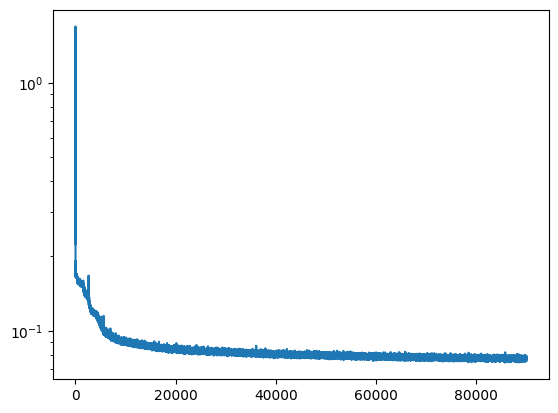

 30%|███       | 90113/300000 [18:09<47:16, 73.99it/s]

<bound method _item of Array(0.07545921, dtype=float32)>


 30%|███       | 90209/300000 [18:10<47:35, 73.48it/s]

<bound method _item of Array(0.07640541, dtype=float32)>


 30%|███       | 90313/300000 [18:11<47:34, 73.46it/s]

<bound method _item of Array(0.07671258, dtype=float32)>


 30%|███       | 90409/300000 [18:13<48:01, 72.74it/s]

<bound method _item of Array(0.07730079, dtype=float32)>


 30%|███       | 90513/300000 [18:14<47:30, 73.50it/s]

<bound method _item of Array(0.07728199, dtype=float32)>


 30%|███       | 90609/300000 [18:16<47:42, 73.16it/s]

<bound method _item of Array(0.07555588, dtype=float32)>


 30%|███       | 90713/300000 [18:17<48:51, 71.40it/s]

<bound method _item of Array(0.07774022, dtype=float32)>


 30%|███       | 90809/300000 [18:18<48:38, 71.67it/s]

<bound method _item of Array(0.0776763, dtype=float32)>


 30%|███       | 90913/300000 [18:20<48:17, 72.15it/s]

<bound method _item of Array(0.07567091, dtype=float32)>


 30%|███       | 91009/300000 [18:21<47:08, 73.89it/s]

<bound method _item of Array(0.07585748, dtype=float32)>


 30%|███       | 91113/300000 [18:22<48:18, 72.07it/s]

<bound method _item of Array(0.07661015, dtype=float32)>


 30%|███       | 91209/300000 [18:24<47:12, 73.72it/s]

<bound method _item of Array(0.07717019, dtype=float32)>


 30%|███       | 91313/300000 [18:25<47:21, 73.43it/s]

<bound method _item of Array(0.07592558, dtype=float32)>


 30%|███       | 91409/300000 [18:27<47:40, 72.92it/s]

<bound method _item of Array(0.07763426, dtype=float32)>


 31%|███       | 91513/300000 [18:28<48:16, 71.98it/s]

<bound method _item of Array(0.07631927, dtype=float32)>


 31%|███       | 91609/300000 [18:29<49:02, 70.82it/s]

<bound method _item of Array(0.07705113, dtype=float32)>


 31%|███       | 91713/300000 [18:31<47:49, 72.58it/s]

<bound method _item of Array(0.07686859, dtype=float32)>


 31%|███       | 91809/300000 [18:32<47:14, 73.45it/s]

<bound method _item of Array(0.07599246, dtype=float32)>


 31%|███       | 91913/300000 [18:33<47:41, 72.72it/s]

<bound method _item of Array(0.07854447, dtype=float32)>


 31%|███       | 92009/300000 [18:35<47:53, 72.39it/s]

<bound method _item of Array(0.07697306, dtype=float32)>


 31%|███       | 92113/300000 [18:36<47:04, 73.59it/s]

<bound method _item of Array(0.07752395, dtype=float32)>


 31%|███       | 92209/300000 [18:38<48:05, 72.01it/s]

<bound method _item of Array(0.07624311, dtype=float32)>


 31%|███       | 92313/300000 [18:39<47:31, 72.83it/s]

<bound method _item of Array(0.0766235, dtype=float32)>


 31%|███       | 92413/300000 [18:40<50:05, 69.06it/s]

<bound method _item of Array(0.07819311, dtype=float32)>


 31%|███       | 92508/300000 [18:42<48:03, 71.96it/s]

<bound method _item of Array(0.07690154, dtype=float32)>


 31%|███       | 92611/300000 [18:43<48:19, 71.52it/s]

<bound method _item of Array(0.07684472, dtype=float32)>


 31%|███       | 92715/300000 [18:45<46:09, 74.84it/s]

<bound method _item of Array(0.07853329, dtype=float32)>


 31%|███       | 92811/300000 [18:46<46:39, 74.02it/s]

<bound method _item of Array(0.07656582, dtype=float32)>


 31%|███       | 92915/300000 [18:47<47:28, 72.70it/s]

<bound method _item of Array(0.0785838, dtype=float32)>


 31%|███       | 93011/300000 [18:49<46:18, 74.51it/s]

<bound method _item of Array(0.07661738, dtype=float32)>


 31%|███       | 93115/300000 [18:50<46:26, 74.24it/s]

<bound method _item of Array(0.07804498, dtype=float32)>


 31%|███       | 93211/300000 [18:51<47:10, 73.07it/s]

<bound method _item of Array(0.07658052, dtype=float32)>


 31%|███       | 93312/300000 [18:53<50:15, 68.55it/s]

<bound method _item of Array(0.077786, dtype=float32)>


 31%|███       | 93414/300000 [18:54<47:00, 73.24it/s]

<bound method _item of Array(0.07595994, dtype=float32)>


 31%|███       | 93510/300000 [18:55<46:53, 73.40it/s]

<bound method _item of Array(0.07791141, dtype=float32)>


 31%|███       | 93614/300000 [18:57<46:03, 74.67it/s]

<bound method _item of Array(0.07758582, dtype=float32)>


 31%|███       | 93710/300000 [18:58<46:08, 74.51it/s]

<bound method _item of Array(0.07778435, dtype=float32)>


 31%|███▏      | 93814/300000 [19:00<46:53, 73.29it/s]

<bound method _item of Array(0.07656628, dtype=float32)>


 31%|███▏      | 93910/300000 [19:01<46:28, 73.92it/s]

<bound method _item of Array(0.07580076, dtype=float32)>


 31%|███▏      | 94014/300000 [19:02<46:12, 74.29it/s]

<bound method _item of Array(0.07691736, dtype=float32)>


 31%|███▏      | 94110/300000 [19:04<46:52, 73.22it/s]

<bound method _item of Array(0.07770845, dtype=float32)>


 31%|███▏      | 94214/300000 [19:05<47:14, 72.60it/s]

<bound method _item of Array(0.07507972, dtype=float32)>


 31%|███▏      | 94310/300000 [19:06<47:06, 72.78it/s]

<bound method _item of Array(0.07662438, dtype=float32)>


 31%|███▏      | 94414/300000 [19:08<46:15, 74.08it/s]

<bound method _item of Array(0.0774202, dtype=float32)>


 32%|███▏      | 94510/300000 [19:09<46:19, 73.94it/s]

<bound method _item of Array(0.07727933, dtype=float32)>


 32%|███▏      | 94614/300000 [19:10<46:17, 73.96it/s]

<bound method _item of Array(0.07611429, dtype=float32)>


 32%|███▏      | 94710/300000 [19:12<46:02, 74.31it/s]

<bound method _item of Array(0.07682739, dtype=float32)>


 32%|███▏      | 94814/300000 [19:13<47:21, 72.21it/s]

<bound method _item of Array(0.07688766, dtype=float32)>


 32%|███▏      | 94910/300000 [19:14<46:02, 74.25it/s]

<bound method _item of Array(0.07594219, dtype=float32)>


 32%|███▏      | 95014/300000 [19:16<45:42, 74.74it/s]

<bound method _item of Array(0.07627788, dtype=float32)>


 32%|███▏      | 95110/300000 [19:17<46:28, 73.48it/s]

<bound method _item of Array(0.07620902, dtype=float32)>


 32%|███▏      | 95214/300000 [19:19<46:23, 73.58it/s]

<bound method _item of Array(0.07705094, dtype=float32)>


 32%|███▏      | 95310/300000 [19:20<45:56, 74.27it/s]

<bound method _item of Array(0.07674731, dtype=float32)>


 32%|███▏      | 95414/300000 [19:21<46:40, 73.04it/s]

<bound method _item of Array(0.07600307, dtype=float32)>


 32%|███▏      | 95510/300000 [19:23<46:27, 73.36it/s]

<bound method _item of Array(0.07753721, dtype=float32)>


 32%|███▏      | 95614/300000 [19:24<45:56, 74.14it/s]

<bound method _item of Array(0.07787408, dtype=float32)>


 32%|███▏      | 95710/300000 [19:25<45:59, 74.03it/s]

<bound method _item of Array(0.07721698, dtype=float32)>


 32%|███▏      | 95814/300000 [19:27<45:58, 74.03it/s]

<bound method _item of Array(0.07694419, dtype=float32)>


 32%|███▏      | 95910/300000 [19:28<48:04, 70.76it/s]

<bound method _item of Array(0.07643843, dtype=float32)>


 32%|███▏      | 96014/300000 [19:30<47:27, 71.64it/s]

<bound method _item of Array(0.07694108, dtype=float32)>


 32%|███▏      | 96110/300000 [19:31<46:49, 72.57it/s]

<bound method _item of Array(0.07767781, dtype=float32)>


 32%|███▏      | 96214/300000 [19:32<48:13, 70.44it/s]

<bound method _item of Array(0.07589121, dtype=float32)>


 32%|███▏      | 96310/300000 [19:34<46:04, 73.68it/s]

<bound method _item of Array(0.07600069, dtype=float32)>


 32%|███▏      | 96414/300000 [19:35<46:23, 73.15it/s]

<bound method _item of Array(0.07541694, dtype=float32)>


 32%|███▏      | 96510/300000 [19:36<46:02, 73.67it/s]

<bound method _item of Array(0.07577708, dtype=float32)>


 32%|███▏      | 96614/300000 [19:38<46:15, 73.27it/s]

<bound method _item of Array(0.07815518, dtype=float32)>


 32%|███▏      | 96710/300000 [19:39<46:46, 72.42it/s]

<bound method _item of Array(0.07614511, dtype=float32)>


 32%|███▏      | 96814/300000 [19:41<47:45, 70.92it/s]

<bound method _item of Array(0.07631384, dtype=float32)>


 32%|███▏      | 96910/300000 [19:42<47:23, 71.42it/s]

<bound method _item of Array(0.07613667, dtype=float32)>


 32%|███▏      | 97013/300000 [19:43<46:50, 72.22it/s]

<bound method _item of Array(0.07705419, dtype=float32)>


 32%|███▏      | 97109/300000 [19:45<47:18, 71.49it/s]

<bound method _item of Array(0.07822244, dtype=float32)>


 32%|███▏      | 97213/300000 [19:46<48:04, 70.30it/s]

<bound method _item of Array(0.07602209, dtype=float32)>


 32%|███▏      | 97309/300000 [19:47<48:02, 70.33it/s]

<bound method _item of Array(0.07669487, dtype=float32)>


 32%|███▏      | 97413/300000 [19:49<46:55, 71.95it/s]

<bound method _item of Array(0.07586093, dtype=float32)>


 33%|███▎      | 97509/300000 [19:50<46:43, 72.24it/s]

<bound method _item of Array(0.07679936, dtype=float32)>


 33%|███▎      | 97613/300000 [19:52<47:40, 70.76it/s]

<bound method _item of Array(0.07646564, dtype=float32)>


 33%|███▎      | 97709/300000 [19:53<47:51, 70.44it/s]

<bound method _item of Array(0.07541911, dtype=float32)>


 33%|███▎      | 97813/300000 [19:55<47:44, 70.60it/s]

<bound method _item of Array(0.07691143, dtype=float32)>


 33%|███▎      | 97908/300000 [19:56<46:47, 71.97it/s]

<bound method _item of Array(0.07709483, dtype=float32)>


 33%|███▎      | 98012/300000 [19:57<47:40, 70.61it/s]

<bound method _item of Array(0.07656381, dtype=float32)>


 33%|███▎      | 98108/300000 [19:59<46:37, 72.17it/s]

<bound method _item of Array(0.07738334, dtype=float32)>


 33%|███▎      | 98212/300000 [20:00<47:07, 71.37it/s]

<bound method _item of Array(0.07722619, dtype=float32)>


 33%|███▎      | 98308/300000 [20:01<46:38, 72.08it/s]

<bound method _item of Array(0.07617451, dtype=float32)>


 33%|███▎      | 98412/300000 [20:03<46:51, 71.69it/s]

<bound method _item of Array(0.07865883, dtype=float32)>


 33%|███▎      | 98508/300000 [20:04<46:28, 72.25it/s]

<bound method _item of Array(0.07763582, dtype=float32)>


 33%|███▎      | 98612/300000 [20:06<47:17, 70.97it/s]

<bound method _item of Array(0.07668569, dtype=float32)>


 33%|███▎      | 98708/300000 [20:07<46:47, 71.69it/s]

<bound method _item of Array(0.07640073, dtype=float32)>


 33%|███▎      | 98812/300000 [20:08<46:24, 72.24it/s]

<bound method _item of Array(0.07595799, dtype=float32)>


 33%|███▎      | 98908/300000 [20:10<46:40, 71.81it/s]

<bound method _item of Array(0.07642473, dtype=float32)>


 33%|███▎      | 99012/300000 [20:11<46:04, 72.70it/s]

<bound method _item of Array(0.07618799, dtype=float32)>


 33%|███▎      | 99116/300000 [20:13<46:16, 72.35it/s]

<bound method _item of Array(0.07434142, dtype=float32)>


 33%|███▎      | 99212/300000 [20:14<46:34, 71.86it/s]

<bound method _item of Array(0.07708079, dtype=float32)>


 33%|███▎      | 99308/300000 [20:15<45:59, 72.72it/s]

<bound method _item of Array(0.0759678, dtype=float32)>


 33%|███▎      | 99412/300000 [20:17<46:10, 72.40it/s]

<bound method _item of Array(0.07596584, dtype=float32)>


 33%|███▎      | 99515/300000 [20:18<46:58, 71.14it/s]

<bound method _item of Array(0.07643121, dtype=float32)>


 33%|███▎      | 99611/300000 [20:20<47:19, 70.58it/s]

<bound method _item of Array(0.07634842, dtype=float32)>


 33%|███▎      | 99715/300000 [20:21<46:10, 72.28it/s]

<bound method _item of Array(0.07496252, dtype=float32)>


 33%|███▎      | 99811/300000 [20:22<46:25, 71.88it/s]

<bound method _item of Array(0.07642996, dtype=float32)>


 33%|███▎      | 99915/300000 [20:24<46:53, 71.11it/s]

<bound method _item of Array(0.07643762, dtype=float32)>


 33%|███▎      | 99995/300000 [20:25<46:13, 72.11it/s]

<bound method _item of Array(0.07725423, dtype=float32)>


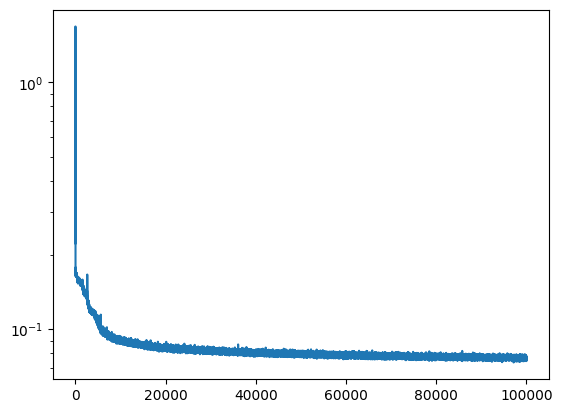

 33%|███▎      | 100115/300000 [20:27<46:11, 72.12it/s]

<bound method _item of Array(0.07559402, dtype=float32)>


 33%|███▎      | 100210/300000 [20:28<46:23, 71.79it/s]

<bound method _item of Array(0.07612588, dtype=float32)>


 33%|███▎      | 100314/300000 [20:30<47:01, 70.79it/s]

<bound method _item of Array(0.07606328, dtype=float32)>


 33%|███▎      | 100410/300000 [20:31<46:22, 71.72it/s]

<bound method _item of Array(0.07756265, dtype=float32)>


 34%|███▎      | 100514/300000 [20:32<48:36, 68.41it/s]

<bound method _item of Array(0.07779107, dtype=float32)>


 34%|███▎      | 100609/300000 [20:34<45:11, 73.54it/s]

<bound method _item of Array(0.07718514, dtype=float32)>


 34%|███▎      | 100713/300000 [20:35<45:07, 73.60it/s]

<bound method _item of Array(0.07680566, dtype=float32)>


 34%|███▎      | 100809/300000 [20:36<46:08, 71.94it/s]

<bound method _item of Array(0.0770313, dtype=float32)>


 34%|███▎      | 100913/300000 [20:38<46:15, 71.72it/s]

<bound method _item of Array(0.0767376, dtype=float32)>


 34%|███▎      | 101013/300000 [20:39<47:46, 69.41it/s]

<bound method _item of Array(0.07792738, dtype=float32)>


 34%|███▎      | 101114/300000 [20:41<47:41, 69.51it/s]

<bound method _item of Array(0.07491127, dtype=float32)>


 34%|███▎      | 101215/300000 [20:42<47:13, 70.15it/s]

<bound method _item of Array(0.07574746, dtype=float32)>


 34%|███▍      | 101310/300000 [20:44<47:18, 70.01it/s]

<bound method _item of Array(0.07702088, dtype=float32)>


 34%|███▍      | 101414/300000 [20:45<45:25, 72.86it/s]

<bound method _item of Array(0.07785176, dtype=float32)>


 34%|███▍      | 101510/300000 [20:46<45:45, 72.30it/s]

<bound method _item of Array(0.07552546, dtype=float32)>


 34%|███▍      | 101614/300000 [20:48<45:56, 71.98it/s]

<bound method _item of Array(0.07718002, dtype=float32)>


 34%|███▍      | 101710/300000 [20:49<44:58, 73.49it/s]

<bound method _item of Array(0.07628457, dtype=float32)>


 34%|███▍      | 101814/300000 [20:51<46:16, 71.39it/s]

<bound method _item of Array(0.07658892, dtype=float32)>


 34%|███▍      | 101914/300000 [20:52<48:14, 68.44it/s]

<bound method _item of Array(0.07589963, dtype=float32)>


 34%|███▍      | 102012/300000 [20:53<46:40, 70.71it/s]

<bound method _item of Array(0.07695293, dtype=float32)>


 34%|███▍      | 102108/300000 [20:55<45:42, 72.15it/s]

<bound method _item of Array(0.07718799, dtype=float32)>


 34%|███▍      | 102212/300000 [20:56<45:39, 72.21it/s]

<bound method _item of Array(0.07808904, dtype=float32)>


 34%|███▍      | 102314/300000 [20:58<47:26, 69.46it/s]

<bound method _item of Array(0.07586268, dtype=float32)>


 34%|███▍      | 102409/300000 [20:59<46:38, 70.60it/s]

<bound method _item of Array(0.07750481, dtype=float32)>


 34%|███▍      | 102512/300000 [21:00<46:47, 70.34it/s]

<bound method _item of Array(0.07625539, dtype=float32)>


 34%|███▍      | 102615/300000 [21:02<46:32, 70.70it/s]

<bound method _item of Array(0.07700597, dtype=float32)>


 34%|███▍      | 102713/300000 [21:03<46:57, 70.02it/s]

<bound method _item of Array(0.07493717, dtype=float32)>


 34%|███▍      | 102809/300000 [21:05<45:42, 71.91it/s]

<bound method _item of Array(0.07611932, dtype=float32)>


 34%|███▍      | 102913/300000 [21:06<45:25, 72.31it/s]

<bound method _item of Array(0.07730629, dtype=float32)>


 34%|███▍      | 103009/300000 [21:07<46:42, 70.29it/s]

<bound method _item of Array(0.07615558, dtype=float32)>


 34%|███▍      | 103113/300000 [21:09<45:10, 72.63it/s]

<bound method _item of Array(0.07684532, dtype=float32)>


 34%|███▍      | 103209/300000 [21:10<45:21, 72.32it/s]

<bound method _item of Array(0.07693729, dtype=float32)>


 34%|███▍      | 103313/300000 [21:12<44:21, 73.89it/s]

<bound method _item of Array(0.0758687, dtype=float32)>


 34%|███▍      | 103409/300000 [21:13<45:20, 72.25it/s]

<bound method _item of Array(0.07733424, dtype=float32)>


 35%|███▍      | 103513/300000 [21:14<46:19, 70.70it/s]

<bound method _item of Array(0.07680018, dtype=float32)>


 35%|███▍      | 103609/300000 [21:16<45:22, 72.13it/s]

<bound method _item of Array(0.07563, dtype=float32)>


 35%|███▍      | 103710/300000 [21:17<47:03, 69.53it/s]

<bound method _item of Array(0.0769571, dtype=float32)>


 35%|███▍      | 103815/300000 [21:19<46:11, 70.80it/s]

<bound method _item of Array(0.07773993, dtype=float32)>


 35%|███▍      | 103911/300000 [21:20<46:17, 70.61it/s]

<bound method _item of Array(0.07869406, dtype=float32)>


 35%|███▍      | 104015/300000 [21:22<45:15, 72.17it/s]

<bound method _item of Array(0.07632764, dtype=float32)>


 35%|███▍      | 104111/300000 [21:23<45:14, 72.18it/s]

<bound method _item of Array(0.07645815, dtype=float32)>


 35%|███▍      | 104215/300000 [21:24<45:29, 71.74it/s]

<bound method _item of Array(0.07611154, dtype=float32)>


 35%|███▍      | 104308/300000 [21:26<46:01, 70.87it/s]

<bound method _item of Array(0.0768014, dtype=float32)>


 35%|███▍      | 104414/300000 [21:27<48:13, 67.60it/s]

<bound method _item of Array(0.07648798, dtype=float32)>


 35%|███▍      | 104508/300000 [21:29<46:05, 70.68it/s]

<bound method _item of Array(0.07493809, dtype=float32)>


 35%|███▍      | 104612/300000 [21:30<45:14, 71.99it/s]

<bound method _item of Array(0.07620974, dtype=float32)>


 35%|███▍      | 104708/300000 [21:31<45:17, 71.86it/s]

<bound method _item of Array(0.07709093, dtype=float32)>


 35%|███▍      | 104812/300000 [21:33<46:02, 70.65it/s]

<bound method _item of Array(0.07602021, dtype=float32)>


 35%|███▍      | 104915/300000 [21:34<45:48, 70.97it/s]

<bound method _item of Array(0.07680355, dtype=float32)>


 35%|███▌      | 105011/300000 [21:36<45:59, 70.66it/s]

<bound method _item of Array(0.07524431, dtype=float32)>


 35%|███▌      | 105115/300000 [21:37<45:09, 71.93it/s]

<bound method _item of Array(0.07588986, dtype=float32)>


 35%|███▌      | 105211/300000 [21:38<46:29, 69.83it/s]

<bound method _item of Array(0.07757456, dtype=float32)>


 35%|███▌      | 105309/300000 [21:40<47:33, 68.23it/s]

<bound method _item of Array(0.07728918, dtype=float32)>


 35%|███▌      | 105414/300000 [21:41<47:08, 68.79it/s]

<bound method _item of Array(0.07732143, dtype=float32)>


 35%|███▌      | 105509/300000 [21:43<46:58, 68.99it/s]

<bound method _item of Array(0.07466973, dtype=float32)>


 35%|███▌      | 105612/300000 [21:44<45:13, 71.63it/s]

<bound method _item of Array(0.07547065, dtype=float32)>


 35%|███▌      | 105708/300000 [21:46<45:05, 71.82it/s]

<bound method _item of Array(0.07644174, dtype=float32)>


 35%|███▌      | 105812/300000 [21:47<44:01, 73.50it/s]

<bound method _item of Array(0.07695485, dtype=float32)>


 35%|███▌      | 105908/300000 [21:48<44:20, 72.95it/s]

<bound method _item of Array(0.07565956, dtype=float32)>


 35%|███▌      | 106012/300000 [21:50<45:35, 70.91it/s]

<bound method _item of Array(0.07852475, dtype=float32)>


 35%|███▌      | 106111/300000 [21:51<47:24, 68.16it/s]

<bound method _item of Array(0.07697322, dtype=float32)>


 35%|███▌      | 106208/300000 [21:53<47:25, 68.09it/s]

<bound method _item of Array(0.07557404, dtype=float32)>


 35%|███▌      | 106309/300000 [21:54<46:18, 69.70it/s]

<bound method _item of Array(0.07523122, dtype=float32)>


 35%|███▌      | 106409/300000 [21:55<44:54, 71.84it/s]

<bound method _item of Array(0.07654315, dtype=float32)>


 36%|███▌      | 106513/300000 [21:57<45:26, 70.98it/s]

<bound method _item of Array(0.07643316, dtype=float32)>


 36%|███▌      | 106614/300000 [21:58<47:26, 67.94it/s]

<bound method _item of Array(0.07600117, dtype=float32)>


 36%|███▌      | 106715/300000 [22:00<45:34, 70.68it/s]

<bound method _item of Array(0.07809045, dtype=float32)>


 36%|███▌      | 106811/300000 [22:01<45:25, 70.88it/s]

<bound method _item of Array(0.07511963, dtype=float32)>


 36%|███▌      | 106908/300000 [22:03<48:09, 66.82it/s]

<bound method _item of Array(0.07631397, dtype=float32)>


 36%|███▌      | 107010/300000 [22:04<46:03, 69.83it/s]

<bound method _item of Array(0.07531253, dtype=float32)>


 36%|███▌      | 107113/300000 [22:06<45:18, 70.95it/s]

<bound method _item of Array(0.07647072, dtype=float32)>


 36%|███▌      | 107209/300000 [22:07<44:36, 72.02it/s]

<bound method _item of Array(0.07532499, dtype=float32)>


 36%|███▌      | 107312/300000 [22:08<45:48, 70.12it/s]

<bound method _item of Array(0.07594956, dtype=float32)>


 36%|███▌      | 107414/300000 [22:10<45:57, 69.85it/s]

<bound method _item of Array(0.07587851, dtype=float32)>


 36%|███▌      | 107509/300000 [22:11<45:32, 70.45it/s]

<bound method _item of Array(0.07741693, dtype=float32)>


 36%|███▌      | 107611/300000 [22:13<47:51, 67.00it/s]

<bound method _item of Array(0.07701522, dtype=float32)>


 36%|███▌      | 107713/300000 [22:14<47:49, 67.01it/s]

<bound method _item of Array(0.07698443, dtype=float32)>


 36%|███▌      | 107813/300000 [22:16<47:15, 67.78it/s]

<bound method _item of Array(0.07793052, dtype=float32)>


 36%|███▌      | 107914/300000 [22:17<45:46, 69.94it/s]

<bound method _item of Array(0.07653075, dtype=float32)>


 36%|███▌      | 108008/300000 [22:18<45:43, 69.97it/s]

<bound method _item of Array(0.07715049, dtype=float32)>


 36%|███▌      | 108112/300000 [22:20<44:29, 71.88it/s]

<bound method _item of Array(0.0757907, dtype=float32)>


 36%|███▌      | 108208/300000 [22:21<44:25, 71.95it/s]

<bound method _item of Array(0.07672507, dtype=float32)>


 36%|███▌      | 108312/300000 [22:23<45:00, 70.98it/s]

<bound method _item of Array(0.07637905, dtype=float32)>


 36%|███▌      | 108408/300000 [22:24<44:47, 71.29it/s]

<bound method _item of Array(0.07442579, dtype=float32)>


 36%|███▌      | 108509/300000 [22:25<45:44, 69.76it/s]

<bound method _item of Array(0.07688314, dtype=float32)>


 36%|███▌      | 108613/300000 [22:27<45:20, 70.36it/s]

<bound method _item of Array(0.07575056, dtype=float32)>


 36%|███▌      | 108713/300000 [22:28<44:56, 70.94it/s]

<bound method _item of Array(0.07552382, dtype=float32)>


 36%|███▋      | 108809/300000 [22:30<44:57, 70.88it/s]

<bound method _item of Array(0.07677414, dtype=float32)>


 36%|███▋      | 108913/300000 [22:31<46:36, 68.32it/s]

<bound method _item of Array(0.07573994, dtype=float32)>


 36%|███▋      | 109011/300000 [22:33<45:42, 69.64it/s]

<bound method _item of Array(0.07616474, dtype=float32)>


 36%|███▋      | 109114/300000 [22:34<44:26, 71.59it/s]

<bound method _item of Array(0.07589155, dtype=float32)>


 36%|███▋      | 109210/300000 [22:35<44:47, 71.00it/s]

<bound method _item of Array(0.07567481, dtype=float32)>


 36%|███▋      | 109314/300000 [22:37<43:54, 72.39it/s]

<bound method _item of Array(0.07654157, dtype=float32)>


 36%|███▋      | 109413/300000 [22:38<45:13, 70.23it/s]

<bound method _item of Array(0.07707432, dtype=float32)>


 37%|███▋      | 109510/300000 [22:40<45:27, 69.85it/s]

<bound method _item of Array(0.07773991, dtype=float32)>


 37%|███▋      | 109612/300000 [22:41<44:27, 71.36it/s]

<bound method _item of Array(0.07679079, dtype=float32)>


 37%|███▋      | 109708/300000 [22:42<47:03, 67.40it/s]

<bound method _item of Array(0.07740664, dtype=float32)>


 37%|███▋      | 109811/300000 [22:44<44:12, 71.70it/s]

<bound method _item of Array(0.07549062, dtype=float32)>


 37%|███▋      | 109915/300000 [22:45<45:06, 70.24it/s]

<bound method _item of Array(0.07513393, dtype=float32)>


 37%|███▋      | 109995/300000 [22:47<45:08, 70.14it/s]

<bound method _item of Array(0.07726726, dtype=float32)>


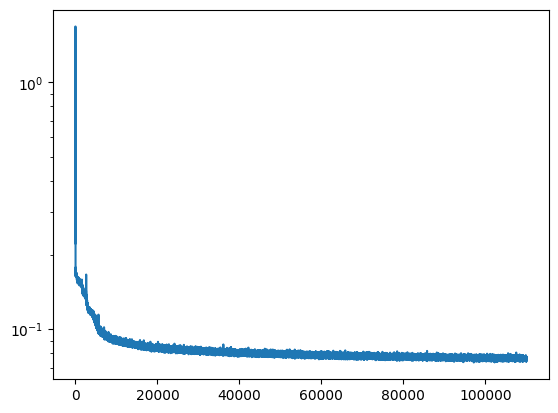

 37%|███▋      | 110110/300000 [22:48<45:53, 68.95it/s]

<bound method _item of Array(0.07597163, dtype=float32)>


 37%|███▋      | 110210/300000 [22:50<46:20, 68.26it/s]

<bound method _item of Array(0.07632, dtype=float32)>


 37%|███▋      | 110308/300000 [22:51<47:09, 67.03it/s]

<bound method _item of Array(0.07700939, dtype=float32)>


 37%|███▋      | 110414/300000 [22:53<46:23, 68.12it/s]

<bound method _item of Array(0.07545999, dtype=float32)>


 37%|███▋      | 110511/300000 [22:54<45:16, 69.77it/s]

<bound method _item of Array(0.07663809, dtype=float32)>


 37%|███▋      | 110610/300000 [22:56<45:17, 69.69it/s]

<bound method _item of Array(0.0752156, dtype=float32)>


 37%|███▋      | 110712/300000 [22:57<44:50, 70.35it/s]

<bound method _item of Array(0.07585907, dtype=float32)>


 37%|███▋      | 110811/300000 [22:59<45:35, 69.16it/s]

<bound method _item of Array(0.07639542, dtype=float32)>


 37%|███▋      | 110909/300000 [23:00<44:42, 70.49it/s]

<bound method _item of Array(0.07638925, dtype=float32)>


 37%|███▋      | 111014/300000 [23:02<46:39, 67.50it/s]

<bound method _item of Array(0.07538195, dtype=float32)>


 37%|███▋      | 111112/300000 [23:03<46:48, 67.25it/s]

<bound method _item of Array(0.07706955, dtype=float32)>


 37%|███▋      | 111213/300000 [23:04<45:40, 68.88it/s]

<bound method _item of Array(0.0750014, dtype=float32)>


 37%|███▋      | 111313/300000 [23:06<44:52, 70.07it/s]

<bound method _item of Array(0.0759039, dtype=float32)>


 37%|███▋      | 111409/300000 [23:07<44:32, 70.56it/s]

<bound method _item of Array(0.07539375, dtype=float32)>


 37%|███▋      | 111510/300000 [23:09<44:27, 70.67it/s]

<bound method _item of Array(0.07644636, dtype=float32)>


 37%|███▋      | 111614/300000 [23:10<44:31, 70.52it/s]

<bound method _item of Array(0.07640199, dtype=float32)>


 37%|███▋      | 111712/300000 [23:12<44:57, 69.80it/s]

<bound method _item of Array(0.07756858, dtype=float32)>


 37%|███▋      | 111808/300000 [23:13<46:33, 67.37it/s]

<bound method _item of Array(0.07740092, dtype=float32)>


 37%|███▋      | 111913/300000 [23:15<48:26, 64.71it/s]

<bound method _item of Array(0.07602043, dtype=float32)>


 37%|███▋      | 112011/300000 [23:16<47:03, 66.57it/s]

<bound method _item of Array(0.07692037, dtype=float32)>


 37%|███▋      | 112113/300000 [23:18<46:50, 66.85it/s]

<bound method _item of Array(0.07712065, dtype=float32)>


 37%|███▋      | 112215/300000 [23:19<44:36, 70.17it/s]

<bound method _item of Array(0.07610611, dtype=float32)>


 37%|███▋      | 112308/300000 [23:20<45:27, 68.82it/s]

<bound method _item of Array(0.07631087, dtype=float32)>


 37%|███▋      | 112413/300000 [23:22<44:53, 69.64it/s]

<bound method _item of Array(0.07738014, dtype=float32)>


 38%|███▊      | 112510/300000 [23:23<44:57, 69.50it/s]

<bound method _item of Array(0.07510941, dtype=float32)>


 38%|███▊      | 112610/300000 [23:25<46:25, 67.28it/s]

<bound method _item of Array(0.07441293, dtype=float32)>


 38%|███▊      | 112708/300000 [23:26<46:13, 67.52it/s]

<bound method _item of Array(0.07659974, dtype=float32)>


 38%|███▊      | 112814/300000 [23:28<46:04, 67.71it/s]

<bound method _item of Array(0.07565241, dtype=float32)>


 38%|███▊      | 112912/300000 [23:29<45:03, 69.21it/s]

<bound method _item of Array(0.07614375, dtype=float32)>


 38%|███▊      | 113008/300000 [23:31<44:21, 70.25it/s]

<bound method _item of Array(0.07629783, dtype=float32)>


 38%|███▊      | 113112/300000 [23:32<44:14, 70.41it/s]

<bound method _item of Array(0.07674035, dtype=float32)>


 38%|███▊      | 113208/300000 [23:33<43:49, 71.03it/s]

<bound method _item of Array(0.07551166, dtype=float32)>


 38%|███▊      | 113312/300000 [23:35<44:29, 69.94it/s]

<bound method _item of Array(0.07540156, dtype=float32)>


 38%|███▊      | 113410/300000 [23:36<46:11, 67.32it/s]

<bound method _item of Array(0.07567465, dtype=float32)>


 38%|███▊      | 113508/300000 [23:38<46:50, 66.36it/s]

<bound method _item of Array(0.07762923, dtype=float32)>


 38%|███▊      | 113610/300000 [23:39<44:06, 70.44it/s]

<bound method _item of Array(0.0766611, dtype=float32)>


 38%|███▊      | 113712/300000 [23:41<44:15, 70.16it/s]

<bound method _item of Array(0.07524238, dtype=float32)>


 38%|███▊      | 113811/300000 [23:42<44:47, 69.27it/s]

<bound method _item of Array(0.07660197, dtype=float32)>


 38%|███▊      | 113913/300000 [23:44<44:15, 70.07it/s]

<bound method _item of Array(0.07558307, dtype=float32)>


 38%|███▊      | 114008/300000 [23:45<45:13, 68.55it/s]

<bound method _item of Array(0.07684377, dtype=float32)>


 38%|███▊      | 114114/300000 [23:47<45:03, 68.75it/s]

<bound method _item of Array(0.07464369, dtype=float32)>


 38%|███▊      | 114208/300000 [23:48<45:43, 67.71it/s]

<bound method _item of Array(0.07486323, dtype=float32)>


 38%|███▊      | 114313/300000 [23:49<46:15, 66.89it/s]

<bound method _item of Array(0.07681043, dtype=float32)>


 38%|███▊      | 114411/300000 [23:51<45:23, 68.15it/s]

<bound method _item of Array(0.07605498, dtype=float32)>


 38%|███▊      | 114510/300000 [23:52<46:28, 66.51it/s]

<bound method _item of Array(0.07509003, dtype=float32)>


 38%|███▊      | 114610/300000 [23:54<45:20, 68.14it/s]

<bound method _item of Array(0.07512891, dtype=float32)>


 38%|███▊      | 114714/300000 [23:55<44:37, 69.21it/s]

<bound method _item of Array(0.07623769, dtype=float32)>


 38%|███▊      | 114814/300000 [23:57<45:20, 68.07it/s]

<bound method _item of Array(0.07668446, dtype=float32)>


 38%|███▊      | 114913/300000 [23:58<44:42, 68.99it/s]

<bound method _item of Array(0.07613632, dtype=float32)>


 38%|███▊      | 115012/300000 [24:00<45:41, 67.47it/s]

<bound method _item of Array(0.07557502, dtype=float32)>


 38%|███▊      | 115110/300000 [24:01<45:16, 68.05it/s]

<bound method _item of Array(0.07713423, dtype=float32)>


 38%|███▊      | 115208/300000 [24:03<48:18, 63.75it/s]

<bound method _item of Array(0.07603201, dtype=float32)>


 38%|███▊      | 115313/300000 [24:04<44:57, 68.46it/s]

<bound method _item of Array(0.07647888, dtype=float32)>


 38%|███▊      | 115411/300000 [24:06<45:56, 66.95it/s]

<bound method _item of Array(0.07678669, dtype=float32)>


 39%|███▊      | 115509/300000 [24:07<45:46, 67.17it/s]

<bound method _item of Array(0.07342046, dtype=float32)>


 39%|███▊      | 115614/300000 [24:09<45:12, 67.99it/s]

<bound method _item of Array(0.07579601, dtype=float32)>


 39%|███▊      | 115712/300000 [24:10<46:04, 66.67it/s]

<bound method _item of Array(0.0767084, dtype=float32)>


 39%|███▊      | 115813/300000 [24:12<43:59, 69.78it/s]

<bound method _item of Array(0.07513992, dtype=float32)>


 39%|███▊      | 115912/300000 [24:13<45:56, 66.79it/s]

<bound method _item of Array(0.07616121, dtype=float32)>


 39%|███▊      | 116010/300000 [24:15<45:44, 67.05it/s]

<bound method _item of Array(0.07589129, dtype=float32)>


 39%|███▊      | 116113/300000 [24:16<43:11, 70.95it/s]

<bound method _item of Array(0.07590588, dtype=float32)>


 39%|███▊      | 116210/300000 [24:17<46:15, 66.23it/s]

<bound method _item of Array(0.07501914, dtype=float32)>


 39%|███▉      | 116314/300000 [24:19<43:32, 70.31it/s]

<bound method _item of Array(0.07736416, dtype=float32)>


 39%|███▉      | 116411/300000 [24:20<44:54, 68.14it/s]

<bound method _item of Array(0.07580577, dtype=float32)>


 39%|███▉      | 116512/300000 [24:22<43:53, 69.67it/s]

<bound method _item of Array(0.07535605, dtype=float32)>


 39%|███▉      | 116608/300000 [24:23<44:28, 68.72it/s]

<bound method _item of Array(0.07525578, dtype=float32)>


 39%|███▉      | 116713/300000 [24:25<45:51, 66.62it/s]

<bound method _item of Array(0.07615868, dtype=float32)>


 39%|███▉      | 116811/300000 [24:26<45:33, 67.01it/s]

<bound method _item of Array(0.07763038, dtype=float32)>


 39%|███▉      | 116911/300000 [24:28<44:32, 68.51it/s]

<bound method _item of Array(0.07528242, dtype=float32)>


 39%|███▉      | 117009/300000 [24:29<44:53, 67.94it/s]

<bound method _item of Array(0.07501084, dtype=float32)>


 39%|███▉      | 117114/300000 [24:31<45:14, 67.37it/s]

<bound method _item of Array(0.07539698, dtype=float32)>


 39%|███▉      | 117212/300000 [24:32<44:56, 67.78it/s]

<bound method _item of Array(0.07629129, dtype=float32)>


 39%|███▉      | 117310/300000 [24:34<45:14, 67.29it/s]

<bound method _item of Array(0.07537431, dtype=float32)>


 39%|███▉      | 117408/300000 [24:35<45:06, 67.47it/s]

<bound method _item of Array(0.07460134, dtype=float32)>


 39%|███▉      | 117513/300000 [24:37<45:50, 66.34it/s]

<bound method _item of Array(0.076989, dtype=float32)>


 39%|███▉      | 117611/300000 [24:38<45:21, 67.02it/s]

<bound method _item of Array(0.07621817, dtype=float32)>


 39%|███▉      | 117708/300000 [24:40<44:07, 68.86it/s]

<bound method _item of Array(0.0758955, dtype=float32)>


 39%|███▉      | 117810/300000 [24:41<43:54, 69.15it/s]

<bound method _item of Array(0.0746802, dtype=float32)>


 39%|███▉      | 117908/300000 [24:42<45:33, 66.62it/s]

<bound method _item of Array(0.07530329, dtype=float32)>


 39%|███▉      | 118013/300000 [24:44<43:15, 70.13it/s]

<bound method _item of Array(0.07527312, dtype=float32)>


 39%|███▉      | 118114/300000 [24:45<43:11, 70.17it/s]

<bound method _item of Array(0.07711031, dtype=float32)>


 39%|███▉      | 118214/300000 [24:47<44:28, 68.13it/s]

<bound method _item of Array(0.07536234, dtype=float32)>


 39%|███▉      | 118312/300000 [24:48<45:28, 66.59it/s]

<bound method _item of Array(0.07618518, dtype=float32)>


 39%|███▉      | 118410/300000 [24:50<45:16, 66.84it/s]

<bound method _item of Array(0.0758815, dtype=float32)>


 40%|███▉      | 118508/300000 [24:51<45:15, 66.83it/s]

<bound method _item of Array(0.07633586, dtype=float32)>


 40%|███▉      | 118608/300000 [24:53<44:28, 67.97it/s]

<bound method _item of Array(0.07407159, dtype=float32)>


 40%|███▉      | 118709/300000 [24:54<43:48, 68.98it/s]

<bound method _item of Array(0.07687231, dtype=float32)>


 40%|███▉      | 118814/300000 [24:56<43:40, 69.15it/s]

<bound method _item of Array(0.07719298, dtype=float32)>


 40%|███▉      | 118912/300000 [24:57<44:13, 68.25it/s]

<bound method _item of Array(0.07608135, dtype=float32)>


 40%|███▉      | 119010/300000 [24:59<45:14, 66.67it/s]

<bound method _item of Array(0.07555658, dtype=float32)>


 40%|███▉      | 119108/300000 [25:00<45:17, 66.57it/s]

<bound method _item of Array(0.07661042, dtype=float32)>


 40%|███▉      | 119213/300000 [25:02<45:36, 66.06it/s]

<bound method _item of Array(0.07433826, dtype=float32)>


 40%|███▉      | 119311/300000 [25:03<44:31, 67.63it/s]

<bound method _item of Array(0.07515844, dtype=float32)>


 40%|███▉      | 119409/300000 [25:05<43:48, 68.72it/s]

<bound method _item of Array(0.07524575, dtype=float32)>


 40%|███▉      | 119508/300000 [25:06<43:28, 69.20it/s]

<bound method _item of Array(0.07722376, dtype=float32)>


 40%|███▉      | 119609/300000 [25:08<45:00, 66.79it/s]

<bound method _item of Array(0.07654715, dtype=float32)>


 40%|███▉      | 119715/300000 [25:09<43:44, 68.68it/s]

<bound method _item of Array(0.07533025, dtype=float32)>


 40%|███▉      | 119813/300000 [25:10<44:16, 67.83it/s]

<bound method _item of Array(0.07606585, dtype=float32)>


 40%|███▉      | 119911/300000 [25:12<45:34, 65.85it/s]

<bound method _item of Array(0.07696591, dtype=float32)>


 40%|███▉      | 119995/300000 [25:13<45:06, 66.52it/s]

<bound method _item of Array(0.07647473, dtype=float32)>


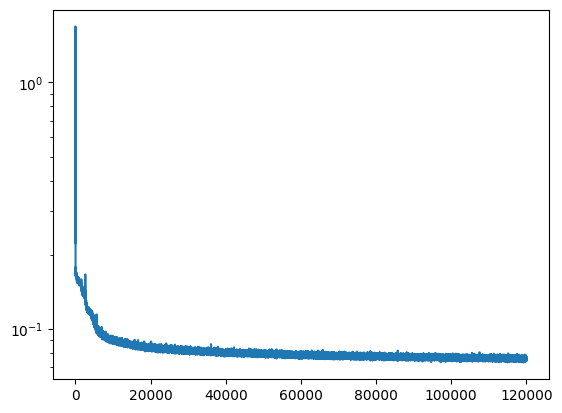

 40%|████      | 120108/300000 [25:15<43:21, 69.14it/s]

<bound method _item of Array(0.07638878, dtype=float32)>


 40%|████      | 120214/300000 [25:17<43:38, 68.66it/s]

<bound method _item of Array(0.07655571, dtype=float32)>


 40%|████      | 120314/300000 [25:18<43:45, 68.45it/s]

<bound method _item of Array(0.07616091, dtype=float32)>


 40%|████      | 120412/300000 [25:20<43:52, 68.22it/s]

<bound method _item of Array(0.0772538, dtype=float32)>


 40%|████      | 120510/300000 [25:21<43:51, 68.22it/s]

<bound method _item of Array(0.07669429, dtype=float32)>


 40%|████      | 120608/300000 [25:22<45:54, 65.13it/s]

<bound method _item of Array(0.07653044, dtype=float32)>


 40%|████      | 120713/300000 [25:24<43:53, 68.08it/s]

<bound method _item of Array(0.07395902, dtype=float32)>


 40%|████      | 120811/300000 [25:25<44:22, 67.29it/s]

<bound method _item of Array(0.07600498, dtype=float32)>


 40%|████      | 120909/300000 [25:27<43:41, 68.31it/s]

<bound method _item of Array(0.07488698, dtype=float32)>


 40%|████      | 121009/300000 [25:28<43:41, 68.29it/s]

<bound method _item of Array(0.07632609, dtype=float32)>


 40%|████      | 121108/300000 [25:30<43:11, 69.02it/s]

<bound method _item of Array(0.07585202, dtype=float32)>


 40%|████      | 121213/300000 [25:31<43:46, 68.08it/s]

<bound method _item of Array(0.07549401, dtype=float32)>


 40%|████      | 121311/300000 [25:33<44:36, 66.77it/s]

<bound method _item of Array(0.07500543, dtype=float32)>


 40%|████      | 121409/300000 [25:34<45:56, 64.80it/s]

<bound method _item of Array(0.07425453, dtype=float32)>


 41%|████      | 121514/300000 [25:36<44:33, 66.77it/s]

<bound method _item of Array(0.07642966, dtype=float32)>


 41%|████      | 121612/300000 [25:37<44:15, 67.17it/s]

<bound method _item of Array(0.07440057, dtype=float32)>


 41%|████      | 121711/300000 [25:39<43:36, 68.13it/s]

<bound method _item of Array(0.07518087, dtype=float32)>


 41%|████      | 121811/300000 [25:40<42:59, 69.08it/s]

<bound method _item of Array(0.07521085, dtype=float32)>


 41%|████      | 121910/300000 [25:42<43:56, 67.54it/s]

<bound method _item of Array(0.0760526, dtype=float32)>


 41%|████      | 122008/300000 [25:43<43:47, 67.73it/s]

<bound method _item of Array(0.07470821, dtype=float32)>


 41%|████      | 122113/300000 [25:45<43:59, 67.40it/s]

<bound method _item of Array(0.07595539, dtype=float32)>


 41%|████      | 122211/300000 [25:46<43:51, 67.57it/s]

<bound method _item of Array(0.07698274, dtype=float32)>


 41%|████      | 122309/300000 [25:48<46:15, 64.03it/s]

<bound method _item of Array(0.07598435, dtype=float32)>


 41%|████      | 122407/300000 [25:49<45:55, 64.46it/s]

<bound method _item of Array(0.07633274, dtype=float32)>


 41%|████      | 122512/300000 [25:51<44:44, 66.11it/s]

<bound method _item of Array(0.07465981, dtype=float32)>


 41%|████      | 122610/300000 [25:52<43:44, 67.58it/s]

<bound method _item of Array(0.07556271, dtype=float32)>


 41%|████      | 122708/300000 [25:54<43:31, 67.89it/s]

<bound method _item of Array(0.07665996, dtype=float32)>


 41%|████      | 122813/300000 [25:55<44:00, 67.09it/s]

<bound method _item of Array(0.0758972, dtype=float32)>


 41%|████      | 122911/300000 [25:57<43:09, 68.37it/s]

<bound method _item of Array(0.07415655, dtype=float32)>


 41%|████      | 123009/300000 [25:58<43:26, 67.90it/s]

<bound method _item of Array(0.07539208, dtype=float32)>


 41%|████      | 123114/300000 [26:00<45:14, 65.16it/s]

<bound method _item of Array(0.077006, dtype=float32)>


 41%|████      | 123212/300000 [26:01<45:36, 64.59it/s]

<bound method _item of Array(0.07536817, dtype=float32)>


 41%|████      | 123310/300000 [26:03<44:41, 65.90it/s]

<bound method _item of Array(0.07529669, dtype=float32)>


 41%|████      | 123408/300000 [26:04<43:29, 67.67it/s]

<bound method _item of Array(0.07387581, dtype=float32)>


 41%|████      | 123513/300000 [26:06<43:30, 67.60it/s]

<bound method _item of Array(0.07638328, dtype=float32)>


 41%|████      | 123611/300000 [26:07<43:43, 67.24it/s]

<bound method _item of Array(0.07388759, dtype=float32)>


 41%|████      | 123709/300000 [26:09<43:45, 67.15it/s]

<bound method _item of Array(0.07486218, dtype=float32)>


 41%|████▏     | 123814/300000 [26:10<45:09, 65.02it/s]

<bound method _item of Array(0.07591734, dtype=float32)>


 41%|████▏     | 123912/300000 [26:12<44:58, 65.25it/s]

<bound method _item of Array(0.07528549, dtype=float32)>


 41%|████▏     | 124010/300000 [26:13<44:12, 66.34it/s]

<bound method _item of Array(0.07558219, dtype=float32)>


 41%|████▏     | 124108/300000 [26:15<43:57, 66.69it/s]

<bound method _item of Array(0.07650011, dtype=float32)>


 41%|████▏     | 124213/300000 [26:16<43:40, 67.08it/s]

<bound method _item of Array(0.07550269, dtype=float32)>


 41%|████▏     | 124311/300000 [26:18<44:10, 66.28it/s]

<bound method _item of Array(0.0749725, dtype=float32)>


 41%|████▏     | 124409/300000 [26:19<43:51, 66.74it/s]

<bound method _item of Array(0.07447428, dtype=float32)>


 42%|████▏     | 124507/300000 [26:21<44:43, 65.40it/s]

<bound method _item of Array(0.07721201, dtype=float32)>


 42%|████▏     | 124612/300000 [26:22<48:34, 60.18it/s]

<bound method _item of Array(0.07547936, dtype=float32)>


 42%|████▏     | 124710/300000 [26:24<45:15, 64.55it/s]

<bound method _item of Array(0.0758204, dtype=float32)>


 42%|████▏     | 124808/300000 [26:26<43:52, 66.55it/s]

<bound method _item of Array(0.07508788, dtype=float32)>


 42%|████▏     | 124906/300000 [26:27<44:12, 66.01it/s]

<bound method _item of Array(0.07549003, dtype=float32)>


 42%|████▏     | 125011/300000 [26:29<44:03, 66.19it/s]

<bound method _item of Array(0.07452812, dtype=float32)>


 42%|████▏     | 125109/300000 [26:30<44:06, 66.10it/s]

<bound method _item of Array(0.07647405, dtype=float32)>


 42%|████▏     | 125214/300000 [26:32<43:31, 66.94it/s]

<bound method _item of Array(0.07574334, dtype=float32)>


 42%|████▏     | 125312/300000 [26:33<43:42, 66.61it/s]

<bound method _item of Array(0.07617183, dtype=float32)>


 42%|████▏     | 125410/300000 [26:35<45:05, 64.52it/s]

<bound method _item of Array(0.076716, dtype=float32)>


 42%|████▏     | 125508/300000 [26:36<44:11, 65.80it/s]

<bound method _item of Array(0.07562377, dtype=float32)>


 42%|████▏     | 125613/300000 [26:38<43:51, 66.28it/s]

<bound method _item of Array(0.07551499, dtype=float32)>


 42%|████▏     | 125711/300000 [26:39<42:40, 68.06it/s]

<bound method _item of Array(0.07687803, dtype=float32)>


 42%|████▏     | 125809/300000 [26:41<43:12, 67.18it/s]

<bound method _item of Array(0.07552718, dtype=float32)>


 42%|████▏     | 125914/300000 [26:42<42:56, 67.57it/s]

<bound method _item of Array(0.07452285, dtype=float32)>


 42%|████▏     | 126012/300000 [26:44<44:10, 65.65it/s]

<bound method _item of Array(0.07607394, dtype=float32)>


 42%|████▏     | 126110/300000 [26:45<43:18, 66.91it/s]

<bound method _item of Array(0.07712306, dtype=float32)>


 42%|████▏     | 126208/300000 [26:47<44:34, 64.97it/s]

<bound method _item of Array(0.076647, dtype=float32)>


 42%|████▏     | 126313/300000 [26:48<43:34, 66.44it/s]

<bound method _item of Array(0.07532085, dtype=float32)>


 42%|████▏     | 126411/300000 [26:50<43:40, 66.25it/s]

<bound method _item of Array(0.07579757, dtype=float32)>


 42%|████▏     | 126509/300000 [26:51<44:18, 65.25it/s]

<bound method _item of Array(0.07574376, dtype=float32)>


 42%|████▏     | 126614/300000 [26:53<44:08, 65.47it/s]

<bound method _item of Array(0.07537062, dtype=float32)>


 42%|████▏     | 126712/300000 [26:54<43:32, 66.33it/s]

<bound method _item of Array(0.07650352, dtype=float32)>


 42%|████▏     | 126810/300000 [26:56<44:58, 64.17it/s]

<bound method _item of Array(0.07493602, dtype=float32)>


 42%|████▏     | 126908/300000 [26:57<44:10, 65.29it/s]

<bound method _item of Array(0.07582749, dtype=float32)>


 42%|████▏     | 127013/300000 [26:59<45:11, 63.80it/s]

<bound method _item of Array(0.07515983, dtype=float32)>


 42%|████▏     | 127111/300000 [27:00<44:50, 64.25it/s]

<bound method _item of Array(0.07604714, dtype=float32)>


 42%|████▏     | 127209/300000 [27:02<44:01, 65.41it/s]

<bound method _item of Array(0.07553895, dtype=float32)>


 42%|████▏     | 127314/300000 [27:04<43:57, 65.46it/s]

<bound method _item of Array(0.07571165, dtype=float32)>


 42%|████▏     | 127412/300000 [27:05<43:48, 65.66it/s]

<bound method _item of Array(0.07612367, dtype=float32)>


 43%|████▎     | 127510/300000 [27:07<44:11, 65.05it/s]

<bound method _item of Array(0.07548956, dtype=float32)>


 43%|████▎     | 127608/300000 [27:08<43:57, 65.35it/s]

<bound method _item of Array(0.07540953, dtype=float32)>


 43%|████▎     | 127713/300000 [27:10<44:57, 63.86it/s]

<bound method _item of Array(0.07651787, dtype=float32)>


 43%|████▎     | 127811/300000 [27:11<44:00, 65.20it/s]

<bound method _item of Array(0.07422436, dtype=float32)>


 43%|████▎     | 127909/300000 [27:13<44:16, 64.77it/s]

<bound method _item of Array(0.07496869, dtype=float32)>


 43%|████▎     | 128014/300000 [27:14<42:47, 66.99it/s]

<bound method _item of Array(0.07510105, dtype=float32)>


 43%|████▎     | 128112/300000 [27:16<42:54, 66.76it/s]

<bound method _item of Array(0.07570687, dtype=float32)>


 43%|████▎     | 128210/300000 [27:17<42:07, 67.96it/s]

<bound method _item of Array(0.07477716, dtype=float32)>


 43%|████▎     | 128308/300000 [27:19<42:41, 67.02it/s]

<bound method _item of Array(0.07431606, dtype=float32)>


 43%|████▎     | 128413/300000 [27:20<42:27, 67.35it/s]

<bound method _item of Array(0.07619312, dtype=float32)>


 43%|████▎     | 128511/300000 [27:22<44:02, 64.91it/s]

<bound method _item of Array(0.0758274, dtype=float32)>


 43%|████▎     | 128609/300000 [27:23<44:35, 64.06it/s]

<bound method _item of Array(0.07516592, dtype=float32)>


 43%|████▎     | 128714/300000 [27:25<42:58, 66.44it/s]

<bound method _item of Array(0.07440416, dtype=float32)>


 43%|████▎     | 128812/300000 [27:26<43:54, 64.98it/s]

<bound method _item of Array(0.07454599, dtype=float32)>


 43%|████▎     | 128910/300000 [27:28<43:47, 65.11it/s]

<bound method _item of Array(0.07478056, dtype=float32)>


 43%|████▎     | 129008/300000 [27:29<43:27, 65.57it/s]

<bound method _item of Array(0.07561105, dtype=float32)>


 43%|████▎     | 129113/300000 [27:31<42:51, 66.46it/s]

<bound method _item of Array(0.07567039, dtype=float32)>


 43%|████▎     | 129211/300000 [27:32<43:08, 65.99it/s]

<bound method _item of Array(0.07594342, dtype=float32)>


 43%|████▎     | 129309/300000 [27:34<44:02, 64.60it/s]

<bound method _item of Array(0.07491599, dtype=float32)>


 43%|████▎     | 129414/300000 [27:36<43:29, 65.37it/s]

<bound method _item of Array(0.07391682, dtype=float32)>


 43%|████▎     | 129512/300000 [27:37<44:01, 64.55it/s]

<bound method _item of Array(0.07454306, dtype=float32)>


 43%|████▎     | 129610/300000 [27:39<43:03, 65.94it/s]

<bound method _item of Array(0.07703856, dtype=float32)>


 43%|████▎     | 129708/300000 [27:40<42:40, 66.52it/s]

<bound method _item of Array(0.07521562, dtype=float32)>


 43%|████▎     | 129813/300000 [27:42<42:07, 67.33it/s]

<bound method _item of Array(0.0772523, dtype=float32)>


 43%|████▎     | 129911/300000 [27:43<42:47, 66.25it/s]

<bound method _item of Array(0.07659544, dtype=float32)>


 43%|████▎     | 129995/300000 [27:44<42:47, 66.20it/s]

<bound method _item of Array(0.07520312, dtype=float32)>


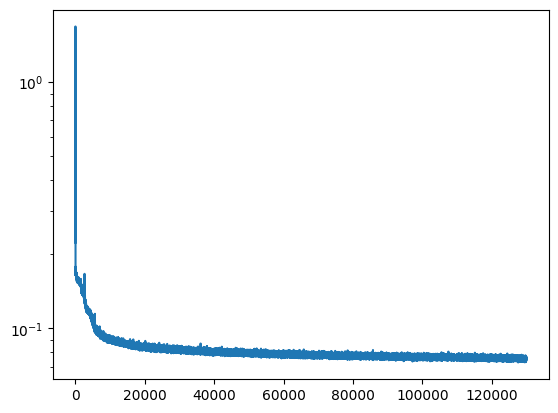

 43%|████▎     | 130107/300000 [27:46<44:13, 64.03it/s]

<bound method _item of Array(0.07606721, dtype=float32)>


 43%|████▎     | 130212/300000 [27:48<45:09, 62.66it/s]

<bound method _item of Array(0.07470941, dtype=float32)>


 43%|████▎     | 130310/300000 [27:49<43:16, 65.35it/s]

<bound method _item of Array(0.07589062, dtype=float32)>


 43%|████▎     | 130408/300000 [27:51<43:08, 65.53it/s]

<bound method _item of Array(0.07491016, dtype=float32)>


 44%|████▎     | 130513/300000 [27:53<44:17, 63.77it/s]

<bound method _item of Array(0.07569208, dtype=float32)>


 44%|████▎     | 130611/300000 [27:54<42:30, 66.42it/s]

<bound method _item of Array(0.07503445, dtype=float32)>


 44%|████▎     | 130709/300000 [27:56<42:42, 66.06it/s]

<bound method _item of Array(0.07307766, dtype=float32)>


 44%|████▎     | 130807/300000 [27:57<43:47, 64.39it/s]

<bound method _item of Array(0.07530952, dtype=float32)>


 44%|████▎     | 130912/300000 [27:59<43:19, 65.05it/s]

<bound method _item of Array(0.07552078, dtype=float32)>


 44%|████▎     | 131010/300000 [28:00<42:55, 65.62it/s]

<bound method _item of Array(0.07496601, dtype=float32)>


 44%|████▎     | 131108/300000 [28:02<43:53, 64.14it/s]

<bound method _item of Array(0.07451285, dtype=float32)>


 44%|████▎     | 131213/300000 [28:03<42:08, 66.76it/s]

<bound method _item of Array(0.07593206, dtype=float32)>


 44%|████▍     | 131311/300000 [28:05<42:48, 65.69it/s]

<bound method _item of Array(0.07511473, dtype=float32)>


 44%|████▍     | 131409/300000 [28:06<42:15, 66.50it/s]

<bound method _item of Array(0.07654154, dtype=float32)>


 44%|████▍     | 131514/300000 [28:08<42:48, 65.60it/s]

<bound method _item of Array(0.07495118, dtype=float32)>


 44%|████▍     | 131612/300000 [28:09<43:53, 63.94it/s]

<bound method _item of Array(0.07438218, dtype=float32)>


 44%|████▍     | 131710/300000 [28:11<43:37, 64.30it/s]

<bound method _item of Array(0.07446533, dtype=float32)>


 44%|████▍     | 131808/300000 [28:12<42:57, 65.26it/s]

<bound method _item of Array(0.07622617, dtype=float32)>


 44%|████▍     | 131913/300000 [28:14<42:52, 65.35it/s]

<bound method _item of Array(0.07590161, dtype=float32)>


 44%|████▍     | 132011/300000 [28:16<42:56, 65.20it/s]

<bound method _item of Array(0.07436396, dtype=float32)>


 44%|████▍     | 132109/300000 [28:17<42:37, 65.64it/s]

<bound method _item of Array(0.0769283, dtype=float32)>


 44%|████▍     | 132214/300000 [28:19<42:42, 65.48it/s]

<bound method _item of Array(0.07455279, dtype=float32)>


 44%|████▍     | 132312/300000 [28:20<43:49, 63.78it/s]

<bound method _item of Array(0.0751308, dtype=float32)>


 44%|████▍     | 132410/300000 [28:22<46:05, 60.60it/s]

<bound method _item of Array(0.07457645, dtype=float32)>


 44%|████▍     | 132508/300000 [28:23<44:34, 62.62it/s]

<bound method _item of Array(0.0754661, dtype=float32)>


 44%|████▍     | 132613/300000 [28:25<43:50, 63.64it/s]

<bound method _item of Array(0.07470278, dtype=float32)>


 44%|████▍     | 132711/300000 [28:26<44:01, 63.33it/s]

<bound method _item of Array(0.07538424, dtype=float32)>


 44%|████▍     | 132809/300000 [28:28<43:03, 64.73it/s]

<bound method _item of Array(0.07468428, dtype=float32)>


 44%|████▍     | 132914/300000 [28:30<42:20, 65.76it/s]

<bound method _item of Array(0.07508977, dtype=float32)>


 44%|████▍     | 133012/300000 [28:31<42:31, 65.45it/s]

<bound method _item of Array(0.07461344, dtype=float32)>


 44%|████▍     | 133110/300000 [28:33<45:13, 61.50it/s]

<bound method _item of Array(0.07655462, dtype=float32)>


 44%|████▍     | 133208/300000 [28:34<43:07, 64.47it/s]

<bound method _item of Array(0.07561081, dtype=float32)>


 44%|████▍     | 133313/300000 [28:36<41:45, 66.53it/s]

<bound method _item of Array(0.07643051, dtype=float32)>


 44%|████▍     | 133411/300000 [28:37<42:07, 65.92it/s]

<bound method _item of Array(0.07500558, dtype=float32)>


 45%|████▍     | 133509/300000 [28:39<41:25, 66.97it/s]

<bound method _item of Array(0.07566709, dtype=float32)>


 45%|████▍     | 133614/300000 [28:40<41:45, 66.41it/s]

<bound method _item of Array(0.07433965, dtype=float32)>


 45%|████▍     | 133712/300000 [28:42<41:57, 66.06it/s]

<bound method _item of Array(0.07560384, dtype=float32)>


 45%|████▍     | 133810/300000 [28:43<41:57, 66.02it/s]

<bound method _item of Array(0.07474527, dtype=float32)>


 45%|████▍     | 133908/300000 [28:45<42:35, 64.99it/s]

<bound method _item of Array(0.07538377, dtype=float32)>


 45%|████▍     | 134013/300000 [28:46<43:51, 63.08it/s]

<bound method _item of Array(0.07569357, dtype=float32)>


 45%|████▍     | 134111/300000 [28:48<43:39, 63.32it/s]

<bound method _item of Array(0.07345129, dtype=float32)>


 45%|████▍     | 134209/300000 [28:49<42:02, 65.72it/s]

<bound method _item of Array(0.07457983, dtype=float32)>


 45%|████▍     | 134307/300000 [28:51<42:52, 64.40it/s]

<bound method _item of Array(0.07581257, dtype=float32)>


 45%|████▍     | 134412/300000 [28:53<43:21, 63.65it/s]

<bound method _item of Array(0.07568846, dtype=float32)>


 45%|████▍     | 134510/300000 [28:54<41:59, 65.68it/s]

<bound method _item of Array(0.07537924, dtype=float32)>


 45%|████▍     | 134608/300000 [28:56<42:23, 65.04it/s]

<bound method _item of Array(0.07502484, dtype=float32)>


 45%|████▍     | 134713/300000 [28:57<42:32, 64.77it/s]

<bound method _item of Array(0.07455494, dtype=float32)>


 45%|████▍     | 134811/300000 [28:59<41:46, 65.91it/s]

<bound method _item of Array(0.07514669, dtype=float32)>


 45%|████▍     | 134909/300000 [29:00<41:51, 65.73it/s]

<bound method _item of Array(0.07563763, dtype=float32)>


 45%|████▌     | 135014/300000 [29:02<41:59, 65.48it/s]

<bound method _item of Array(0.07499678, dtype=float32)>


 45%|████▌     | 135112/300000 [29:03<42:20, 64.91it/s]

<bound method _item of Array(0.0767201, dtype=float32)>


 45%|████▌     | 135210/300000 [29:05<42:17, 64.95it/s]

<bound method _item of Array(0.07563979, dtype=float32)>


 45%|████▌     | 135308/300000 [29:06<41:34, 66.02it/s]

<bound method _item of Array(0.07540904, dtype=float32)>


 45%|████▌     | 135413/300000 [29:08<43:16, 63.39it/s]

<bound method _item of Array(0.07449738, dtype=float32)>


 45%|████▌     | 135511/300000 [29:10<42:43, 64.16it/s]

<bound method _item of Array(0.07541173, dtype=float32)>


 45%|████▌     | 135609/300000 [29:11<42:44, 64.10it/s]

<bound method _item of Array(0.07473443, dtype=float32)>


 45%|████▌     | 135707/300000 [29:13<44:02, 62.17it/s]

<bound method _item of Array(0.07422129, dtype=float32)>


 45%|████▌     | 135812/300000 [29:14<42:31, 64.35it/s]

<bound method _item of Array(0.07586027, dtype=float32)>


 45%|████▌     | 135910/300000 [29:16<41:40, 65.63it/s]

<bound method _item of Array(0.07326079, dtype=float32)>


 45%|████▌     | 136008/300000 [29:17<42:18, 64.61it/s]

<bound method _item of Array(0.07704143, dtype=float32)>


 45%|████▌     | 136113/300000 [29:19<42:08, 64.83it/s]

<bound method _item of Array(0.07454285, dtype=float32)>


 45%|████▌     | 136211/300000 [29:20<42:33, 64.13it/s]

<bound method _item of Array(0.07653961, dtype=float32)>


 45%|████▌     | 136309/300000 [29:22<42:07, 64.76it/s]

<bound method _item of Array(0.07490882, dtype=float32)>


 45%|████▌     | 136414/300000 [29:24<41:54, 65.05it/s]

<bound method _item of Array(0.07482565, dtype=float32)>


 46%|████▌     | 136512/300000 [29:25<42:16, 64.46it/s]

<bound method _item of Array(0.07485482, dtype=float32)>


 46%|████▌     | 136610/300000 [29:27<42:50, 63.57it/s]

<bound method _item of Array(0.07440011, dtype=float32)>


 46%|████▌     | 136708/300000 [29:28<42:38, 63.84it/s]

<bound method _item of Array(0.07721318, dtype=float32)>


 46%|████▌     | 136813/300000 [29:30<41:14, 65.95it/s]

<bound method _item of Array(0.07579003, dtype=float32)>


 46%|████▌     | 136911/300000 [29:31<42:21, 64.17it/s]

<bound method _item of Array(0.07453244, dtype=float32)>


 46%|████▌     | 137009/300000 [29:33<44:17, 61.34it/s]

<bound method _item of Array(0.07570464, dtype=float32)>


 46%|████▌     | 137107/300000 [29:34<43:31, 62.37it/s]

<bound method _item of Array(0.07582952, dtype=float32)>


 46%|████▌     | 137212/300000 [29:36<42:55, 63.20it/s]

<bound method _item of Array(0.07471099, dtype=float32)>


 46%|████▌     | 137310/300000 [29:38<44:47, 60.53it/s]

<bound method _item of Array(0.07610122, dtype=float32)>


 46%|████▌     | 137408/300000 [29:39<42:10, 64.25it/s]

<bound method _item of Array(0.0746715, dtype=float32)>


 46%|████▌     | 137513/300000 [29:41<42:38, 63.52it/s]

<bound method _item of Array(0.0750452, dtype=float32)>


 46%|████▌     | 137611/300000 [29:42<42:11, 64.16it/s]

<bound method _item of Array(0.07515056, dtype=float32)>


 46%|████▌     | 137709/300000 [29:44<42:16, 63.98it/s]

<bound method _item of Array(0.07413271, dtype=float32)>


 46%|████▌     | 137807/300000 [29:45<42:43, 63.27it/s]

<bound method _item of Array(0.07462864, dtype=float32)>


 46%|████▌     | 137912/300000 [29:47<41:44, 64.72it/s]

<bound method _item of Array(0.07483573, dtype=float32)>


 46%|████▌     | 138010/300000 [29:49<40:54, 66.00it/s]

<bound method _item of Array(0.07586221, dtype=float32)>


 46%|████▌     | 138108/300000 [29:50<40:21, 66.85it/s]

<bound method _item of Array(0.07664356, dtype=float32)>


 46%|████▌     | 138213/300000 [29:52<42:07, 64.00it/s]

<bound method _item of Array(0.07679796, dtype=float32)>


 46%|████▌     | 138311/300000 [29:53<41:22, 65.12it/s]

<bound method _item of Array(0.07404536, dtype=float32)>


 46%|████▌     | 138409/300000 [29:55<42:25, 63.48it/s]

<bound method _item of Array(0.07385182, dtype=float32)>


 46%|████▌     | 138507/300000 [29:56<42:05, 63.93it/s]

<bound method _item of Array(0.07307185, dtype=float32)>


 46%|████▌     | 138612/300000 [29:58<43:17, 62.13it/s]

<bound method _item of Array(0.07460143, dtype=float32)>


 46%|████▌     | 138710/300000 [29:59<42:22, 63.44it/s]

<bound method _item of Array(0.07517824, dtype=float32)>


 46%|████▋     | 138808/300000 [30:01<42:06, 63.80it/s]

<bound method _item of Array(0.07534824, dtype=float32)>


 46%|████▋     | 138906/300000 [30:03<44:45, 59.99it/s]

<bound method _item of Array(0.07536825, dtype=float32)>


 46%|████▋     | 139011/300000 [30:04<42:30, 63.13it/s]

<bound method _item of Array(0.07435867, dtype=float32)>


 46%|████▋     | 139109/300000 [30:06<42:32, 63.04it/s]

<bound method _item of Array(0.07543366, dtype=float32)>


 46%|████▋     | 139207/300000 [30:07<42:28, 63.09it/s]

<bound method _item of Array(0.07579051, dtype=float32)>


 46%|████▋     | 139308/300000 [30:09<44:51, 59.71it/s]

<bound method _item of Array(0.07418606, dtype=float32)>


 46%|████▋     | 139413/300000 [30:11<42:39, 62.73it/s]

<bound method _item of Array(0.07463453, dtype=float32)>


 47%|████▋     | 139511/300000 [30:12<42:43, 62.60it/s]

<bound method _item of Array(0.07467748, dtype=float32)>


 47%|████▋     | 139609/300000 [30:14<43:02, 62.10it/s]

<bound method _item of Array(0.07582265, dtype=float32)>


 47%|████▋     | 139707/300000 [30:15<43:36, 61.26it/s]

<bound method _item of Array(0.07522239, dtype=float32)>


 47%|████▋     | 139812/300000 [30:17<42:44, 62.46it/s]

<bound method _item of Array(0.07477412, dtype=float32)>


 47%|████▋     | 139910/300000 [30:19<42:15, 63.14it/s]

<bound method _item of Array(0.07584906, dtype=float32)>


 47%|████▋     | 139994/300000 [30:20<42:35, 62.61it/s]

<bound method _item of Array(0.07479396, dtype=float32)>


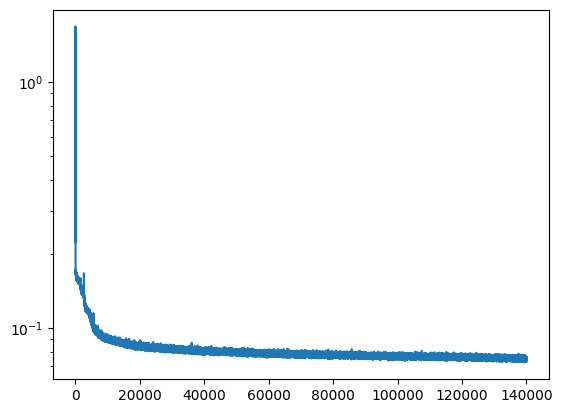

 47%|████▋     | 140112/300000 [30:22<42:18, 62.98it/s]

<bound method _item of Array(0.07461336, dtype=float32)>


 47%|████▋     | 140210/300000 [30:24<41:53, 63.57it/s]

<bound method _item of Array(0.07491733, dtype=float32)>


 47%|████▋     | 140308/300000 [30:25<41:29, 64.16it/s]

<bound method _item of Array(0.07550018, dtype=float32)>


 47%|████▋     | 140413/300000 [30:27<40:51, 65.10it/s]

<bound method _item of Array(0.07637966, dtype=float32)>


 47%|████▋     | 140511/300000 [30:28<40:41, 65.33it/s]

<bound method _item of Array(0.07424561, dtype=float32)>


 47%|████▋     | 140609/300000 [30:30<40:41, 65.28it/s]

<bound method _item of Array(0.07547671, dtype=float32)>


 47%|████▋     | 140707/300000 [30:31<41:48, 63.49it/s]

<bound method _item of Array(0.0757442, dtype=float32)>


 47%|████▋     | 140812/300000 [30:33<42:50, 61.92it/s]

<bound method _item of Array(0.07501372, dtype=float32)>


 47%|████▋     | 140910/300000 [30:35<41:59, 63.13it/s]

<bound method _item of Array(0.07480642, dtype=float32)>


 47%|████▋     | 141008/300000 [30:36<41:53, 63.27it/s]

<bound method _item of Array(0.0747778, dtype=float32)>


 47%|████▋     | 141113/300000 [30:38<41:29, 63.82it/s]

<bound method _item of Array(0.07500041, dtype=float32)>


 47%|████▋     | 141211/300000 [30:39<39:56, 66.27it/s]

<bound method _item of Array(0.07511792, dtype=float32)>


 47%|████▋     | 141309/300000 [30:41<40:25, 65.43it/s]

<bound method _item of Array(0.07522869, dtype=float32)>


 47%|████▋     | 141407/300000 [30:42<40:25, 65.37it/s]

<bound method _item of Array(0.07610247, dtype=float32)>


 47%|████▋     | 141512/300000 [30:44<43:09, 61.21it/s]

<bound method _item of Array(0.07400092, dtype=float32)>


 47%|████▋     | 141610/300000 [30:46<41:16, 63.96it/s]

<bound method _item of Array(0.07510284, dtype=float32)>


 47%|████▋     | 141708/300000 [30:47<41:06, 64.19it/s]

<bound method _item of Array(0.07570841, dtype=float32)>


 47%|████▋     | 141813/300000 [30:49<41:14, 63.92it/s]

<bound method _item of Array(0.07508868, dtype=float32)>


 47%|████▋     | 141911/300000 [30:50<41:15, 63.87it/s]

<bound method _item of Array(0.07255881, dtype=float32)>


 47%|████▋     | 142009/300000 [30:52<41:05, 64.07it/s]

<bound method _item of Array(0.07420878, dtype=float32)>


 47%|████▋     | 142114/300000 [30:54<40:54, 64.32it/s]

<bound method _item of Array(0.07545269, dtype=float32)>


 47%|████▋     | 142212/300000 [30:55<41:14, 63.78it/s]

<bound method _item of Array(0.07435896, dtype=float32)>


 47%|████▋     | 142310/300000 [30:57<41:12, 63.79it/s]

<bound method _item of Array(0.07508031, dtype=float32)>


 47%|████▋     | 142408/300000 [30:58<41:01, 64.03it/s]

<bound method _item of Array(0.07364615, dtype=float32)>


 48%|████▊     | 142513/300000 [31:00<40:23, 64.99it/s]

<bound method _item of Array(0.07433408, dtype=float32)>


 48%|████▊     | 142611/300000 [31:01<40:37, 64.56it/s]

<bound method _item of Array(0.07489031, dtype=float32)>


 48%|████▊     | 142709/300000 [31:03<41:22, 63.36it/s]

<bound method _item of Array(0.07482367, dtype=float32)>


 48%|████▊     | 142807/300000 [31:04<40:47, 64.23it/s]

<bound method _item of Array(0.07515366, dtype=float32)>


 48%|████▊     | 142912/300000 [31:06<41:13, 63.50it/s]

<bound method _item of Array(0.07411576, dtype=float32)>


 48%|████▊     | 143010/300000 [31:08<42:27, 61.62it/s]

<bound method _item of Array(0.07536485, dtype=float32)>


 48%|████▊     | 143108/300000 [31:09<42:08, 62.06it/s]

<bound method _item of Array(0.07416467, dtype=float32)>


 48%|████▊     | 143213/300000 [31:11<39:29, 66.18it/s]

<bound method _item of Array(0.07519028, dtype=float32)>


 48%|████▊     | 143311/300000 [31:12<40:28, 64.51it/s]

<bound method _item of Array(0.07475301, dtype=float32)>


 48%|████▊     | 143409/300000 [31:14<40:43, 64.10it/s]

<bound method _item of Array(0.07521034, dtype=float32)>


 48%|████▊     | 143514/300000 [31:15<40:15, 64.80it/s]

<bound method _item of Array(0.07557044, dtype=float32)>


 48%|████▊     | 143612/300000 [31:17<39:55, 65.28it/s]

<bound method _item of Array(0.0744076, dtype=float32)>


 48%|████▊     | 143710/300000 [31:19<41:48, 62.31it/s]

<bound method _item of Array(0.07491353, dtype=float32)>


 48%|████▊     | 143808/300000 [31:20<42:22, 61.42it/s]

<bound method _item of Array(0.07414354, dtype=float32)>


 48%|████▊     | 143913/300000 [31:22<39:58, 65.07it/s]

<bound method _item of Array(0.07557797, dtype=float32)>


 48%|████▊     | 144011/300000 [31:23<41:48, 62.18it/s]

<bound method _item of Array(0.07446381, dtype=float32)>


 48%|████▊     | 144109/300000 [31:25<40:07, 64.77it/s]

<bound method _item of Array(0.07564083, dtype=float32)>


 48%|████▊     | 144207/300000 [31:26<40:46, 63.67it/s]

<bound method _item of Array(0.07510557, dtype=float32)>


 48%|████▊     | 144312/300000 [31:28<41:25, 62.63it/s]

<bound method _item of Array(0.07493933, dtype=float32)>


 48%|████▊     | 144410/300000 [31:30<42:53, 60.45it/s]

<bound method _item of Array(0.07481383, dtype=float32)>


 48%|████▊     | 144507/300000 [31:31<42:00, 61.68it/s]

<bound method _item of Array(0.07429396, dtype=float32)>


 48%|████▊     | 144612/300000 [31:33<42:40, 60.68it/s]

<bound method _item of Array(0.07576072, dtype=float32)>


 48%|████▊     | 144710/300000 [31:34<41:20, 62.61it/s]

<bound method _item of Array(0.07380627, dtype=float32)>


 48%|████▊     | 144808/300000 [31:36<40:33, 63.79it/s]

<bound method _item of Array(0.07443447, dtype=float32)>


 48%|████▊     | 144906/300000 [31:38<40:36, 63.65it/s]

<bound method _item of Array(0.07436711, dtype=float32)>


 48%|████▊     | 145011/300000 [31:39<40:24, 63.94it/s]

<bound method _item of Array(0.07374604, dtype=float32)>


 48%|████▊     | 145109/300000 [31:41<39:56, 64.63it/s]

<bound method _item of Array(0.07402913, dtype=float32)>


 48%|████▊     | 145207/300000 [31:42<41:40, 61.91it/s]

<bound method _item of Array(0.07690716, dtype=float32)>


 48%|████▊     | 145310/300000 [31:44<41:00, 62.87it/s]

<bound method _item of Array(0.07391009, dtype=float32)>


 48%|████▊     | 145408/300000 [31:46<41:04, 62.72it/s]

<bound method _item of Array(0.07381508, dtype=float32)>


 49%|████▊     | 145513/300000 [31:47<40:26, 63.67it/s]

<bound method _item of Array(0.07499005, dtype=float32)>


 49%|████▊     | 145611/300000 [31:49<40:34, 63.42it/s]

<bound method _item of Array(0.07346844, dtype=float32)>


 49%|████▊     | 145709/300000 [31:50<39:59, 64.30it/s]

<bound method _item of Array(0.07336159, dtype=float32)>


 49%|████▊     | 145807/300000 [31:52<41:04, 62.56it/s]

<bound method _item of Array(0.07513303, dtype=float32)>


 49%|████▊     | 145912/300000 [31:54<42:34, 60.31it/s]

<bound method _item of Array(0.07534794, dtype=float32)>


 49%|████▊     | 146010/300000 [31:55<41:53, 61.28it/s]

<bound method _item of Array(0.07484404, dtype=float32)>


 49%|████▊     | 146112/300000 [31:57<42:30, 60.33it/s]

<bound method _item of Array(0.07377817, dtype=float32)>


 49%|████▊     | 146210/300000 [31:58<40:30, 63.29it/s]

<bound method _item of Array(0.07475128, dtype=float32)>


 49%|████▉     | 146308/300000 [32:00<40:41, 62.96it/s]

<bound method _item of Array(0.07503895, dtype=float32)>


 49%|████▉     | 146413/300000 [32:02<40:30, 63.19it/s]

<bound method _item of Array(0.0750717, dtype=float32)>


 49%|████▉     | 146509/300000 [32:03<41:53, 61.08it/s]

<bound method _item of Array(0.07547121, dtype=float32)>


 49%|████▉     | 146607/300000 [32:05<40:27, 63.20it/s]

<bound method _item of Array(0.07547977, dtype=float32)>


 49%|████▉     | 146712/300000 [32:06<41:53, 60.98it/s]

<bound method _item of Array(0.07481025, dtype=float32)>


 49%|████▉     | 146810/300000 [32:08<42:05, 60.66it/s]

<bound method _item of Array(0.07476485, dtype=float32)>


 49%|████▉     | 146908/300000 [32:10<40:24, 63.14it/s]

<bound method _item of Array(0.0745967, dtype=float32)>


 49%|████▉     | 147013/300000 [32:11<40:25, 63.08it/s]

<bound method _item of Array(0.07456039, dtype=float32)>


 49%|████▉     | 147111/300000 [32:13<40:51, 62.38it/s]

<bound method _item of Array(0.07481693, dtype=float32)>


 49%|████▉     | 147209/300000 [32:14<40:22, 63.07it/s]

<bound method _item of Array(0.07524478, dtype=float32)>


 49%|████▉     | 147307/300000 [32:16<41:18, 61.61it/s]

<bound method _item of Array(0.07557789, dtype=float32)>


 49%|████▉     | 147412/300000 [32:18<43:28, 58.49it/s]

<bound method _item of Array(0.07521531, dtype=float32)>


 49%|████▉     | 147513/300000 [32:19<42:09, 60.29it/s]

<bound method _item of Array(0.07547946, dtype=float32)>


 49%|████▉     | 147607/300000 [32:21<39:59, 63.51it/s]

<bound method _item of Array(0.07434212, dtype=float32)>


 49%|████▉     | 147712/300000 [32:23<40:12, 63.14it/s]

<bound method _item of Array(0.074421, dtype=float32)>


 49%|████▉     | 147810/300000 [32:24<40:32, 62.58it/s]

<bound method _item of Array(0.07539316, dtype=float32)>


 49%|████▉     | 147908/300000 [32:26<41:49, 60.61it/s]

<bound method _item of Array(0.0740793, dtype=float32)>


 49%|████▉     | 148013/300000 [32:27<40:43, 62.19it/s]

<bound method _item of Array(0.0751037, dtype=float32)>


 49%|████▉     | 148111/300000 [32:29<39:28, 64.12it/s]

<bound method _item of Array(0.07558762, dtype=float32)>


 49%|████▉     | 148209/300000 [32:31<41:50, 60.46it/s]

<bound method _item of Array(0.07676207, dtype=float32)>


 49%|████▉     | 148309/300000 [32:32<41:54, 60.33it/s]

<bound method _item of Array(0.0754627, dtype=float32)>


 49%|████▉     | 148407/300000 [32:34<40:53, 61.79it/s]

<bound method _item of Array(0.073988, dtype=float32)>


 50%|████▉     | 148512/300000 [32:36<41:05, 61.45it/s]

<bound method _item of Array(0.07381599, dtype=float32)>


 50%|████▉     | 148610/300000 [32:37<40:00, 63.07it/s]

<bound method _item of Array(0.07505725, dtype=float32)>


 50%|████▉     | 148708/300000 [32:39<41:08, 61.29it/s]

<bound method _item of Array(0.07409209, dtype=float32)>


 50%|████▉     | 148813/300000 [32:40<40:29, 62.23it/s]

<bound method _item of Array(0.07395744, dtype=float32)>


 50%|████▉     | 148911/300000 [32:42<40:30, 62.17it/s]

<bound method _item of Array(0.07644105, dtype=float32)>


 50%|████▉     | 149009/300000 [32:44<41:02, 61.32it/s]

<bound method _item of Array(0.07327452, dtype=float32)>


 50%|████▉     | 149107/300000 [32:45<40:23, 62.25it/s]

<bound method _item of Array(0.0751072, dtype=float32)>


 50%|████▉     | 149212/300000 [32:47<39:59, 62.83it/s]

<bound method _item of Array(0.07366991, dtype=float32)>


 50%|████▉     | 149310/300000 [32:48<40:09, 62.54it/s]

<bound method _item of Array(0.07276315, dtype=float32)>


 50%|████▉     | 149408/300000 [32:50<40:15, 62.34it/s]

<bound method _item of Array(0.07442341, dtype=float32)>


 50%|████▉     | 149513/300000 [32:52<40:25, 62.05it/s]

<bound method _item of Array(0.07557669, dtype=float32)>


 50%|████▉     | 149611/300000 [32:53<41:51, 59.87it/s]

<bound method _item of Array(0.07449482, dtype=float32)>


 50%|████▉     | 149707/300000 [32:55<43:13, 57.94it/s]

<bound method _item of Array(0.07490347, dtype=float32)>


 50%|████▉     | 149809/300000 [32:57<40:34, 61.68it/s]

<bound method _item of Array(0.07483656, dtype=float32)>


 50%|████▉     | 149908/300000 [32:58<42:01, 59.53it/s]

<bound method _item of Array(0.07477188, dtype=float32)>


 50%|████▉     | 149999/300000 [33:00<41:40, 59.99it/s]

<bound method _item of Array(0.0743007, dtype=float32)>


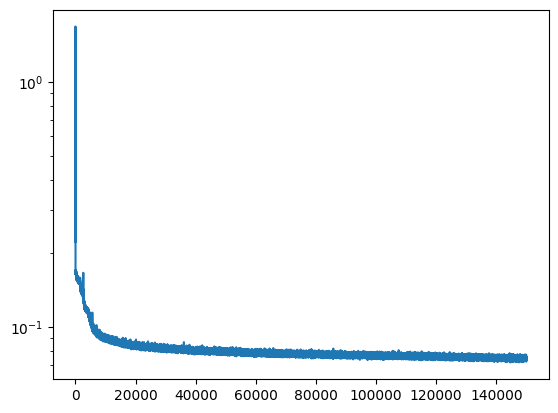

 50%|█████     | 150107/300000 [33:02<39:44, 62.85it/s]

<bound method _item of Array(0.07390504, dtype=float32)>


 50%|█████     | 150212/300000 [33:04<40:10, 62.15it/s]

<bound method _item of Array(0.0755244, dtype=float32)>


 50%|█████     | 150310/300000 [33:05<40:17, 61.93it/s]

<bound method _item of Array(0.07426656, dtype=float32)>


 50%|█████     | 150408/300000 [33:07<40:26, 61.65it/s]

<bound method _item of Array(0.07370768, dtype=float32)>


 50%|█████     | 150513/300000 [33:08<39:25, 63.20it/s]

<bound method _item of Array(0.07331922, dtype=float32)>


 50%|█████     | 150611/300000 [33:10<39:09, 63.59it/s]

<bound method _item of Array(0.07427066, dtype=float32)>


 50%|█████     | 150709/300000 [33:12<39:34, 62.87it/s]

<bound method _item of Array(0.07442408, dtype=float32)>


 50%|█████     | 150807/300000 [33:13<40:11, 61.88it/s]

<bound method _item of Array(0.07414891, dtype=float32)>


 50%|█████     | 150911/300000 [33:15<40:46, 60.95it/s]

<bound method _item of Array(0.07349163, dtype=float32)>


 50%|█████     | 151009/300000 [33:16<40:21, 61.53it/s]

<bound method _item of Array(0.07525122, dtype=float32)>


 50%|█████     | 151107/300000 [33:18<40:38, 61.05it/s]

<bound method _item of Array(0.07401665, dtype=float32)>


 50%|█████     | 151212/300000 [33:20<40:39, 60.99it/s]

<bound method _item of Array(0.0759761, dtype=float32)>


 50%|█████     | 151310/300000 [33:21<39:46, 62.31it/s]

<bound method _item of Array(0.07414911, dtype=float32)>


 50%|█████     | 151408/300000 [33:23<40:30, 61.14it/s]

<bound method _item of Array(0.07403526, dtype=float32)>


 51%|█████     | 151513/300000 [33:25<39:56, 61.95it/s]

<bound method _item of Array(0.07331467, dtype=float32)>


 51%|█████     | 151611/300000 [33:26<39:10, 63.12it/s]

<bound method _item of Array(0.07307445, dtype=float32)>


 51%|█████     | 151709/300000 [33:28<40:33, 60.93it/s]

<bound method _item of Array(0.07377686, dtype=float32)>


 51%|█████     | 151807/300000 [33:29<40:14, 61.38it/s]

<bound method _item of Array(0.07567676, dtype=float32)>


 51%|█████     | 151912/300000 [33:31<40:04, 61.58it/s]

<bound method _item of Array(0.07491249, dtype=float32)>


 51%|█████     | 152010/300000 [33:33<41:32, 59.37it/s]

<bound method _item of Array(0.07470468, dtype=float32)>


 51%|█████     | 152108/300000 [33:34<39:31, 62.37it/s]

<bound method _item of Array(0.07511092, dtype=float32)>


 51%|█████     | 152213/300000 [33:36<39:02, 63.09it/s]

<bound method _item of Array(0.07332602, dtype=float32)>


 51%|█████     | 152311/300000 [33:37<39:26, 62.42it/s]

<bound method _item of Array(0.07585534, dtype=float32)>


 51%|█████     | 152409/300000 [33:39<39:31, 62.25it/s]

<bound method _item of Array(0.07599503, dtype=float32)>


 51%|█████     | 152507/300000 [33:41<39:51, 61.67it/s]

<bound method _item of Array(0.0742907, dtype=float32)>


 51%|█████     | 152612/300000 [33:42<40:34, 60.53it/s]

<bound method _item of Array(0.07392843, dtype=float32)>


 51%|█████     | 152710/300000 [33:44<39:01, 62.90it/s]

<bound method _item of Array(0.07366762, dtype=float32)>


 51%|█████     | 152808/300000 [33:46<39:29, 62.12it/s]

<bound method _item of Array(0.07439015, dtype=float32)>


 51%|█████     | 152913/300000 [33:47<38:49, 63.14it/s]

<bound method _item of Array(0.07483616, dtype=float32)>


 51%|█████     | 153011/300000 [33:49<39:14, 62.42it/s]

<bound method _item of Array(0.07205474, dtype=float32)>


 51%|█████     | 153109/300000 [33:50<39:28, 62.01it/s]

<bound method _item of Array(0.07461687, dtype=float32)>


 51%|█████     | 153207/300000 [33:52<39:57, 61.23it/s]

<bound method _item of Array(0.07532, dtype=float32)>


 51%|█████     | 153307/300000 [33:54<40:09, 60.87it/s]

<bound method _item of Array(0.07455102, dtype=float32)>


 51%|█████     | 153412/300000 [33:55<38:27, 63.51it/s]

<bound method _item of Array(0.07356715, dtype=float32)>


 51%|█████     | 153510/300000 [33:57<39:08, 62.37it/s]

<bound method _item of Array(0.07468038, dtype=float32)>


 51%|█████     | 153608/300000 [33:58<39:10, 62.27it/s]

<bound method _item of Array(0.07341276, dtype=float32)>


 51%|█████     | 153713/300000 [34:00<38:56, 62.62it/s]

<bound method _item of Array(0.07340392, dtype=float32)>


 51%|█████▏    | 153811/300000 [34:02<38:39, 63.04it/s]

<bound method _item of Array(0.07514909, dtype=float32)>


 51%|█████▏    | 153909/300000 [34:03<38:40, 62.95it/s]

<bound method _item of Array(0.074967, dtype=float32)>


 51%|█████▏    | 154011/300000 [34:05<41:29, 58.63it/s]

<bound method _item of Array(0.07346709, dtype=float32)>


 51%|█████▏    | 154113/300000 [34:07<38:53, 62.52it/s]

<bound method _item of Array(0.07417839, dtype=float32)>


 51%|█████▏    | 154211/300000 [34:08<38:36, 62.92it/s]

<bound method _item of Array(0.07460585, dtype=float32)>


 51%|█████▏    | 154309/300000 [34:10<38:35, 62.93it/s]

<bound method _item of Array(0.07330952, dtype=float32)>


 51%|█████▏    | 154407/300000 [34:11<39:57, 60.72it/s]

<bound method _item of Array(0.07460215, dtype=float32)>


 52%|█████▏    | 154512/300000 [34:13<38:29, 63.01it/s]

<bound method _item of Array(0.07483186, dtype=float32)>


 52%|█████▏    | 154610/300000 [34:15<38:41, 62.62it/s]

<bound method _item of Array(0.07493788, dtype=float32)>


 52%|█████▏    | 154708/300000 [34:16<39:46, 60.88it/s]

<bound method _item of Array(0.07512169, dtype=float32)>


 52%|█████▏    | 154809/300000 [34:18<41:45, 57.96it/s]

<bound method _item of Array(0.07295183, dtype=float32)>


 52%|█████▏    | 154910/300000 [34:20<39:58, 60.50it/s]

<bound method _item of Array(0.07391861, dtype=float32)>


 52%|█████▏    | 155008/300000 [34:21<39:22, 61.36it/s]

<bound method _item of Array(0.07417163, dtype=float32)>


 52%|█████▏    | 155113/300000 [34:23<40:41, 59.34it/s]

<bound method _item of Array(0.07442541, dtype=float32)>


 52%|█████▏    | 155211/300000 [34:24<38:50, 62.12it/s]

<bound method _item of Array(0.07485562, dtype=float32)>


 52%|█████▏    | 155309/300000 [34:26<38:52, 62.04it/s]

<bound method _item of Array(0.07497407, dtype=float32)>


 52%|█████▏    | 155407/300000 [34:28<39:19, 61.29it/s]

<bound method _item of Array(0.07430606, dtype=float32)>


 52%|█████▏    | 155512/300000 [34:29<39:32, 60.90it/s]

<bound method _item of Array(0.07575311, dtype=float32)>


 52%|█████▏    | 155610/300000 [34:31<39:00, 61.69it/s]

<bound method _item of Array(0.07325816, dtype=float32)>


 52%|█████▏    | 155708/300000 [34:33<39:06, 61.49it/s]

<bound method _item of Array(0.0737377, dtype=float32)>


 52%|█████▏    | 155813/300000 [34:34<38:31, 62.39it/s]

<bound method _item of Array(0.07444632, dtype=float32)>


 52%|█████▏    | 155911/300000 [34:36<38:30, 62.35it/s]

<bound method _item of Array(0.07392822, dtype=float32)>


 52%|█████▏    | 156009/300000 [34:37<38:30, 62.31it/s]

<bound method _item of Array(0.0741106, dtype=float32)>


 52%|█████▏    | 156111/300000 [34:39<38:16, 62.66it/s]

<bound method _item of Array(0.07423364, dtype=float32)>


 52%|█████▏    | 156209/300000 [34:41<39:21, 60.90it/s]

<bound method _item of Array(0.07462621, dtype=float32)>


 52%|█████▏    | 156307/300000 [34:42<38:36, 62.04it/s]

<bound method _item of Array(0.07323889, dtype=float32)>


 52%|█████▏    | 156412/300000 [34:44<38:06, 62.79it/s]

<bound method _item of Array(0.07423966, dtype=float32)>


 52%|█████▏    | 156510/300000 [34:46<38:14, 62.54it/s]

<bound method _item of Array(0.07508416, dtype=float32)>


 52%|█████▏    | 156608/300000 [34:47<38:31, 62.03it/s]

<bound method _item of Array(0.0733021, dtype=float32)>


 52%|█████▏    | 156713/300000 [34:49<38:39, 61.77it/s]

<bound method _item of Array(0.07369328, dtype=float32)>


 52%|█████▏    | 156811/300000 [34:50<38:24, 62.14it/s]

<bound method _item of Array(0.07382718, dtype=float32)>


 52%|█████▏    | 156911/300000 [34:52<41:03, 58.09it/s]

<bound method _item of Array(0.07372267, dtype=float32)>


 52%|█████▏    | 157010/300000 [34:54<39:16, 60.68it/s]

<bound method _item of Array(0.07375651, dtype=float32)>


 52%|█████▏    | 157108/300000 [34:55<39:01, 61.02it/s]

<bound method _item of Array(0.07361462, dtype=float32)>


 52%|█████▏    | 157213/300000 [34:57<37:52, 62.84it/s]

<bound method _item of Array(0.07336022, dtype=float32)>


 52%|█████▏    | 157311/300000 [34:59<38:54, 61.11it/s]

<bound method _item of Array(0.0736437, dtype=float32)>


 52%|█████▏    | 157409/300000 [35:00<38:25, 61.86it/s]

<bound method _item of Array(0.07465947, dtype=float32)>


 53%|█████▎    | 157507/300000 [35:02<38:21, 61.91it/s]

<bound method _item of Array(0.07421619, dtype=float32)>


 53%|█████▎    | 157607/300000 [35:03<39:47, 59.63it/s]

<bound method _item of Array(0.07219662, dtype=float32)>


 53%|█████▎    | 157710/300000 [35:05<40:08, 59.08it/s]

<bound method _item of Array(0.07386302, dtype=float32)>


 53%|█████▎    | 157811/300000 [35:07<38:05, 62.22it/s]

<bound method _item of Array(0.07350349, dtype=float32)>


 53%|█████▎    | 157909/300000 [35:08<38:11, 62.01it/s]

<bound method _item of Array(0.07441846, dtype=float32)>


 53%|█████▎    | 158007/300000 [35:10<37:34, 62.98it/s]

<bound method _item of Array(0.07348443, dtype=float32)>


 53%|█████▎    | 158112/300000 [35:12<37:39, 62.80it/s]

<bound method _item of Array(0.0737219, dtype=float32)>


 53%|█████▎    | 158210/300000 [35:13<38:44, 60.99it/s]

<bound method _item of Array(0.07400098, dtype=float32)>


 53%|█████▎    | 158311/300000 [35:15<39:43, 59.44it/s]

<bound method _item of Array(0.07505324, dtype=float32)>


 53%|█████▎    | 158409/300000 [35:17<40:23, 58.42it/s]

<bound method _item of Array(0.07477063, dtype=float32)>


 53%|█████▎    | 158513/300000 [35:18<40:04, 58.85it/s]

<bound method _item of Array(0.07496547, dtype=float32)>


 53%|█████▎    | 158611/300000 [35:20<38:42, 60.87it/s]

<bound method _item of Array(0.07423155, dtype=float32)>


 53%|█████▎    | 158709/300000 [35:22<38:52, 60.57it/s]

<bound method _item of Array(0.07425945, dtype=float32)>


 53%|█████▎    | 158807/300000 [35:23<38:20, 61.36it/s]

<bound method _item of Array(0.07480489, dtype=float32)>


 53%|█████▎    | 158911/300000 [35:25<37:53, 62.05it/s]

<bound method _item of Array(0.07271878, dtype=float32)>


 53%|█████▎    | 159009/300000 [35:27<38:56, 60.33it/s]

<bound method _item of Array(0.0732009, dtype=float32)>


 53%|█████▎    | 159111/300000 [35:28<39:33, 59.36it/s]

<bound method _item of Array(0.07487576, dtype=float32)>


 53%|█████▎    | 159209/300000 [35:30<38:50, 60.42it/s]

<bound method _item of Array(0.07335246, dtype=float32)>


 53%|█████▎    | 159307/300000 [35:31<37:29, 62.53it/s]

<bound method _item of Array(0.07494297, dtype=float32)>


 53%|█████▎    | 159412/300000 [35:33<39:01, 60.04it/s]

<bound method _item of Array(0.07399347, dtype=float32)>


 53%|█████▎    | 159508/300000 [35:35<41:17, 56.70it/s]

<bound method _item of Array(0.07250947, dtype=float32)>


 53%|█████▎    | 159609/300000 [35:36<38:47, 60.32it/s]

<bound method _item of Array(0.07344518, dtype=float32)>


 53%|█████▎    | 159707/300000 [35:38<38:28, 60.76it/s]

<bound method _item of Array(0.07362377, dtype=float32)>


 53%|█████▎    | 159812/300000 [35:40<40:15, 58.03it/s]

<bound method _item of Array(0.07373016, dtype=float32)>


 53%|█████▎    | 159911/300000 [35:42<40:03, 58.28it/s]

<bound method _item of Array(0.07373394, dtype=float32)>


 53%|█████▎    | 159994/300000 [35:43<39:29, 59.08it/s]

<bound method _item of Array(0.07366261, dtype=float32)>


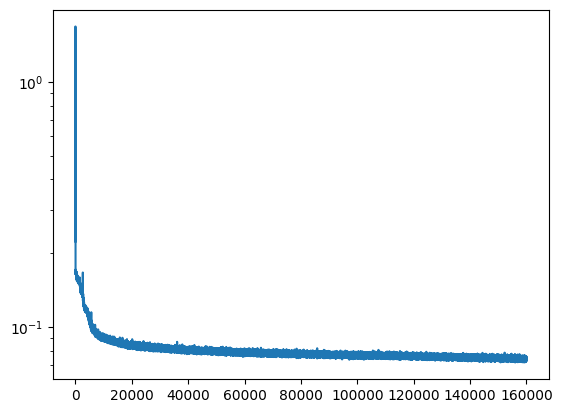

 53%|█████▎    | 160112/300000 [35:45<39:05, 59.65it/s]

<bound method _item of Array(0.07519353, dtype=float32)>


 53%|█████▎    | 160210/300000 [35:47<37:49, 61.59it/s]

<bound method _item of Array(0.07345171, dtype=float32)>


 53%|█████▎    | 160307/300000 [35:49<38:44, 60.10it/s]

<bound method _item of Array(0.07400476, dtype=float32)>


 53%|█████▎    | 160408/300000 [35:50<41:54, 55.51it/s]

<bound method _item of Array(0.0721737, dtype=float32)>


 54%|█████▎    | 160510/300000 [35:52<40:55, 56.81it/s]

<bound method _item of Array(0.07408457, dtype=float32)>


 54%|█████▎    | 160608/300000 [35:54<38:50, 59.82it/s]

<bound method _item of Array(0.07430819, dtype=float32)>


 54%|█████▎    | 160708/300000 [35:56<38:10, 60.82it/s]

<bound method _item of Array(0.07397521, dtype=float32)>


 54%|█████▎    | 160813/300000 [35:57<37:50, 61.29it/s]

<bound method _item of Array(0.073869, dtype=float32)>


 54%|█████▎    | 160911/300000 [35:59<38:22, 60.41it/s]

<bound method _item of Array(0.07428625, dtype=float32)>


 54%|█████▎    | 161009/300000 [36:01<40:03, 57.82it/s]

<bound method _item of Array(0.07379191, dtype=float32)>


 54%|█████▎    | 161113/300000 [36:02<38:03, 60.83it/s]

<bound method _item of Array(0.07357504, dtype=float32)>


 54%|█████▎    | 161210/300000 [36:04<38:15, 60.47it/s]

<bound method _item of Array(0.07467333, dtype=float32)>


 54%|█████▍    | 161311/300000 [36:06<38:59, 59.29it/s]

<bound method _item of Array(0.07466769, dtype=float32)>


 54%|█████▍    | 161408/300000 [36:07<37:39, 61.33it/s]

<bound method _item of Array(0.07232443, dtype=float32)>


 54%|█████▍    | 161513/300000 [36:09<37:37, 61.36it/s]

<bound method _item of Array(0.07490162, dtype=float32)>


 54%|█████▍    | 161611/300000 [36:10<37:56, 60.80it/s]

<bound method _item of Array(0.07272393, dtype=float32)>


 54%|█████▍    | 161709/300000 [36:12<38:12, 60.32it/s]

<bound method _item of Array(0.07470188, dtype=float32)>


 54%|█████▍    | 161807/300000 [36:14<38:22, 60.03it/s]

<bound method _item of Array(0.0745547, dtype=float32)>


 54%|█████▍    | 161911/300000 [36:15<40:46, 56.45it/s]

<bound method _item of Array(0.07445984, dtype=float32)>


 54%|█████▍    | 162009/300000 [36:17<41:11, 55.84it/s]

<bound method _item of Array(0.07457278, dtype=float32)>


 54%|█████▍    | 162109/300000 [36:19<37:52, 60.69it/s]

<bound method _item of Array(0.0749172, dtype=float32)>


 54%|█████▍    | 162213/300000 [36:21<37:49, 60.71it/s]

<bound method _item of Array(0.07358515, dtype=float32)>


 54%|█████▍    | 162311/300000 [36:22<37:03, 61.92it/s]

<bound method _item of Array(0.07349908, dtype=float32)>


 54%|█████▍    | 162413/300000 [36:24<37:55, 60.46it/s]

<bound method _item of Array(0.07381745, dtype=float32)>


 54%|█████▍    | 162511/300000 [36:25<38:18, 59.82it/s]

<bound method _item of Array(0.0742056, dtype=float32)>


 54%|█████▍    | 162610/300000 [36:27<38:24, 59.62it/s]

<bound method _item of Array(0.07420553, dtype=float32)>


 54%|█████▍    | 162712/300000 [36:29<38:19, 59.70it/s]

<bound method _item of Array(0.0732129, dtype=float32)>


 54%|█████▍    | 162809/300000 [36:30<37:05, 61.63it/s]

<bound method _item of Array(0.07309997, dtype=float32)>


 54%|█████▍    | 162907/300000 [36:32<37:10, 61.47it/s]

<bound method _item of Array(0.07247294, dtype=float32)>


 54%|█████▍    | 163012/300000 [36:34<37:05, 61.54it/s]

<bound method _item of Array(0.07372274, dtype=float32)>


 54%|█████▍    | 163110/300000 [36:35<36:50, 61.94it/s]

<bound method _item of Array(0.07466969, dtype=float32)>


 54%|█████▍    | 163208/300000 [36:37<36:40, 62.17it/s]

<bound method _item of Array(0.07361685, dtype=float32)>


 54%|█████▍    | 163306/300000 [36:38<37:47, 60.28it/s]

<bound method _item of Array(0.07534537, dtype=float32)>


 54%|█████▍    | 163409/300000 [36:40<37:09, 61.26it/s]

<bound method _item of Array(0.073713, dtype=float32)>


 55%|█████▍    | 163507/300000 [36:42<37:21, 60.89it/s]

<bound method _item of Array(0.07499636, dtype=float32)>


 55%|█████▍    | 163612/300000 [36:43<37:22, 60.82it/s]

<bound method _item of Array(0.07404036, dtype=float32)>


 55%|█████▍    | 163710/300000 [36:45<36:55, 61.52it/s]

<bound method _item of Array(0.07436647, dtype=float32)>


 55%|█████▍    | 163808/300000 [36:47<36:18, 62.51it/s]

<bound method _item of Array(0.07435349, dtype=float32)>


 55%|█████▍    | 163913/300000 [36:48<37:03, 61.21it/s]

<bound method _item of Array(0.07327712, dtype=float32)>


 55%|█████▍    | 164009/300000 [36:50<38:47, 58.43it/s]

<bound method _item of Array(0.07406802, dtype=float32)>


 55%|█████▍    | 164109/300000 [36:52<37:54, 59.74it/s]

<bound method _item of Array(0.07364973, dtype=float32)>


 55%|█████▍    | 164209/300000 [36:53<38:22, 58.98it/s]

<bound method _item of Array(0.07288384, dtype=float32)>


 55%|█████▍    | 164309/300000 [36:55<37:31, 60.27it/s]

<bound method _item of Array(0.07384095, dtype=float32)>


 55%|█████▍    | 164407/300000 [36:57<36:47, 61.42it/s]

<bound method _item of Array(0.07248026, dtype=float32)>


 55%|█████▍    | 164512/300000 [36:58<37:06, 60.85it/s]

<bound method _item of Array(0.07404289, dtype=float32)>


 55%|█████▍    | 164609/300000 [37:00<37:18, 60.47it/s]

<bound method _item of Array(0.07204995, dtype=float32)>


 55%|█████▍    | 164710/300000 [37:02<38:26, 58.67it/s]

<bound method _item of Array(0.07302504, dtype=float32)>


 55%|█████▍    | 164807/300000 [37:03<39:22, 57.22it/s]

<bound method _item of Array(0.07267931, dtype=float32)>


 55%|█████▍    | 164909/300000 [37:05<37:26, 60.13it/s]

<bound method _item of Array(0.07435854, dtype=float32)>


 55%|█████▌    | 165007/300000 [37:07<36:41, 61.33it/s]

<bound method _item of Array(0.07437636, dtype=float32)>


 55%|█████▌    | 165112/300000 [37:08<36:37, 61.37it/s]

<bound method _item of Array(0.07289802, dtype=float32)>


 55%|█████▌    | 165210/300000 [37:10<37:11, 60.42it/s]

<bound method _item of Array(0.07323336, dtype=float32)>


 55%|█████▌    | 165308/300000 [37:12<37:09, 60.42it/s]

<bound method _item of Array(0.07513307, dtype=float32)>


 55%|█████▌    | 165413/300000 [37:13<36:39, 61.19it/s]

<bound method _item of Array(0.07274006, dtype=float32)>


 55%|█████▌    | 165507/300000 [37:15<38:30, 58.20it/s]

<bound method _item of Array(0.07319858, dtype=float32)>


 55%|█████▌    | 165610/300000 [37:17<38:06, 58.78it/s]

<bound method _item of Array(0.07315069, dtype=float32)>


 55%|█████▌    | 165709/300000 [37:18<37:30, 59.67it/s]

<bound method _item of Array(0.07248381, dtype=float32)>


 55%|█████▌    | 165811/300000 [37:20<36:34, 61.14it/s]

<bound method _item of Array(0.07424021, dtype=float32)>


 55%|█████▌    | 165908/300000 [37:22<37:29, 59.60it/s]

<bound method _item of Array(0.07328472, dtype=float32)>


 55%|█████▌    | 166008/300000 [37:23<38:05, 58.63it/s]

<bound method _item of Array(0.07280561, dtype=float32)>


 55%|█████▌    | 166113/300000 [37:25<37:06, 60.14it/s]

<bound method _item of Array(0.0734571, dtype=float32)>


 55%|█████▌    | 166212/300000 [37:27<37:42, 59.14it/s]

<bound method _item of Array(0.07295471, dtype=float32)>


 55%|█████▌    | 166308/300000 [37:28<37:41, 59.12it/s]

<bound method _item of Array(0.0740538, dtype=float32)>


 55%|█████▌    | 166409/300000 [37:30<36:29, 61.00it/s]

<bound method _item of Array(0.07307429, dtype=float32)>


 56%|█████▌    | 166507/300000 [37:32<36:18, 61.27it/s]

<bound method _item of Array(0.07422923, dtype=float32)>


 56%|█████▌    | 166612/300000 [37:33<36:54, 60.23it/s]

<bound method _item of Array(0.07319584, dtype=float32)>


 56%|█████▌    | 166710/300000 [37:35<36:17, 61.20it/s]

<bound method _item of Array(0.07288319, dtype=float32)>


 56%|█████▌    | 166808/300000 [37:37<36:41, 60.50it/s]

<bound method _item of Array(0.07302827, dtype=float32)>


 56%|█████▌    | 166912/300000 [37:38<37:37, 58.95it/s]

<bound method _item of Array(0.07282092, dtype=float32)>


 56%|█████▌    | 167010/300000 [37:40<37:29, 59.12it/s]

<bound method _item of Array(0.07303768, dtype=float32)>


 56%|█████▌    | 167113/300000 [37:42<37:00, 59.85it/s]

<bound method _item of Array(0.07422305, dtype=float32)>


 56%|█████▌    | 167210/300000 [37:43<36:55, 59.95it/s]

<bound method _item of Array(0.07293544, dtype=float32)>


 56%|█████▌    | 167313/300000 [37:45<36:51, 60.00it/s]

<bound method _item of Array(0.075316, dtype=float32)>


 56%|█████▌    | 167411/300000 [37:47<36:34, 60.42it/s]

<bound method _item of Array(0.07281826, dtype=float32)>


 56%|█████▌    | 167507/300000 [37:48<36:48, 59.98it/s]

<bound method _item of Array(0.07340883, dtype=float32)>


 56%|█████▌    | 167612/300000 [37:50<37:54, 58.21it/s]

<bound method _item of Array(0.07224465, dtype=float32)>


 56%|█████▌    | 167708/300000 [37:52<37:59, 58.04it/s]

<bound method _item of Array(0.07363288, dtype=float32)>


 56%|█████▌    | 167811/300000 [37:53<36:14, 60.79it/s]

<bound method _item of Array(0.07343367, dtype=float32)>


 56%|█████▌    | 167911/300000 [37:55<37:09, 59.25it/s]

<bound method _item of Array(0.07228306, dtype=float32)>


 56%|█████▌    | 168010/300000 [37:57<35:59, 61.13it/s]

<bound method _item of Array(0.07391628, dtype=float32)>


 56%|█████▌    | 168107/300000 [37:58<36:10, 60.76it/s]

<bound method _item of Array(0.07307485, dtype=float32)>


 56%|█████▌    | 168211/300000 [38:00<36:49, 59.64it/s]

<bound method _item of Array(0.07355838, dtype=float32)>


 56%|█████▌    | 168309/300000 [38:02<37:39, 58.29it/s]

<bound method _item of Array(0.07179234, dtype=float32)>


 56%|█████▌    | 168411/300000 [38:04<38:01, 57.67it/s]

<bound method _item of Array(0.07419128, dtype=float32)>


 56%|█████▌    | 168508/300000 [38:05<36:58, 59.26it/s]

<bound method _item of Array(0.07343075, dtype=float32)>


 56%|█████▌    | 168609/300000 [38:07<36:25, 60.11it/s]

<bound method _item of Array(0.07351724, dtype=float32)>


 56%|█████▌    | 168709/300000 [38:09<36:33, 59.87it/s]

<bound method _item of Array(0.0737673, dtype=float32)>


 56%|█████▋    | 168811/300000 [38:10<36:09, 60.46it/s]

<bound method _item of Array(0.0734596, dtype=float32)>


 56%|█████▋    | 168909/300000 [38:12<35:59, 60.70it/s]

<bound method _item of Array(0.07375731, dtype=float32)>


 56%|█████▋    | 169008/300000 [38:14<39:12, 55.69it/s]

<bound method _item of Array(0.07440991, dtype=float32)>


 56%|█████▋    | 169110/300000 [38:15<38:07, 57.22it/s]

<bound method _item of Array(0.07478919, dtype=float32)>


 56%|█████▋    | 169210/300000 [38:17<36:12, 60.20it/s]

<bound method _item of Array(0.07490899, dtype=float32)>


 56%|█████▋    | 169310/300000 [38:19<36:57, 58.93it/s]

<bound method _item of Array(0.0732776, dtype=float32)>


 56%|█████▋    | 169407/300000 [38:21<36:59, 58.83it/s]

<bound method _item of Array(0.07377828, dtype=float32)>


 57%|█████▋    | 169507/300000 [38:22<36:29, 59.59it/s]

<bound method _item of Array(0.07337394, dtype=float32)>


 57%|█████▋    | 169612/300000 [38:24<36:31, 59.49it/s]

<bound method _item of Array(0.07436083, dtype=float32)>


 57%|█████▋    | 169708/300000 [38:26<37:45, 57.50it/s]

<bound method _item of Array(0.07303193, dtype=float32)>


 57%|█████▋    | 169810/300000 [38:27<37:18, 58.16it/s]

<bound method _item of Array(0.07352733, dtype=float32)>


 57%|█████▋    | 169910/300000 [38:29<37:10, 58.32it/s]

<bound method _item of Array(0.07407336, dtype=float32)>


 57%|█████▋    | 169998/300000 [38:31<36:10, 59.89it/s]

<bound method _item of Array(0.07307741, dtype=float32)>


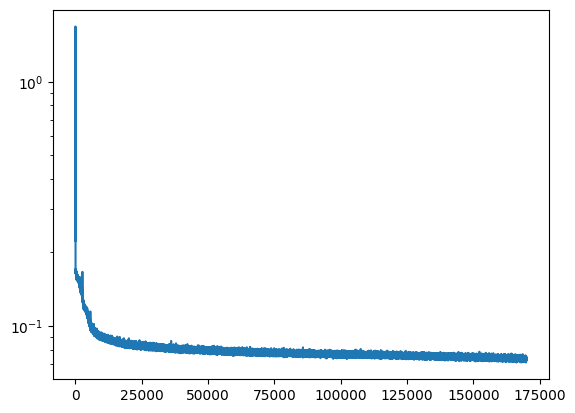

 57%|█████▋    | 170107/300000 [38:33<36:31, 59.26it/s]

<bound method _item of Array(0.07303526, dtype=float32)>


 57%|█████▋    | 170211/300000 [38:34<36:07, 59.89it/s]

<bound method _item of Array(0.07305149, dtype=float32)>


 57%|█████▋    | 170309/300000 [38:36<36:48, 58.73it/s]

<bound method _item of Array(0.07382714, dtype=float32)>


 57%|█████▋    | 170411/300000 [38:38<40:29, 53.34it/s]

<bound method _item of Array(0.07331835, dtype=float32)>


 57%|█████▋    | 170512/300000 [38:40<36:18, 59.44it/s]

<bound method _item of Array(0.0718503, dtype=float32)>


 57%|█████▋    | 170607/300000 [38:41<35:41, 60.41it/s]

<bound method _item of Array(0.07381881, dtype=float32)>


 57%|█████▋    | 170708/300000 [38:43<37:29, 57.48it/s]

<bound method _item of Array(0.0728028, dtype=float32)>


 57%|█████▋    | 170813/300000 [38:45<35:49, 60.09it/s]

<bound method _item of Array(0.0722179, dtype=float32)>


 57%|█████▋    | 170910/300000 [38:46<35:51, 60.00it/s]

<bound method _item of Array(0.07312222, dtype=float32)>


 57%|█████▋    | 171008/300000 [38:48<38:04, 56.46it/s]

<bound method _item of Array(0.07346186, dtype=float32)>


 57%|█████▋    | 171110/300000 [38:50<37:33, 57.18it/s]

<bound method _item of Array(0.07252356, dtype=float32)>


 57%|█████▋    | 171212/300000 [38:51<36:17, 59.15it/s]

<bound method _item of Array(0.07391783, dtype=float32)>


 57%|█████▋    | 171311/300000 [38:53<36:15, 59.15it/s]

<bound method _item of Array(0.07272694, dtype=float32)>


 57%|█████▋    | 171407/300000 [38:55<35:24, 60.52it/s]

<bound method _item of Array(0.07431933, dtype=float32)>


 57%|█████▋    | 171508/300000 [38:56<35:20, 60.61it/s]

<bound method _item of Array(0.07294638, dtype=float32)>


 57%|█████▋    | 171611/300000 [38:58<36:30, 58.61it/s]

<bound method _item of Array(0.07186556, dtype=float32)>


 57%|█████▋    | 171710/300000 [39:00<35:47, 59.75it/s]

<bound method _item of Array(0.07409468, dtype=float32)>


 57%|█████▋    | 171806/300000 [39:01<38:43, 55.17it/s]

<bound method _item of Array(0.07272256, dtype=float32)>


 57%|█████▋    | 171908/300000 [39:03<37:19, 57.20it/s]

<bound method _item of Array(0.07436448, dtype=float32)>


 57%|█████▋    | 172008/300000 [39:05<35:55, 59.38it/s]

<bound method _item of Array(0.07407262, dtype=float32)>


 57%|█████▋    | 172112/300000 [39:07<35:30, 60.01it/s]

<bound method _item of Array(0.07239737, dtype=float32)>


 57%|█████▋    | 172211/300000 [39:08<36:06, 58.99it/s]

<bound method _item of Array(0.07329269, dtype=float32)>


 57%|█████▋    | 172312/300000 [39:10<35:32, 59.87it/s]

<bound method _item of Array(0.07374533, dtype=float32)>


 57%|█████▋    | 172412/300000 [39:12<37:11, 57.17it/s]

<bound method _item of Array(0.07384909, dtype=float32)>


 58%|█████▊    | 172508/300000 [39:13<36:43, 57.87it/s]

<bound method _item of Array(0.07310393, dtype=float32)>


 58%|█████▊    | 172611/300000 [39:15<36:26, 58.25it/s]

<bound method _item of Array(0.07252593, dtype=float32)>


 58%|█████▊    | 172712/300000 [39:17<35:46, 59.29it/s]

<bound method _item of Array(0.07237563, dtype=float32)>


 58%|█████▊    | 172811/300000 [39:18<35:48, 59.20it/s]

<bound method _item of Array(0.07296406, dtype=float32)>


 58%|█████▊    | 172909/300000 [39:20<35:36, 59.49it/s]

<bound method _item of Array(0.0725262, dtype=float32)>


 58%|█████▊    | 173010/300000 [39:22<34:40, 61.04it/s]

<bound method _item of Array(0.07234357, dtype=float32)>


 58%|█████▊    | 173110/300000 [39:23<36:12, 58.41it/s]

<bound method _item of Array(0.07227315, dtype=float32)>


 58%|█████▊    | 173211/300000 [39:25<36:42, 57.56it/s]

<bound method _item of Array(0.07185058, dtype=float32)>


 58%|█████▊    | 173312/300000 [39:27<35:04, 60.20it/s]

<bound method _item of Array(0.07232256, dtype=float32)>


 58%|█████▊    | 173411/300000 [39:29<35:31, 59.38it/s]

<bound method _item of Array(0.07342827, dtype=float32)>


 58%|█████▊    | 173512/300000 [39:30<35:18, 59.71it/s]

<bound method _item of Array(0.0729912, dtype=float32)>


 58%|█████▊    | 173610/300000 [39:32<35:08, 59.95it/s]

<bound method _item of Array(0.07328293, dtype=float32)>


 58%|█████▊    | 173713/300000 [39:34<35:12, 59.79it/s]

<bound method _item of Array(0.07374496, dtype=float32)>


 58%|█████▊    | 173809/300000 [39:35<37:18, 56.38it/s]

<bound method _item of Array(0.07230743, dtype=float32)>


 58%|█████▊    | 173911/300000 [39:37<37:13, 56.44it/s]

<bound method _item of Array(0.07242274, dtype=float32)>


 58%|█████▊    | 174007/300000 [39:39<36:16, 57.88it/s]

<bound method _item of Array(0.0726345, dtype=float32)>


 58%|█████▊    | 174112/300000 [39:40<35:39, 58.83it/s]

<bound method _item of Array(0.07315072, dtype=float32)>


 58%|█████▊    | 174210/300000 [39:42<35:02, 59.84it/s]

<bound method _item of Array(0.07256712, dtype=float32)>


 58%|█████▊    | 174308/300000 [39:44<35:39, 58.74it/s]

<bound method _item of Array(0.07147646, dtype=float32)>


 58%|█████▊    | 174410/300000 [39:46<36:19, 57.62it/s]

<bound method _item of Array(0.07370559, dtype=float32)>


 58%|█████▊    | 174507/300000 [39:47<35:56, 58.19it/s]

<bound method _item of Array(0.07475844, dtype=float32)>


 58%|█████▊    | 174609/300000 [39:49<36:44, 56.88it/s]

<bound method _item of Array(0.07263225, dtype=float32)>


 58%|█████▊    | 174711/300000 [39:51<35:57, 58.07it/s]

<bound method _item of Array(0.07249976, dtype=float32)>


 58%|█████▊    | 174807/300000 [39:52<36:22, 57.36it/s]

<bound method _item of Array(0.07260702, dtype=float32)>


 58%|█████▊    | 174912/300000 [39:54<34:49, 59.86it/s]

<bound method _item of Array(0.07310788, dtype=float32)>


 58%|█████▊    | 175008/300000 [39:56<34:10, 60.97it/s]

<bound method _item of Array(0.07259359, dtype=float32)>


 58%|█████▊    | 175112/300000 [39:58<34:54, 59.63it/s]

<bound method _item of Array(0.07269452, dtype=float32)>


 58%|█████▊    | 175209/300000 [39:59<36:21, 57.21it/s]

<bound method _item of Array(0.07237809, dtype=float32)>


 58%|█████▊    | 175311/300000 [40:01<36:26, 57.03it/s]

<bound method _item of Array(0.07370759, dtype=float32)>


 58%|█████▊    | 175408/300000 [40:03<35:28, 58.54it/s]

<bound method _item of Array(0.07354371, dtype=float32)>


 59%|█████▊    | 175510/300000 [40:04<36:05, 57.49it/s]

<bound method _item of Array(0.07199581, dtype=float32)>


 59%|█████▊    | 175607/300000 [40:06<35:42, 58.06it/s]

<bound method _item of Array(0.07289429, dtype=float32)>


 59%|█████▊    | 175709/300000 [40:08<36:38, 56.54it/s]

<bound method _item of Array(0.07158799, dtype=float32)>


 59%|█████▊    | 175810/300000 [40:10<34:54, 59.29it/s]

<bound method _item of Array(0.07272313, dtype=float32)>


 59%|█████▊    | 175910/300000 [40:11<35:38, 58.03it/s]

<bound method _item of Array(0.07212273, dtype=float32)>


 59%|█████▊    | 176012/300000 [40:13<37:36, 54.94it/s]

<bound method _item of Array(0.07272886, dtype=float32)>


 59%|█████▊    | 176108/300000 [40:15<36:12, 57.01it/s]

<bound method _item of Array(0.07222711, dtype=float32)>


 59%|█████▊    | 176207/300000 [40:17<34:42, 59.46it/s]

<bound method _item of Array(0.07291025, dtype=float32)>


 59%|█████▉    | 176310/300000 [40:18<35:27, 58.13it/s]

<bound method _item of Array(0.07444008, dtype=float32)>


 59%|█████▉    | 176408/300000 [40:20<34:33, 59.62it/s]

<bound method _item of Array(0.07269812, dtype=float32)>


 59%|█████▉    | 176507/300000 [40:22<34:34, 59.52it/s]

<bound method _item of Array(0.07232881, dtype=float32)>


 59%|█████▉    | 176612/300000 [40:23<37:41, 54.57it/s]

<bound method _item of Array(0.07401396, dtype=float32)>


 59%|█████▉    | 176708/300000 [40:25<35:51, 57.31it/s]

<bound method _item of Array(0.07238533, dtype=float32)>


 59%|█████▉    | 176810/300000 [40:27<35:25, 57.95it/s]

<bound method _item of Array(0.07319848, dtype=float32)>


 59%|█████▉    | 176912/300000 [40:29<35:15, 58.20it/s]

<bound method _item of Array(0.07386056, dtype=float32)>


 59%|█████▉    | 177008/300000 [40:30<35:14, 58.15it/s]

<bound method _item of Array(0.07320891, dtype=float32)>


 59%|█████▉    | 177111/300000 [40:32<35:54, 57.03it/s]

<bound method _item of Array(0.07239781, dtype=float32)>


 59%|█████▉    | 177207/300000 [40:34<35:12, 58.12it/s]

<bound method _item of Array(0.07362147, dtype=float32)>


 59%|█████▉    | 177312/300000 [40:36<36:54, 55.40it/s]

<bound method _item of Array(0.0736038, dtype=float32)>


 59%|█████▉    | 177408/300000 [40:37<35:57, 56.82it/s]

<bound method _item of Array(0.07264214, dtype=float32)>


 59%|█████▉    | 177510/300000 [40:39<35:08, 58.10it/s]

<bound method _item of Array(0.07360192, dtype=float32)>


 59%|█████▉    | 177612/300000 [40:41<35:44, 57.06it/s]

<bound method _item of Array(0.07251052, dtype=float32)>


 59%|█████▉    | 177708/300000 [40:43<35:57, 56.69it/s]

<bound method _item of Array(0.07327241, dtype=float32)>


 59%|█████▉    | 177810/300000 [40:44<34:49, 58.47it/s]

<bound method _item of Array(0.07244273, dtype=float32)>


 59%|█████▉    | 177908/300000 [40:46<34:29, 58.99it/s]

<bound method _item of Array(0.07160335, dtype=float32)>


 59%|█████▉    | 178011/300000 [40:48<35:35, 57.12it/s]

<bound method _item of Array(0.07287878, dtype=float32)>


 59%|█████▉    | 178107/300000 [40:50<35:39, 56.98it/s]

<bound method _item of Array(0.07302324, dtype=float32)>


 59%|█████▉    | 178211/300000 [40:51<36:13, 56.04it/s]

<bound method _item of Array(0.0740663, dtype=float32)>


 59%|█████▉    | 178308/300000 [40:53<35:52, 56.55it/s]

<bound method _item of Array(0.07227281, dtype=float32)>


 59%|█████▉    | 178411/300000 [40:55<34:43, 58.35it/s]

<bound method _item of Array(0.07260997, dtype=float32)>


 60%|█████▉    | 178507/300000 [40:56<35:07, 57.66it/s]

<bound method _item of Array(0.07278963, dtype=float32)>


 60%|█████▉    | 178609/300000 [40:58<35:18, 57.31it/s]

<bound method _item of Array(0.07251971, dtype=float32)>


 60%|█████▉    | 178711/300000 [41:00<35:47, 56.48it/s]

<bound method _item of Array(0.07275309, dtype=float32)>


 60%|█████▉    | 178807/300000 [41:02<36:31, 55.31it/s]

<bound method _item of Array(0.07282132, dtype=float32)>


 60%|█████▉    | 178909/300000 [41:03<36:22, 55.48it/s]

<bound method _item of Array(0.07209219, dtype=float32)>


 60%|█████▉    | 179011/300000 [41:05<34:16, 58.84it/s]

<bound method _item of Array(0.0717843, dtype=float32)>


 60%|█████▉    | 179107/300000 [41:07<35:16, 57.13it/s]

<bound method _item of Array(0.07379499, dtype=float32)>


 60%|█████▉    | 179209/300000 [41:09<34:54, 57.68it/s]

<bound method _item of Array(0.07364345, dtype=float32)>


 60%|█████▉    | 179311/300000 [41:10<35:02, 57.39it/s]

<bound method _item of Array(0.07410247, dtype=float32)>


 60%|█████▉    | 179407/300000 [41:12<35:40, 56.33it/s]

<bound method _item of Array(0.07263856, dtype=float32)>


 60%|█████▉    | 179509/300000 [41:14<35:54, 55.93it/s]

<bound method _item of Array(0.07289334, dtype=float32)>


 60%|█████▉    | 179612/300000 [41:16<34:33, 58.05it/s]

<bound method _item of Array(0.07152054, dtype=float32)>


 60%|█████▉    | 179708/300000 [41:17<34:32, 58.03it/s]

<bound method _item of Array(0.07289613, dtype=float32)>


 60%|█████▉    | 179810/300000 [41:19<34:30, 58.05it/s]

<bound method _item of Array(0.07257252, dtype=float32)>


 60%|█████▉    | 179912/300000 [41:21<34:25, 58.14it/s]

<bound method _item of Array(0.07359029, dtype=float32)>


 60%|█████▉    | 179997/300000 [41:22<34:34, 57.85it/s]

<bound method _item of Array(0.07312018, dtype=float32)>


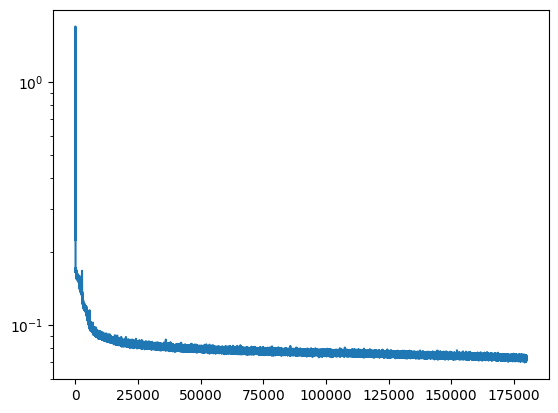

 60%|██████    | 180111/300000 [41:25<35:12, 56.76it/s]

<bound method _item of Array(0.07332709, dtype=float32)>


 60%|██████    | 180207/300000 [41:26<35:26, 56.34it/s]

<bound method _item of Array(0.07235853, dtype=float32)>


 60%|██████    | 180309/300000 [41:28<34:49, 57.28it/s]

<bound method _item of Array(0.07239754, dtype=float32)>


 60%|██████    | 180412/300000 [41:30<34:24, 57.92it/s]

<bound method _item of Array(0.07350478, dtype=float32)>


 60%|██████    | 180508/300000 [41:32<34:09, 58.29it/s]

<bound method _item of Array(0.07329345, dtype=float32)>


 60%|██████    | 180611/300000 [41:33<35:47, 55.59it/s]

<bound method _item of Array(0.07363901, dtype=float32)>


 60%|██████    | 180707/300000 [41:35<36:35, 54.33it/s]

<bound method _item of Array(0.07271656, dtype=float32)>


 60%|██████    | 180809/300000 [41:37<34:57, 56.82it/s]

<bound method _item of Array(0.07343212, dtype=float32)>


 60%|██████    | 180911/300000 [41:39<35:01, 56.68it/s]

<bound method _item of Array(0.07331666, dtype=float32)>


 60%|██████    | 181007/300000 [41:40<34:31, 57.45it/s]

<bound method _item of Array(0.07456627, dtype=float32)>


 60%|██████    | 181109/300000 [41:42<34:01, 58.24it/s]

<bound method _item of Array(0.07415713, dtype=float32)>


 60%|██████    | 181211/300000 [41:44<35:26, 55.85it/s]

<bound method _item of Array(0.07315915, dtype=float32)>


 60%|██████    | 181307/300000 [41:46<35:08, 56.28it/s]

<bound method _item of Array(0.07243226, dtype=float32)>


 60%|██████    | 181409/300000 [41:48<36:32, 54.10it/s]

<bound method _item of Array(0.0733779, dtype=float32)>


 61%|██████    | 181511/300000 [41:49<34:47, 56.76it/s]

<bound method _item of Array(0.07413115, dtype=float32)>


 61%|██████    | 181607/300000 [41:51<34:27, 57.27it/s]

<bound method _item of Array(0.07284454, dtype=float32)>


 61%|██████    | 181709/300000 [41:53<34:23, 57.33it/s]

<bound method _item of Array(0.07267734, dtype=float32)>


 61%|██████    | 181811/300000 [41:55<33:39, 58.51it/s]

<bound method _item of Array(0.07296032, dtype=float32)>


 61%|██████    | 181907/300000 [41:56<34:39, 56.78it/s]

<bound method _item of Array(0.07280651, dtype=float32)>


 61%|██████    | 182009/300000 [41:58<35:18, 55.70it/s]

<bound method _item of Array(0.07200953, dtype=float32)>


 61%|██████    | 182111/300000 [42:00<35:07, 55.95it/s]

<bound method _item of Array(0.07204706, dtype=float32)>


 61%|██████    | 182207/300000 [42:02<34:33, 56.81it/s]

<bound method _item of Array(0.07220525, dtype=float32)>


 61%|██████    | 182309/300000 [42:03<34:22, 57.07it/s]

<bound method _item of Array(0.07224582, dtype=float32)>


 61%|██████    | 182411/300000 [42:05<33:59, 57.67it/s]

<bound method _item of Array(0.07144772, dtype=float32)>


 61%|██████    | 182507/300000 [42:07<33:46, 57.97it/s]

<bound method _item of Array(0.07178552, dtype=float32)>


 61%|██████    | 182609/300000 [42:09<34:47, 56.22it/s]

<bound method _item of Array(0.07218473, dtype=float32)>


 61%|██████    | 182711/300000 [42:11<35:33, 54.98it/s]

<bound method _item of Array(0.07271946, dtype=float32)>


 61%|██████    | 182807/300000 [42:12<34:15, 57.03it/s]

<bound method _item of Array(0.07294513, dtype=float32)>


 61%|██████    | 182909/300000 [42:14<33:46, 57.78it/s]

<bound method _item of Array(0.07243493, dtype=float32)>


 61%|██████    | 183011/300000 [42:16<34:00, 57.33it/s]

<bound method _item of Array(0.07274998, dtype=float32)>


 61%|██████    | 183107/300000 [42:17<34:17, 56.83it/s]

<bound method _item of Array(0.07218277, dtype=float32)>


 61%|██████    | 183209/300000 [42:19<33:34, 57.99it/s]

<bound method _item of Array(0.07239654, dtype=float32)>


 61%|██████    | 183311/300000 [42:21<35:34, 54.67it/s]

<bound method _item of Array(0.07199958, dtype=float32)>


 61%|██████    | 183407/300000 [42:23<35:02, 55.46it/s]

<bound method _item of Array(0.07376941, dtype=float32)>


 61%|██████    | 183509/300000 [42:25<35:06, 55.30it/s]

<bound method _item of Array(0.07196726, dtype=float32)>


 61%|██████    | 183611/300000 [42:26<34:09, 56.79it/s]

<bound method _item of Array(0.07160519, dtype=float32)>


 61%|██████    | 183708/300000 [42:28<34:25, 56.30it/s]

<bound method _item of Array(0.07369308, dtype=float32)>


 61%|██████▏   | 183810/300000 [42:30<33:12, 58.33it/s]

<bound method _item of Array(0.0724946, dtype=float32)>


 61%|██████▏   | 183909/300000 [42:32<32:59, 58.63it/s]

<bound method _item of Array(0.07238989, dtype=float32)>


 61%|██████▏   | 184011/300000 [42:33<34:24, 56.17it/s]

<bound method _item of Array(0.07226519, dtype=float32)>


 61%|██████▏   | 184107/300000 [42:35<34:35, 55.84it/s]

<bound method _item of Array(0.07127189, dtype=float32)>


 61%|██████▏   | 184209/300000 [42:37<33:18, 57.95it/s]

<bound method _item of Array(0.07183403, dtype=float32)>


 61%|██████▏   | 184311/300000 [42:39<34:07, 56.51it/s]

<bound method _item of Array(0.07177889, dtype=float32)>


 61%|██████▏   | 184407/300000 [42:40<32:53, 58.58it/s]

<bound method _item of Array(0.07308906, dtype=float32)>


 62%|██████▏   | 184509/300000 [42:42<33:15, 57.88it/s]

<bound method _item of Array(0.07460348, dtype=float32)>


 62%|██████▏   | 184611/300000 [42:44<33:32, 57.34it/s]

<bound method _item of Array(0.07257645, dtype=float32)>


 62%|██████▏   | 184708/300000 [42:46<34:09, 56.26it/s]

<bound method _item of Array(0.07189035, dtype=float32)>


 62%|██████▏   | 184810/300000 [42:47<33:38, 57.06it/s]

<bound method _item of Array(0.07233939, dtype=float32)>


 62%|██████▏   | 184912/300000 [42:49<33:21, 57.51it/s]

<bound method _item of Array(0.07183349, dtype=float32)>


 62%|██████▏   | 185008/300000 [42:51<33:07, 57.86it/s]

<bound method _item of Array(0.07329199, dtype=float32)>


 62%|██████▏   | 185110/300000 [42:53<33:09, 57.76it/s]

<bound method _item of Array(0.07393101, dtype=float32)>


 62%|██████▏   | 185212/300000 [42:54<34:20, 55.71it/s]

<bound method _item of Array(0.07184202, dtype=float32)>


 62%|██████▏   | 185308/300000 [42:56<33:22, 57.26it/s]

<bound method _item of Array(0.07239733, dtype=float32)>


 62%|██████▏   | 185410/300000 [42:58<36:20, 52.56it/s]

<bound method _item of Array(0.0726888, dtype=float32)>


 62%|██████▏   | 185512/300000 [43:00<33:55, 56.25it/s]

<bound method _item of Array(0.07123566, dtype=float32)>


 62%|██████▏   | 185608/300000 [43:01<33:04, 57.65it/s]

<bound method _item of Array(0.07352529, dtype=float32)>


 62%|██████▏   | 185710/300000 [43:03<33:15, 57.27it/s]

<bound method _item of Array(0.0725437, dtype=float32)>


 62%|██████▏   | 185812/300000 [43:05<32:26, 58.66it/s]

<bound method _item of Array(0.07327164, dtype=float32)>


 62%|██████▏   | 185909/300000 [43:07<32:25, 58.65it/s]

<bound method _item of Array(0.07319766, dtype=float32)>


 62%|██████▏   | 186011/300000 [43:08<33:12, 57.21it/s]

<bound method _item of Array(0.07262968, dtype=float32)>


 62%|██████▏   | 186107/300000 [43:10<34:13, 55.45it/s]

<bound method _item of Array(0.07188293, dtype=float32)>


 62%|██████▏   | 186209/300000 [43:12<33:19, 56.91it/s]

<bound method _item of Array(0.07176037, dtype=float32)>


 62%|██████▏   | 186311/300000 [43:14<33:35, 56.41it/s]

<bound method _item of Array(0.07182501, dtype=float32)>


 62%|██████▏   | 186407/300000 [43:15<33:17, 56.88it/s]

<bound method _item of Array(0.0729646, dtype=float32)>


 62%|██████▏   | 186509/300000 [43:17<32:59, 57.35it/s]

<bound method _item of Array(0.07239992, dtype=float32)>


 62%|██████▏   | 186611/300000 [43:19<33:37, 56.19it/s]

<bound method _item of Array(0.07184357, dtype=float32)>


 62%|██████▏   | 186707/300000 [43:21<33:38, 56.13it/s]

<bound method _item of Array(0.07277995, dtype=float32)>


 62%|██████▏   | 186809/300000 [43:23<34:45, 54.28it/s]

<bound method _item of Array(0.07142931, dtype=float32)>


 62%|██████▏   | 186911/300000 [43:24<33:16, 56.63it/s]

<bound method _item of Array(0.07386906, dtype=float32)>


 62%|██████▏   | 187007/300000 [43:26<33:53, 55.57it/s]

<bound method _item of Array(0.07160759, dtype=float32)>


 62%|██████▏   | 187109/300000 [43:28<32:53, 57.20it/s]

<bound method _item of Array(0.07189141, dtype=float32)>


 62%|██████▏   | 187211/300000 [43:30<33:13, 56.58it/s]

<bound method _item of Array(0.07250102, dtype=float32)>


 62%|██████▏   | 187307/300000 [43:31<32:18, 58.14it/s]

<bound method _item of Array(0.07257587, dtype=float32)>


 62%|██████▏   | 187409/300000 [43:33<34:16, 54.76it/s]

<bound method _item of Array(0.07261086, dtype=float32)>


 63%|██████▎   | 187511/300000 [43:35<33:55, 55.27it/s]

<bound method _item of Array(0.07158259, dtype=float32)>


 63%|██████▎   | 187607/300000 [43:37<33:01, 56.73it/s]

<bound method _item of Array(0.07197329, dtype=float32)>


 63%|██████▎   | 187709/300000 [43:39<33:15, 56.27it/s]

<bound method _item of Array(0.07410704, dtype=float32)>


 63%|██████▎   | 187811/300000 [43:40<32:24, 57.70it/s]

<bound method _item of Array(0.07220547, dtype=float32)>


 63%|██████▎   | 187907/300000 [43:42<33:02, 56.54it/s]

<bound method _item of Array(0.07134397, dtype=float32)>


 63%|██████▎   | 188009/300000 [43:44<32:53, 56.74it/s]

<bound method _item of Array(0.07360346, dtype=float32)>


 63%|██████▎   | 188111/300000 [43:46<33:53, 55.02it/s]

<bound method _item of Array(0.07255695, dtype=float32)>


 63%|██████▎   | 188207/300000 [43:47<33:32, 55.55it/s]

<bound method _item of Array(0.07300431, dtype=float32)>


 63%|██████▎   | 188309/300000 [43:49<32:07, 57.96it/s]

<bound method _item of Array(0.07128936, dtype=float32)>


 63%|██████▎   | 188411/300000 [43:51<32:08, 57.87it/s]

<bound method _item of Array(0.06995016, dtype=float32)>


 63%|██████▎   | 188507/300000 [43:53<31:59, 58.09it/s]

<bound method _item of Array(0.07222212, dtype=float32)>


 63%|██████▎   | 188610/300000 [43:54<31:56, 58.11it/s]

<bound method _item of Array(0.07281586, dtype=float32)>


 63%|██████▎   | 188712/300000 [43:56<32:15, 57.50it/s]

<bound method _item of Array(0.07154926, dtype=float32)>


 63%|██████▎   | 188808/300000 [43:58<33:12, 55.81it/s]

<bound method _item of Array(0.07262975, dtype=float32)>


 63%|██████▎   | 188910/300000 [44:00<33:51, 54.68it/s]

<bound method _item of Array(0.07101843, dtype=float32)>


 63%|██████▎   | 189012/300000 [44:02<32:03, 57.71it/s]

<bound method _item of Array(0.07219709, dtype=float32)>


 63%|██████▎   | 189108/300000 [44:03<32:35, 56.72it/s]

<bound method _item of Array(0.07167634, dtype=float32)>


 63%|██████▎   | 189210/300000 [44:05<32:19, 57.12it/s]

<bound method _item of Array(0.07209029, dtype=float32)>


 63%|██████▎   | 189312/300000 [44:07<32:07, 57.44it/s]

<bound method _item of Array(0.07159159, dtype=float32)>


 63%|██████▎   | 189408/300000 [44:09<32:43, 56.32it/s]

<bound method _item of Array(0.07106689, dtype=float32)>


 63%|██████▎   | 189510/300000 [44:10<32:52, 56.01it/s]

<bound method _item of Array(0.07250911, dtype=float32)>


 63%|██████▎   | 189612/300000 [44:12<31:53, 57.69it/s]

<bound method _item of Array(0.07183434, dtype=float32)>


 63%|██████▎   | 189708/300000 [44:14<32:03, 57.34it/s]

<bound method _item of Array(0.07148475, dtype=float32)>


 63%|██████▎   | 189810/300000 [44:16<33:13, 55.27it/s]

<bound method _item of Array(0.07276238, dtype=float32)>


 63%|██████▎   | 189912/300000 [44:17<32:38, 56.21it/s]

<bound method _item of Array(0.07084937, dtype=float32)>


 63%|██████▎   | 189996/300000 [44:19<32:06, 57.10it/s]

<bound method _item of Array(0.07235518, dtype=float32)>


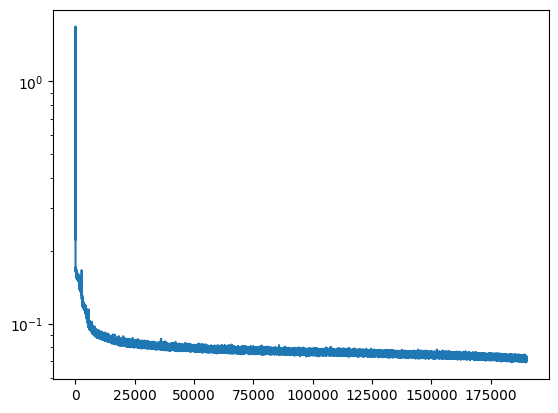

 63%|██████▎   | 190110/300000 [44:21<31:52, 57.46it/s]

<bound method _item of Array(0.07194435, dtype=float32)>


 63%|██████▎   | 190206/300000 [44:23<31:51, 57.43it/s]

<bound method _item of Array(0.07151143, dtype=float32)>


 63%|██████▎   | 190308/300000 [44:25<31:43, 57.63it/s]

<bound method _item of Array(0.0721638, dtype=float32)>


 63%|██████▎   | 190410/300000 [44:27<32:16, 56.60it/s]

<bound method _item of Array(0.07150621, dtype=float32)>


 64%|██████▎   | 190512/300000 [44:28<32:25, 56.27it/s]

<bound method _item of Array(0.07105906, dtype=float32)>


 64%|██████▎   | 190608/300000 [44:30<31:50, 57.25it/s]

<bound method _item of Array(0.07315472, dtype=float32)>


 64%|██████▎   | 190710/300000 [44:32<32:43, 55.65it/s]

<bound method _item of Array(0.07124131, dtype=float32)>


 64%|██████▎   | 190812/300000 [44:34<32:33, 55.89it/s]

<bound method _item of Array(0.07206394, dtype=float32)>


 64%|██████▎   | 190908/300000 [44:35<33:02, 55.02it/s]

<bound method _item of Array(0.07310338, dtype=float32)>


 64%|██████▎   | 191010/300000 [44:37<31:44, 57.22it/s]

<bound method _item of Array(0.07259251, dtype=float32)>


 64%|██████▎   | 191112/300000 [44:39<32:11, 56.39it/s]

<bound method _item of Array(0.07133142, dtype=float32)>


 64%|██████▎   | 191208/300000 [44:41<31:58, 56.70it/s]

<bound method _item of Array(0.07071343, dtype=float32)>


 64%|██████▍   | 191310/300000 [44:43<32:04, 56.48it/s]

<bound method _item of Array(0.07059955, dtype=float32)>


 64%|██████▍   | 191412/300000 [44:44<32:40, 55.39it/s]

<bound method _item of Array(0.07140513, dtype=float32)>


 64%|██████▍   | 191508/300000 [44:46<32:48, 55.11it/s]

<bound method _item of Array(0.07270458, dtype=float32)>


 64%|██████▍   | 191610/300000 [44:48<31:58, 56.49it/s]

<bound method _item of Array(0.07171083, dtype=float32)>


 64%|██████▍   | 191712/300000 [44:50<32:41, 55.22it/s]

<bound method _item of Array(0.07196197, dtype=float32)>


 64%|██████▍   | 191808/300000 [44:52<32:58, 54.68it/s]

<bound method _item of Array(0.07290458, dtype=float32)>


 64%|██████▍   | 191910/300000 [44:53<32:50, 54.85it/s]

<bound method _item of Array(0.0715165, dtype=float32)>


 64%|██████▍   | 192012/300000 [44:55<32:25, 55.50it/s]

<bound method _item of Array(0.0712116, dtype=float32)>


 64%|██████▍   | 192108/300000 [44:57<33:32, 53.60it/s]

<bound method _item of Array(0.072048, dtype=float32)>


 64%|██████▍   | 192210/300000 [44:59<32:25, 55.41it/s]

<bound method _item of Array(0.07170151, dtype=float32)>


 64%|██████▍   | 192312/300000 [45:01<31:35, 56.81it/s]

<bound method _item of Array(0.06958628, dtype=float32)>


 64%|██████▍   | 192408/300000 [45:02<31:20, 57.21it/s]

<bound method _item of Array(0.07143598, dtype=float32)>


 64%|██████▍   | 192510/300000 [45:04<31:34, 56.75it/s]

<bound method _item of Array(0.07191069, dtype=float32)>


 64%|██████▍   | 192612/300000 [45:06<32:00, 55.91it/s]

<bound method _item of Array(0.07179775, dtype=float32)>


 64%|██████▍   | 192708/300000 [45:08<31:42, 56.40it/s]

<bound method _item of Array(0.07257663, dtype=float32)>


 64%|██████▍   | 192810/300000 [45:09<32:08, 55.57it/s]

<bound method _item of Array(0.07226907, dtype=float32)>


 64%|██████▍   | 192912/300000 [45:11<31:05, 57.40it/s]

<bound method _item of Array(0.07081063, dtype=float32)>


 64%|██████▍   | 193008/300000 [45:13<31:38, 56.36it/s]

<bound method _item of Array(0.07189041, dtype=float32)>


 64%|██████▍   | 193110/300000 [45:15<31:17, 56.92it/s]

<bound method _item of Array(0.07178723, dtype=float32)>


 64%|██████▍   | 193212/300000 [45:17<31:24, 56.66it/s]

<bound method _item of Array(0.07287752, dtype=float32)>


 64%|██████▍   | 193308/300000 [45:18<31:50, 55.86it/s]

<bound method _item of Array(0.0719556, dtype=float32)>


 64%|██████▍   | 193410/300000 [45:20<32:44, 54.24it/s]

<bound method _item of Array(0.07099126, dtype=float32)>


 65%|██████▍   | 193512/300000 [45:22<32:27, 54.69it/s]

<bound method _item of Array(0.0727127, dtype=float32)>


 65%|██████▍   | 193608/300000 [45:24<32:49, 54.01it/s]

<bound method _item of Array(0.07179022, dtype=float32)>


 65%|██████▍   | 193710/300000 [45:26<32:10, 55.07it/s]

<bound method _item of Array(0.07137383, dtype=float32)>


 65%|██████▍   | 193812/300000 [45:27<32:06, 55.13it/s]

<bound method _item of Array(0.07187092, dtype=float32)>


 65%|██████▍   | 193908/300000 [45:29<31:41, 55.81it/s]

<bound method _item of Array(0.07080031, dtype=float32)>


 65%|██████▍   | 194010/300000 [45:31<32:24, 54.52it/s]

<bound method _item of Array(0.07122143, dtype=float32)>


 65%|██████▍   | 194106/300000 [45:33<34:35, 51.03it/s]

<bound method _item of Array(0.07113211, dtype=float32)>


 65%|██████▍   | 194208/300000 [45:35<32:26, 54.36it/s]

<bound method _item of Array(0.0726456, dtype=float32)>


 65%|██████▍   | 194310/300000 [45:37<32:12, 54.68it/s]

<bound method _item of Array(0.07172489, dtype=float32)>


 65%|██████▍   | 194406/300000 [45:39<33:56, 51.84it/s]

<bound method _item of Array(0.07081749, dtype=float32)>


 65%|██████▍   | 194508/300000 [45:40<31:55, 55.08it/s]

<bound method _item of Array(0.07182703, dtype=float32)>


 65%|██████▍   | 194610/300000 [45:42<31:24, 55.93it/s]

<bound method _item of Array(0.07199131, dtype=float32)>


 65%|██████▍   | 194712/300000 [45:44<32:41, 53.67it/s]

<bound method _item of Array(0.07141647, dtype=float32)>


 65%|██████▍   | 194808/300000 [45:46<32:15, 54.35it/s]

<bound method _item of Array(0.07133038, dtype=float32)>


 65%|██████▍   | 194910/300000 [45:48<30:37, 57.21it/s]

<bound method _item of Array(0.07159871, dtype=float32)>


 65%|██████▌   | 195012/300000 [45:49<30:30, 57.36it/s]

<bound method _item of Array(0.07062504, dtype=float32)>


 65%|██████▌   | 195108/300000 [45:51<31:04, 56.25it/s]

<bound method _item of Array(0.07188036, dtype=float32)>


 65%|██████▌   | 195210/300000 [45:53<30:55, 56.47it/s]

<bound method _item of Array(0.07214998, dtype=float32)>


 65%|██████▌   | 195312/300000 [45:55<30:37, 56.99it/s]

<bound method _item of Array(0.07164764, dtype=float32)>


 65%|██████▌   | 195408/300000 [45:57<32:17, 53.98it/s]

<bound method _item of Array(0.07180432, dtype=float32)>


 65%|██████▌   | 195510/300000 [45:58<32:18, 53.91it/s]

<bound method _item of Array(0.07277695, dtype=float32)>


 65%|██████▌   | 195612/300000 [46:00<31:04, 55.99it/s]

<bound method _item of Array(0.0720283, dtype=float32)>


 65%|██████▌   | 195708/300000 [46:02<30:59, 56.08it/s]

<bound method _item of Array(0.07008139, dtype=float32)>


 65%|██████▌   | 195810/300000 [46:04<31:20, 55.40it/s]

<bound method _item of Array(0.07102485, dtype=float32)>


 65%|██████▌   | 195912/300000 [46:06<31:03, 55.85it/s]

<bound method _item of Array(0.07081386, dtype=float32)>


 65%|██████▌   | 196008/300000 [46:07<32:03, 54.08it/s]

<bound method _item of Array(0.07069124, dtype=float32)>


 65%|██████▌   | 196110/300000 [46:09<32:04, 53.97it/s]

<bound method _item of Array(0.07141727, dtype=float32)>


 65%|██████▌   | 196212/300000 [46:11<31:28, 54.96it/s]

<bound method _item of Array(0.07328573, dtype=float32)>


 65%|██████▌   | 196308/300000 [46:13<31:02, 55.69it/s]

<bound method _item of Array(0.07114058, dtype=float32)>


 65%|██████▌   | 196410/300000 [46:15<31:27, 54.87it/s]

<bound method _item of Array(0.07139308, dtype=float32)>


 66%|██████▌   | 196512/300000 [46:17<30:31, 56.49it/s]

<bound method _item of Array(0.07200086, dtype=float32)>


 66%|██████▌   | 196608/300000 [46:18<33:08, 51.99it/s]

<bound method _item of Array(0.07021711, dtype=float32)>


 66%|██████▌   | 196710/300000 [46:20<33:18, 51.69it/s]

<bound method _item of Array(0.07264821, dtype=float32)>


 66%|██████▌   | 196812/300000 [46:22<31:08, 55.23it/s]

<bound method _item of Array(0.07253885, dtype=float32)>


 66%|██████▌   | 196908/300000 [46:24<31:31, 54.50it/s]

<bound method _item of Array(0.07189671, dtype=float32)>


 66%|██████▌   | 197010/300000 [46:26<30:58, 55.41it/s]

<bound method _item of Array(0.07187691, dtype=float32)>


 66%|██████▌   | 197112/300000 [46:28<30:24, 56.39it/s]

<bound method _item of Array(0.0706002, dtype=float32)>


 66%|██████▌   | 197208/300000 [46:29<31:13, 54.86it/s]

<bound method _item of Array(0.07246339, dtype=float32)>


 66%|██████▌   | 197310/300000 [46:31<32:00, 53.48it/s]

<bound method _item of Array(0.07130255, dtype=float32)>


 66%|██████▌   | 197317/300000 [46:31<24:12, 70.68it/s]


KeyboardInterrupt: 

In [55]:



def d_calculate(m: List[int]):
    v0, r = m

    S0 = 100.0             # asset price
    T = 1.0                # time in years
    N = 251                # number of time steps in simulation
    M = 1

    def bs_price(S0, v0, r, T, N, M):


      dt = T/N
      mu = np.array([0,0])
      rho = 0
      cov = np.array([[1,rho],
                      [rho,1]])


      S = np.full(shape=(N+1,M), fill_value=S0)
      v = np.full(shape=(N+1,M), fill_value=v0)

      Z = np.random.multivariate_normal(mu, cov, (N,M))


      for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = v[i-1]
      return S, v


    S_p,v_p = bs_price(S0, v0 = current_params[0][0],r = current_params[0][1], T = T, N = N, M = M)
    S_p_mean = []
    for i in range(1,len(S_p)):
      S_p_mean.append((S_p[i] - S_p[i-1])/S_p[i-1])
    S_p_mean.append(S_p_mean[-1])
    return S_p_mean



m = jnp.load(f'm_tensorflow_vol_bs_uniform_prices_true_lined_delta_true.npy')
d = jnp.load(f'd_tensorflow_vol_bs_uniform_prices_true_lined_delta_true.npy')
#Ниже очень грубая попытка заскейлить временной ряд к значениям около 1
#d = d/100
#Ниже модель и обучение

class MLP(nn.Module):
    dim: int
    out_dim: int = 1
    w: int = 510
    #w: int = 258

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.w)(x)
        x = nn.sigmoid(x)
        x = nn.Dense(205)(x)
        x = nn.sigmoid(x)
        x = nn.Dense(205)(x)
        x = nn.sigmoid(x)
        x = nn.Dense(129)(x)
        x = nn.sigmoid(x)

        x = nn.Dense(self.out_dim)(x)
        return x



class CNN1D(nn.Module):
    dim: int
    out_dim: int = 1
    w: int = 510
    #w: int = 258


    @nn.compact
    def __call__(self, x):

        #x = nn.Conv(features=255, kernel_size=(3,), strides=(1,), padding='SAME')(x)
        x = nn.Conv(features=255, kernel_size=(15,), strides=(1,))(x)
        x = nn.sigmoid(x)

        x = nn.Conv(features=255, kernel_size=(3,), strides=(1,), padding='SAME')(x)
        x = nn.sigmoid(x)

        x = nn.Conv(features=128, kernel_size=(3,), strides=(1,), padding='SAME')(x)
        x = nn.sigmoid(x)

        x = nn.Conv(features=128, kernel_size=(3,), strides=(1,), padding='SAME')(x)
        x = nn.sigmoid(x)

        x = x.reshape(x.shape[0], -1)

        x = nn.Dense(128)(x)
        x = nn.Dense(128)(x)

        x = nn.Dense(64)(x)
        x = nn.Dense(2)(x)

        return x



model = CNN1D(dim=255, out_dim=2)

@jax.jit
def predict(params, inputs):
    return model.apply({"params": params}, inputs)

@jax.jit
def sample_conditional_pt(x0, x1, t):
    t = t.reshape(-1, *([1] * (x0.ndim - 1)))
    mu_t = t * x1 + (1 - t) * x0
    return mu_t

@jax.jit
def compute_conditional_vector_field(x0, x1):
    return x1 - x0

@jax.jit
def loss_ffm_function(params, x1, x0, d, key):
    key, subkey = jax.random.split(key)
    t = jax.random.uniform(subkey, (x0.shape[0],))
    xt = sample_conditional_pt(x0, x1, t)
    ut = compute_conditional_vector_field(x0, x1)
    inputs = jnp.concatenate([xt, d, t[:, None]], axis=-1)
    vt = predict(params, inputs)
    loss = jnp.mean((vt - ut) ** 2)
    return loss

@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

@jax.jit
def ode_function(t, m, d):
    m = m.reshape(1, -1)
    d = d.reshape(1, -1)
    t = jnp.array(t).reshape(1,-1)
    inputs = jnp.concatenate([m, d, t], axis=1)
    return predict(state.params, inputs)[0]

key = jax.random.PRNGKey(0)
#batch_size = 1000
batch_size = 10000

num_epochs = 300000
#learning_rate = 0.0001
learning_rate = 0.001
optimizer = optax.adamw(learning_rate=learning_rate)
params = model.init(key, np.random.rand(1,255))

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params["params"],
    tx=optimizer
)

dim = m[0].shape[0] + d[0].shape[0]
print(dim)

dataset = jnp.concatenate([m, d], axis = 1)
loader = jax.random.permutation(key, dataset)

losses = [np.inf]
#column_index = 1

start = time.time()
for k in tqdm(range(num_epochs)):
    key, subkey = jax.random.split(key)
    batch_indices = jax.random.choice(subkey, jnp.arange(len(dataset)), (batch_size,))
    batch = dataset[batch_indices]

    x0 = jax.random.uniform(subkey, (batch_size, 2))
    #x0 = abs(np.random.uniform(0, 1, size = (batch_size,2)))
    #x0 = jnp.array(abs(np.random.normal(0.5, 0.5, size = (batch_size,4))))[0]
    #x0[:, column_index][x0[:, column_index] > 1] = 1
    #x0[:, 0][x0[:, 0] < 0] = 0

    x1 = batch[:, 0:2]
    d = batch[:, 2:]

    loss, grads = jax.value_and_grad(loss_ffm_function, has_aux=False)(state.params, x1, x0, d, subkey)
    state = update_model(state, grads)
    if loss.item() < np.min(losses):
        with open(f'w_best.pkl', 'wb') as f:
            pickle.dump(state.params, f)
    losses.append(loss.item())
    if k%100 == 0:
      print(loss.item)
    if k%10000 == 0:
      plt.plot(losses)
      plt.yscale('log')
      plt.show()

np.save(f"losses.npy", np.array(losses))

with open(f'w.pkl', 'wb') as f:
    pickle.dump(state.params, f)



print('-------------------Model done')

'''
m0 =np.random.normal(0,1, size=(1,5))
m = [1, 1, 0.5, 0.5, 0.5]
d = d_calculate(m)
d = jnp.array(d).reshape(1,-1)
#print(d)
m0 = jnp.array(m0).reshape(1,-1)
m = jnp.array(m).reshape(1,-1)




solution = solve_ivp(ode_function, t_span=[0, 1], y0=m0[0], t_eval=None, args=(d))


print('Second_check')
d_pred = d_calculate(solution.y[:, -1])
d_pred = jnp.array(d_pred).reshape(1,-1).flatten()
diff_norm = jnp.linalg.norm(d - d_pred) / jnp.linalg.norm(d)
'''


In [ ]:
with open(f'w_best.pkl', 'wb') as f:
    pickle.dump(state.params, f)

In [88]:
errors = []
sols = []
m = jnp.array(abs(np.random.uniform(0, 1, size = (1,2)))).reshape(1,-1)[0]


d = d_calculate(m)
print(len(d))
for i in tqdm(range(1000)):

    m0 = jnp.array(abs(np.random.uniform(0, 1, size = (1,2)))).reshape(1,-1)[0]
    m = jnp.array(m).reshape(1,-1)
    d = jnp.array(d).reshape(1,-1)
    solution = solve_ivp(ode_function, t_span=[0, 1], y0=m0, t_eval=None, args=(d))
    solution_iteration = solution.y[:, -1]

    d_pred = d_calculate(solution_iteration)
    d_pred = jnp.array(d_pred).reshape(1,-1).flatten()
    sols.append(solution_iteration)
    try:
        errors.append(np.linalg.norm(d - d_pred) / np.linalg.norm(d))
    except ValueError:
        pass

print(np.mean(errors), np.std(errors))

252


100%|██████████| 1000/1000 [00:40<00:00, 24.53it/s]

1.3530658 0.04921419


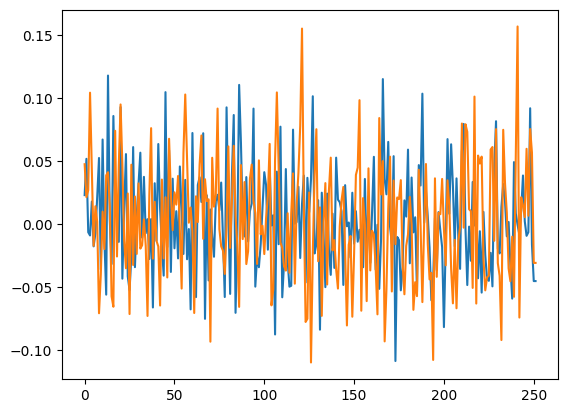

In [89]:
import matplotlib.pyplot as plt
sols_array = jnp.array(sols)
rounded_array = np.mean(sols_array, axis=0)
d_pred = d_calculate(rounded_array)
d_pred_plot = d_pred
plt.plot(d_pred_plot)

d_plot = d.flatten()
plt.plot(d_plot)

In [90]:
m

Array([[0.61136574, 0.09282938]], dtype=float32)

In [91]:
sols_array = jnp.array(sols)
rounded_array = np.mean(sols_array, axis=0)
rounded_array

Array([1.2045664, 0.5309862], dtype=float32)

<ipython-input-92-2b412ec4930b>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_list_pred.append(float(S_list_pred[-1]+d_pred[i]))


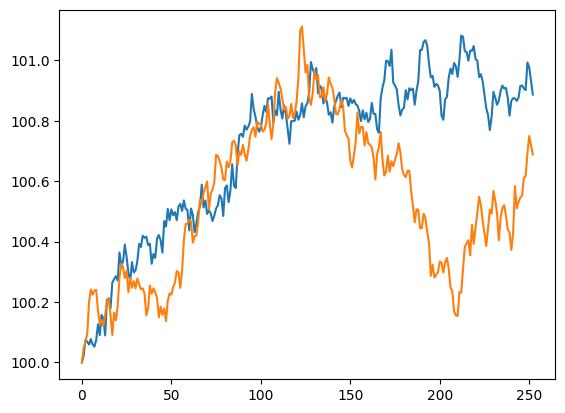

In [92]:
S_init = 100
S_list_pred = []
S_list_pred.append(S_init)
S_list_true = []
S_list_true.append(S_init)
for i in range(len(d_pred)):
  S_list_pred.append(float(S_list_pred[-1]+d_pred[i]))
  S_list_true.append(float(S_list_true[-1]+d_plot[i]))

plt.plot(S_list_pred)
plt.plot(S_list_true)
plt.show()


In [93]:
mu = []
sigma = []


for i in range(len(sols_array)):
  mu.append(float(sols_array[i][0]))
  sigma.append(float(sols_array[i][1]))



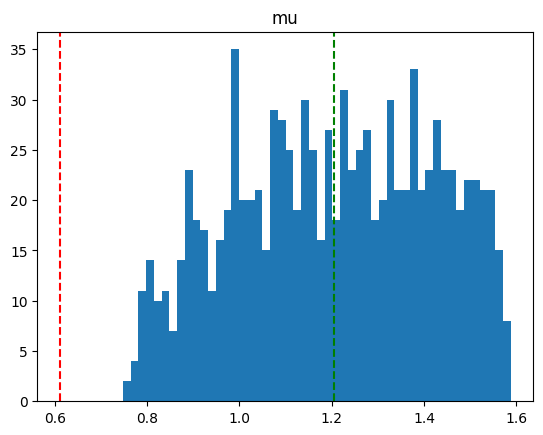

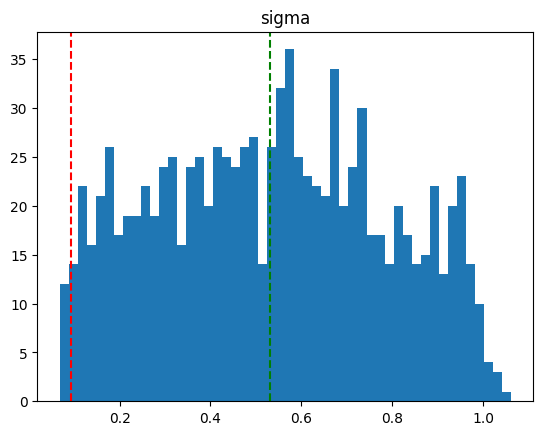

In [94]:
plt.hist(mu, bins = 50)
plt.axvline(m[0][0], color='red', linestyle='--', label='True')
plt.axvline(rounded_array[0], color='green', linestyle='--', label='True')
rounded_array
plt.title('mu')
plt.show()

plt.hist(sigma, bins = 50)
plt.axvline(m[0][1], color='red', linestyle='--', label='True')
plt.axvline(rounded_array[1], color='green', linestyle='--', label='True')
plt.title('sigma')
plt.show()



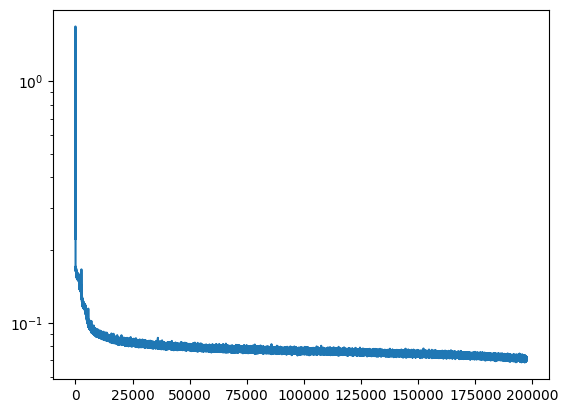

In [95]:
plt.plot(losses)
plt.yscale('log')
plt.show()